In [1]:
import numpy as np
import pandas as pd
import polars as pl
import sys
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px


pd.set_option('display.max_columns',None)
import psycopg2


#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#importing PCA and TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Truth set Generation from the vcf file

In [27]:
import os
from tqdm import tqdm  # Import tqdm for progress bar

def read_bed_file(bed_file):
    bed_positions = set()
    with open(bed_file, 'r') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) >= 3:
                try:
                    chrom = fields[0]
                    start = int(fields[1])
                    end = int(fields[2])
                except ValueError:
                    continue  # Skip this line if start or end position is not an integer
                for pos in range(start, end + 1):
                    bed_positions.add((chrom, pos))
    return bed_positions

def filter_tsv_file(tsv_file, bed_positions):
    filtered_tsv_records = []
    row_counter = 0  # Initialize a row counter
    with open(tsv_file, 'r') as f:
        for line in tqdm(f):  # Use tqdm to create a progress bar
            row_counter += 1  # Increment the row counter
            fields = line.strip().split('\t')
            if len(fields) >= 2:
                try:
                    chrom = fields[0]
                    pos = int(fields[1])
                except ValueError:
                    continue  # Skip this line if 'POS' is not an integer
                if (chrom, pos) in bed_positions:
                    filtered_tsv_records.append(line)
    return filtered_tsv_records, row_counter  # Return the filtered records and row counter

def write_filtered_tsv(filtered_tsv_records, output_file, column_headers):
    with open(output_file, 'w') as f:
        f.write('\t'.join(column_headers) + '\n')
        for record in filtered_tsv_records:
            f.write(record)

def main():
    bed_file = r'C:/Users/GenepoweRx_Madhu/Desktop/CHROM_POS.bed'
    input_file = r'E:\'
    output_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Truthset_dbsnp_SNV_covered_new.tsv'

    bed_positions = read_bed_file(bed_file)

    if not os.path.exists(os.path.dirname(output_file)):
        os.makedirs(os.path.dirname(output_file))

    with open(input_file, 'r') as f:
        column_headers = f.readline().strip().split('\t')
    filtered_tsv_records, row_counter = filter_tsv_file(input_file, bed_positions)
    write_filtered_tsv(filtered_tsv_records, output_file, column_headers)

    print(f"Number of rows processed: {row_counter}")

if __name__ == "__main__":
    main()

1045445353it [31:25, 554341.48it/s]


Number of rows processed: 1045445353


In [11]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/Covered_regions_LDLR_dbSNP.xlsx')
df

CHROM     START       END
0    chr19  11089242  11089283
1    chr19  11089297  11089338
2    chr19  11089301  11089342
3    chr19  11089308  11089349
4    chr19  11089311  11089352
..     ...       ...       ...
126  chr19  11133511  11133553
127  chr19  11133546  11133587
128  chr19  11133614  11133655
129  chr19  11133660  11133702
130  chr19  11133679  11133720

[131 rows x 3 columns]

In [12]:
bed_file_path = r'C:/Users/GenepoweRx_Madhu/Desktop/CHROM_POS_LDLR.bed'
df.to_csv(bed_file_path, sep='\t', header=False, index=False)

In [7]:
40926106 - 37247690

3678416

In [52]:
truth = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/output.tsv', sep = '\t')
truth

CHROM       POS REF ALT
0         chr1     65490   G   A
1         chr1     65529   C   T
2         chr1     65532   A   T
3         chr1     65552   G   A
4         chr1     65556   C   T
...        ...       ...  ..  ..
23761809  chrY  57194235   T   C
23761810  chrY  57194236   G   C
23761811  chrY  57194239   A   C
23761812  chrY  57194242   G   T
23761813  chrY  57194243   C   G

[23761814 rows x 4 columns]

In [53]:
truth = truth.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
truth

CHROM       POS REF ALT
0         chr1     65490   G   A
1         chr1     65529   C   T
2         chr1     65532   A   T
3         chr1     65552   G   A
4         chr1     65556   C   T
...        ...       ...  ..  ..
23761809  chrY  57194235   T   C
23761810  chrY  57194236   G   C
23761811  chrY  57194239   A   C
23761812  chrY  57194242   G   T
23761813  chrY  57194243   C   G

[23754638 rows x 4 columns]

In [54]:
truth_1 = truth.copy()
truth_1['ALT'] = truth_1['ALT'].str.split(',')
truth_1 = truth_1.explode('ALT')
truth_1

CHROM       POS REF ALT
0         chr1     65490   G   A
1         chr1     65529   C   T
2         chr1     65532   A   T
3         chr1     65552   G   A
4         chr1     65556   C   T
...        ...       ...  ..  ..
23761809  chrY  57194235   T   C
23761810  chrY  57194236   G   C
23761811  chrY  57194239   A   C
23761812  chrY  57194242   G   T
23761813  chrY  57194243   C   G

[28782909 rows x 4 columns]

# BCF

In [44]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_OLD/12652705_BCFTOOL.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf

CHROM        POS         rsID REF ALT      QUAL FILTER  \
0      chr1     826893    rs3115849   G   A   34.4159      .   
1      chr1     930939    rs9988021   G   A  225.4170      .   
2      chr1     941119    rs4372192   A   G  205.4170      .   
3      chr1     942451    rs6672356   T   C   34.4159      .   
4      chr1     944858    rs3748592   A   G  225.4170      .   
...     ...        ...          ...  ..  ..       ...    ...   
43793  chrX  154781346  rs782421732   G   C  176.3820      .   
43794  chrX  154929926    rs1800292   T   G  222.3760      .   
43795  chrY    1387425            .   C   G   23.4340      .   
43796  chrY    1418109            .   C   G   25.4267      .   
43797  chrY    2221159            .   T   C   28.4205      .   

                                                    INFO  \
0      DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...   
1      DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...   
2      DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...   
3      DP=2;ADF=0,2;ADR=0,0;AD=0,2;SCR=0;VDB=0.02;SGB...   
4      DP=14;ADF=0,7;ADR=0,5;AD=0,12;SCR=0;VDB=0.4033...   
...                                                  ...   
43793  DP=44;ADF=4,2;ADR=12,18;AD=16,20;SCR=0;VDB=0.0...   
43794  DP=86;ADF=22,21;ADR=21,16;AD=43,37;SCR=0;VDB=0...   
43795  DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...   
43796  DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...   
43797  DP=174;ADF=0,42;ADR=0,111;AD=0,153;SCR=0;VDB=0...   

                           FORMAT                                  SAMPLE  
0      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:64,255,0:93:0:0,38:0,55:0,93:0  
1      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:255,178,0:59:0:0,53:0,6:0,59:0  
2      GT:PL:DP:SP:ADF:ADR:AD:SCR       1/1:235,51,0:17:0:0,15:0,2:0,17:0  
3      GT:PL:DP:SP:ADF:ADR:AD:SCR            1/1:64,6,0:2:0:0,2:0,0:0,2:0  
4      GT:PL:DP:SP:ADF:ADR:AD:SCR        1/1:255,36,0:12:0:0,7:0,5:0,12:0  
...                           ...                                     ...  
43793  GT:PL:DP:SP:ADF:ADR:AD:SCR    0/1:209,0,243:36:4:4,2:12,18:16,20:0  
43794  GT:PL:DP:SP:ADF:ADR:AD:SCR  0/1:255,0,255:80:2:22,21:21,16:43,37:0  
43795  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,166,0:55:0:0,14:0,41:0,55:0  
43796  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:55,255,0:99:0:0,26:0,73:0,99:0  
43797  GT:PL:DP:SP:ADF:ADR:AD:SCR   1/1:58,255,0:153:0:0,42:0,111:0,153:0  

[43798 rows x 10 columns]

In [45]:
vcf.CHROM.value_counts()

chr1     4305
chr2     3046
chr19    3020
chr11    2768
chr17    2469
chr12    2342
chr3     2336
chr7     2242
chr5     1981
chr6     1979
chr16    1953
chr9     1939
chr10    1922
chr4     1828
chr14    1519
chr8     1487
chr15    1420
chr20    1198
chr22    1102
chr13     892
chrX      787
chr18     668
chr21     592
chrY        3
Name: CHROM, dtype: int64

In [202]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705_BCFTOOL.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
vcf = vcf[['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'VAF', 'gnomADe_AF', 'gnomADe_SAS_AF']]
vcf = vcf[vcf['QUAL'] >= 20]
vcf_vaf = vcf[vcf['VAF'] >= 0.1]
vcf_after = vcf_vaf[vcf_vaf['DP'] >= 15]
vcf_after = vcf_after[vcf_after['gnomADe_AF'] <= 0.5]
vcf_after = vcf_after[vcf_after['gnomADe_SAS_AF'] <= 0.5]
vcf_after

CHROM       POS REF ALT      QUAL   DP     VAF  gnomADe_AF  \
3      chr1    930939   G   A  225.4170   67  1.0000      0.0000   
6      chr1    942968   G   T   61.6017   28  0.1875      0.0000   
20     chr1    965125   G   C  225.4170  210  1.0000      0.2411   
21     chr1    973443   G   A  225.4170   36  1.0000      0.0000   
25     chr1    976536   C   T  225.4170   44  1.0000      0.1580   
...     ...       ...  ..  ..       ...  ...     ...         ...   
45814  chrY    631191   T   G   24.4299   56  1.0000      0.0000   
45815  chrY   1387425   C   G   24.4299   57  1.0000      0.0000   
45816  chrY   1418109   C   G   29.4193  107  1.0000      0.0000   
45824  chrY  11986362   A   C  105.4150   69  1.0000      0.0000   
45826  chrY  11986732   C   T  152.4160   20  1.0000      0.0000   

       gnomADe_SAS_AF  
3              0.0000  
6              0.0000  
20             0.3016  
21             0.0000  
25             0.2078  
...               ...  
45814          0.0000  
45815          0.0000  
45816          0.0000  
45824          0.0000  
45826          0.0000  

[26226 rows x 9 columns]

In [203]:
BCF = pd.merge(vcf_after, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'])
BCF = BCF.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
BCF

CHROM       POS REF ALT      QUAL   DP  VAF  gnomADe_AF  gnomADe_SAS_AF
0      chr1    930939   G   A  225.4170   67  1.0      0.0000          0.0000
1      chr1    965125   G   C  225.4170  210  1.0      0.2411          0.3016
2      chr1    973443   G   A  225.4170   36  1.0      0.0000          0.0000
3      chr1    976536   C   T  225.4170   44  1.0      0.1580          0.2078
4      chr1    981282   A   C  225.4170   79  1.0      0.0000          0.0000
...     ...       ...  ..  ..       ...  ...  ...         ...             ...
26099  chrY    631191   T   G   24.4299   56  1.0      0.0000          0.0000
26100  chrY   1387425   C   G   24.4299   57  1.0      0.0000          0.0000
26101  chrY   1418109   C   G   29.4193  107  1.0      0.0000          0.0000
26102  chrY  11986362   A   C  105.4150   69  1.0      0.0000          0.0000
26103  chrY  11986732   C   T  152.4160   20  1.0      0.0000          0.0000

[26091 rows x 9 columns]

# VARSCAN2

In [204]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705_VARSCAN2.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
vcf = vcf[['CHROM', 'POS', 'REF', 'ALT', 'DP', 'VAF', 'gnomADe_AF', 'gnomADe_SAS_AF']]
vcf_vaf = vcf[vcf['VAF'] >= 0.1]
vcf_after = vcf_vaf[vcf_vaf['DP'] >= 15]
vcf_after = vcf_after[vcf_after['gnomADe_AF'] <= 0.5]
vcf_after = vcf_after[vcf_after['gnomADe_SAS_AF'] <= 0.5]
vcf_after

CHROM       POS REF ALT   DP       VAF  gnomADe_AF  gnomADe_SAS_AF
2      chr1    930939   G   A   59  1.000000    0.000000         0.00000
12     chr1    962933   C   T   53  0.528302    0.003222         0.02645
14     chr1    965125   G   C  201  1.000000    0.241100         0.30160
15     chr1    973443   G   A   33  1.000000    0.000000         0.00000
19     chr1    976536   C   T   39  1.000000    0.158000         0.20780
...     ...       ...  ..  ..  ...       ...         ...             ...
42852  chrY  11986608   T   C   49  1.000000    0.000000         0.00000
42853  chrY  11986732   C   T   19  1.000000    0.000000         0.00000
42854  chrY  56961138   A   G   83  0.987952    0.000000         0.00000
42855  chrY  56961295   G   T   54  1.000000    0.000000         0.00000
42856  chrY  57128393   G   C  191  0.502618    0.000000         0.00000

[26217 rows x 8 columns]

In [205]:
VARSCAN2 = pd.merge(vcf_after, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'])
VARSCAN2 = VARSCAN2.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
VARSCAN2

CHROM       POS REF ALT   DP       VAF  gnomADe_AF  gnomADe_SAS_AF
0      chr1    930939   G   A   59  1.000000    0.000000         0.00000
1      chr1    962933   C   T   53  0.528302    0.003222         0.02645
2      chr1    965125   G   C  201  1.000000    0.241100         0.30160
3      chr1    973443   G   A   33  1.000000    0.000000         0.00000
4      chr1    976536   C   T   39  1.000000    0.158000         0.20780
...     ...       ...  ..  ..  ...       ...         ...             ...
26078  chrY  11986608   T   C   49  1.000000    0.000000         0.00000
26079  chrY  11986732   C   T   19  1.000000    0.000000         0.00000
26080  chrY  56961138   A   G   83  0.987952    0.000000         0.00000
26081  chrY  56961295   G   T   54  1.000000    0.000000         0.00000
26082  chrY  57128393   G   C  191  0.502618    0.000000         0.00000

[26071 rows x 8 columns]

# MUTECT2

In [206]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705_MUTECT2.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
vcf = vcf[['CHROM', 'POS', 'REF', 'ALT', 'DP', 'VAF', 'gnomADe_AF', 'gnomADe_SAS_AF']]
vcf_vaf = vcf[vcf['VAF'] >= 0.1]
vcf_after = vcf_vaf[vcf_vaf['DP'] >= 15]
vcf_after = vcf_after[vcf_after['gnomADe_AF'] <= 0.5]
vcf_after = vcf_after[vcf_after['gnomADe_SAS_AF'] <= 0.5]
vcf_after

CHROM        POS REF ALT   DP       VAF  gnomADe_AF  gnomADe_SAS_AF
5      chr1     930939   G   A   57  1.000000    0.000000        0.000000
18     chr1     962933   C   T   52  0.519231    0.003222        0.026450
21     chr1     965125   G   C  192  1.000000    0.241100        0.301600
22     chr1     972251   A   C   40  0.650000    0.083940        0.053660
23     chr1     973443   G   A   37  1.000000    0.000000        0.000000
...     ...        ...  ..  ..  ...       ...         ...             ...
48723  chrX  154776873   G   A   67  1.000000    0.146600        0.353400
48724  chrX  154781346   G   C   35  0.600000    0.000565        0.005461
48725  chrX  154929926   T   G   79  0.481013    0.147000        0.337700
48730  chrY   11986362   A   C   50  1.000000    0.000000        0.000000
48731  chrY   11986608   T   C   41  1.000000    0.000000        0.000000

[27473 rows x 8 columns]

In [207]:
MUTECT2 = pd.merge(vcf_after, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'])
MUTECT2 = MUTECT2.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
MUTECT2

CHROM        POS REF ALT   DP       VAF  gnomADe_AF  gnomADe_SAS_AF
0      chr1     930939   G   A   57  1.000000    0.000000        0.000000
1      chr1     962933   C   T   52  0.519231    0.003222        0.026450
2      chr1     965125   G   C  192  1.000000    0.241100        0.301600
3      chr1     972251   A   C   40  0.650000    0.083940        0.053660
4      chr1     973443   G   A   37  1.000000    0.000000        0.000000
...     ...        ...  ..  ..  ...       ...         ...             ...
27246  chrX  154776873   G   A   67  1.000000    0.146600        0.353400
27247  chrX  154781346   G   C   35  0.600000    0.000565        0.005461
27248  chrX  154929926   T   G   79  0.481013    0.147000        0.337700
27249  chrY   11986362   A   C   50  1.000000    0.000000        0.000000
27250  chrY   11986608   T   C   41  1.000000    0.000000        0.000000

[27239 rows x 8 columns]

# HAPLOTYPE

In [208]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705_HAPLOTYPECALLER.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
vcf = vcf[['CHROM', 'POS', 'REF', 'ALT', 'DP', 'VAF', 'gnomADe_AF', 'gnomADe_SAS_AF']]
vcf_vaf = vcf[vcf['VAF'] >= 0.1]
vcf_after = vcf_vaf[vcf_vaf['DP'] >= 15]
vcf_after = vcf_after[vcf_after['gnomADe_AF'] <= 0.5]
vcf_after = vcf_after[vcf_after['gnomADe_SAS_AF'] <= 0.5]
vcf_after

CHROM        POS REF ALT   DP       VAF  gnomADe_AF  gnomADe_SAS_AF
3      chr1     930939   G   A   57  1.000000    0.000000        0.000000
7      chr1     948711   C   G   15  0.266667    0.000000        0.000000
15     chr1     962933   C   T   52  0.519231    0.003222        0.026450
18     chr1     965125   G   C  193  1.000000    0.241100        0.301600
19     chr1     972251   A   C   40  0.650000    0.083940        0.053660
...     ...        ...  ..  ..  ...       ...         ...             ...
46606  chrX  154776873   G   A   67  1.000000    0.146600        0.353400
46607  chrX  154781346   G   C   35  0.600000    0.000565        0.005461
46608  chrX  154929926   T   G   79  0.481013    0.147000        0.337700
46616  chrY   11986362   A   C   50  1.000000    0.000000        0.000000
46617  chrY   11986608   T   C   41  1.000000    0.000000        0.000000

[27542 rows x 8 columns]

In [209]:
HAPLO = pd.merge(vcf_after, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'])
HAPLO = HAPLO.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
HAPLO

CHROM        POS REF ALT   DP       VAF  gnomADe_AF  gnomADe_SAS_AF
0      chr1     930939   G   A   57  1.000000    0.000000        0.000000
1      chr1     948711   C   G   15  0.266667    0.000000        0.000000
2      chr1     962933   C   T   52  0.519231    0.003222        0.026450
3      chr1     965125   G   C  193  1.000000    0.241100        0.301600
4      chr1     972251   A   C   40  0.650000    0.083940        0.053660
...     ...        ...  ..  ..  ...       ...         ...             ...
27412  chrX  154776873   G   A   67  1.000000    0.146600        0.353400
27413  chrX  154781346   G   C   35  0.600000    0.000565        0.005461
27414  chrX  154929926   T   G   79  0.481013    0.147000        0.337700
27415  chrY   11986362   A   C   50  1.000000    0.000000        0.000000
27416  chrY   11986608   T   C   41  1.000000    0.000000        0.000000

[27405 rows x 8 columns]

# DEEPVARIANT

In [210]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705_DEEPVARIANT.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[3]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
vcf = vcf[['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'VAF', 'gnomADe_AF', 'gnomADe_SAS_AF']]
vcf = vcf[vcf['QUAL'] >= 20]
vcf_vaf = vcf[vcf['VAF'] >= 0.1]
vcf_after = vcf_vaf[vcf_vaf['DP'] >= 15]
vcf_after = vcf_after[vcf_after['gnomADe_AF'] <= 0.5]
vcf_after = vcf_after[vcf_after['gnomADe_SAS_AF'] <= 0.5]
vcf_after

CHROM        POS REF ALT  QUAL   DP       VAF  gnomADe_AF  \
3      chr1     930939   G   A  53.7   66  1.000000    0.000000   
18     chr1     962933   C   T  46.6   56  0.553571    0.003222   
21     chr1     965125   G   C  59.3  217  1.000000    0.241100   
24     chr1     973443   G   A  58.6   37  1.000000    0.000000   
28     chr1     976536   C   T  55.9   43  1.000000    0.158000   
...     ...        ...  ..  ..   ...  ...       ...         ...   
49222  chrX  154776873   G   A  65.8   75  1.000000    0.146600   
49223  chrX  154781346   G   C  51.2   42  0.547619    0.000565   
49225  chrX  154929926   T   G  49.8   86  0.465116    0.147000   
49235  chrY   11986362   A   C  44.3   62  1.000000    0.000000   
49236  chrY   11986608   T   C  38.5   51  1.000000    0.000000   

       gnomADe_SAS_AF  
3            0.000000  
18           0.026450  
21           0.301600  
24           0.000000  
28           0.207800  
...               ...  
49222        0.353400  
49223        0.005461  
49225        0.337700  
49235        0.000000  
49236        0.000000  

[26098 rows x 9 columns]

In [211]:
DEEP = pd.merge(vcf_after, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'])
DEEP = DEEP.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
DEEP

CHROM        POS REF ALT  QUAL   DP       VAF  gnomADe_AF  \
0      chr1     930939   G   A  53.7   66  1.000000    0.000000   
1      chr1     962933   C   T  46.6   56  0.553571    0.003222   
2      chr1     965125   G   C  59.3  217  1.000000    0.241100   
3      chr1     973443   G   A  58.6   37  1.000000    0.000000   
4      chr1     976536   C   T  55.9   43  1.000000    0.158000   
...     ...        ...  ..  ..   ...  ...       ...         ...   
25985  chrX  154776873   G   A  65.8   75  1.000000    0.146600   
25986  chrX  154781346   G   C  51.2   42  0.547619    0.000565   
25987  chrX  154929926   T   G  49.8   86  0.465116    0.147000   
25988  chrY   11986362   A   C  44.3   62  1.000000    0.000000   
25989  chrY   11986608   T   C  38.5   51  1.000000    0.000000   

       gnomADe_SAS_AF  
0            0.000000  
1            0.026450  
2            0.301600  
3            0.000000  
4            0.207800  
...               ...  
25985        0.353400  
25986        0.005461  
25987        0.337700  
25988        0.000000  
25989        0.000000  

[25977 rows x 9 columns]

In [50]:
truth_1['ALT'] = truth_1['ALT'].str.split(',')
truth_1 = truth_1.explode('ALT')
truth_1

CHROM       POS REF ALT
0         chr1     65490   G   A
1         chr1     65529   C   T
2         chr1     65532   A   T
3         chr1     65552   G   A
4         chr1     65556   C   T
...        ...       ...  ..  ..
23761809  chrY  57194235   T   C
23761810  chrY  57194236   G   C
23761811  chrY  57194239   A   C
23761812  chrY  57194242   G   T
23761813  chrY  57194243   C   G

[28790922 rows x 4 columns]

In [59]:
intersection_ab_new = pd.merge(vcf_after, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'], how = 'inner')
intersection_ab_new

CHROM        POS         rsID REF ALT      QUAL FILTER  \
0      chr1     826893    rs3115849   G   A   34.4159      .   
1      chr1     930939    rs9988021   G   A  225.4170      .   
2      chr1     941119    rs4372192   A   G  205.4170      .   
3      chr1     944858    rs3748592   A   G  225.4170      .   
4      chr1     948245    rs4970378   A   G  225.4170      .   
...     ...        ...          ...  ..  ..       ...    ...   
42569  chrX  154781346  rs782421732   G   C  176.3820      .   
42570  chrX  154929926    rs1800292   T   G  222.3760      .   
42571  chrY    1387425            .   C   G   23.4340      .   
42572  chrY    1418109            .   C   G   25.4267      .   
42573  chrY    2221159            .   T   C   28.4205      .   

                                                    INFO  \
0      DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...   
1      DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...   
2      DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...   
3      DP=14;ADF=0,7;ADR=0,5;AD=0,12;SCR=0;VDB=0.4033...   
4      DP=73;ADF=0,15;ADR=0,46;AD=0,61;SCR=0;VDB=0.00...   
...                                                  ...   
42569  DP=44;ADF=4,2;ADR=12,18;AD=16,20;SCR=0;VDB=0.0...   
42570  DP=86;ADF=22,21;ADR=21,16;AD=43,37;SCR=0;VDB=0...   
42571  DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...   
42572  DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...   
42573  DP=174;ADF=0,42;ADR=0,111;AD=0,153;SCR=0;VDB=0...   

                           FORMAT                                  SAMPLE  \
0      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:64,255,0:93:0:0,38:0,55:0,93:0   
1      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:255,178,0:59:0:0,53:0,6:0,59:0   
2      GT:PL:DP:SP:ADF:ADR:AD:SCR       1/1:235,51,0:17:0:0,15:0,2:0,17:0   
3      GT:PL:DP:SP:ADF:ADR:AD:SCR        1/1:255,36,0:12:0:0,7:0,5:0,12:0   
4      GT:PL:DP:SP:ADF:ADR:AD:SCR     1/1:255,184,0:61:0:0,15:0,46:0,61:0   
...                           ...                                     ...   
42569  GT:PL:DP:SP:ADF:ADR:AD:SCR    0/1:209,0,243:36:4:4,2:12,18:16,20:0   
42570  GT:PL:DP:SP:ADF:ADR:AD:SCR  0/1:255,0,255:80:2:22,21:21,16:43,37:0   
42571  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,166,0:55:0:0,14:0,41:0,55:0   
42572  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:55,255,0:99:0:0,26:0,73:0,99:0   
42573  GT:PL:DP:SP:ADF:ADR:AD:SCR   1/1:58,255,0:153:0:0,42:0,111:0,153:0   

        DP     AD  RD  A_D       VAF  
0       97   0,93   0   93  1.000000  
1       67   0,59   0   59  1.000000  
2       23   0,17   0   17  1.000000  
3       14   0,12   0   12  1.000000  
4       73   0,61   0   61  1.000000  
...    ...    ...  ..  ...       ...  
42569   44  16,20  16   20  0.555556  
42570   86  43,37  43   37  0.462500  
42571   65   0,55   0   55  1.000000  
42572  111   0,99   0   99  1.000000  
42573  174  0,153   0  153  1.000000  

[42574 rows x 15 columns]

In [60]:
df = intersection_ab_new.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
df

CHROM        POS         rsID REF ALT      QUAL FILTER  \
0      chr1     826893    rs3115849   G   A   34.4159      .   
1      chr1     930939    rs9988021   G   A  225.4170      .   
2      chr1     941119    rs4372192   A   G  205.4170      .   
3      chr1     944858    rs3748592   A   G  225.4170      .   
4      chr1     948245    rs4970378   A   G  225.4170      .   
...     ...        ...          ...  ..  ..       ...    ...   
42569  chrX  154781346  rs782421732   G   C  176.3820      .   
42570  chrX  154929926    rs1800292   T   G  222.3760      .   
42571  chrY    1387425            .   C   G   23.4340      .   
42572  chrY    1418109            .   C   G   25.4267      .   
42573  chrY    2221159            .   T   C   28.4205      .   

                                                    INFO  \
0      DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...   
1      DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...   
2      DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...   
3      DP=14;ADF=0,7;ADR=0,5;AD=0,12;SCR=0;VDB=0.4033...   
4      DP=73;ADF=0,15;ADR=0,46;AD=0,61;SCR=0;VDB=0.00...   
...                                                  ...   
42569  DP=44;ADF=4,2;ADR=12,18;AD=16,20;SCR=0;VDB=0.0...   
42570  DP=86;ADF=22,21;ADR=21,16;AD=43,37;SCR=0;VDB=0...   
42571  DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...   
42572  DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...   
42573  DP=174;ADF=0,42;ADR=0,111;AD=0,153;SCR=0;VDB=0...   

                           FORMAT                                  SAMPLE  \
0      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:64,255,0:93:0:0,38:0,55:0,93:0   
1      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:255,178,0:59:0:0,53:0,6:0,59:0   
2      GT:PL:DP:SP:ADF:ADR:AD:SCR       1/1:235,51,0:17:0:0,15:0,2:0,17:0   
3      GT:PL:DP:SP:ADF:ADR:AD:SCR        1/1:255,36,0:12:0:0,7:0,5:0,12:0   
4      GT:PL:DP:SP:ADF:ADR:AD:SCR     1/1:255,184,0:61:0:0,15:0,46:0,61:0   
...                           ...                                     ...   
42569  GT:PL:DP:SP:ADF:ADR:AD:SCR    0/1:209,0,243:36:4:4,2:12,18:16,20:0   
42570  GT:PL:DP:SP:ADF:ADR:AD:SCR  0/1:255,0,255:80:2:22,21:21,16:43,37:0   
42571  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,166,0:55:0:0,14:0,41:0,55:0   
42572  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:55,255,0:99:0:0,26:0,73:0,99:0   
42573  GT:PL:DP:SP:ADF:ADR:AD:SCR   1/1:58,255,0:153:0:0,42:0,111:0,153:0   

        DP     AD  RD  A_D       VAF  
0       97   0,93   0   93  1.000000  
1       67   0,59   0   59  1.000000  
2       23   0,17   0   17  1.000000  
3       14   0,12   0   12  1.000000  
4       73   0,61   0   61  1.000000  
...    ...    ...  ..  ...       ...  
42569   44  16,20  16   20  0.555556  
42570   86  43,37  43   37  0.462500  
42571   65   0,55   0   55  1.000000  
42572  111   0,99   0   99  1.000000  
42573  174  0,153   0  153  1.000000  

[42491 rows x 15 columns]

In [62]:
42620 - 42491 

129

In [78]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_OLD/12652705_VARSCAN2.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf

CHROM       POS         rsID REF ALT QUAL FILTER  \
0      chr1     69511    rs2691305   A   G    .   PASS   
1      chr1    826893    rs3115849   G   A    .   PASS   
2      chr1    930939    rs9988021   G   A    .   PASS   
3      chr1    941119    rs4372192   A   G    .   PASS   
4      chr1    944858    rs3748592   A   G    .   PASS   
...     ...       ...          ...  ..  ..  ...    ...   
43001  chrY  11986608  rs879016544   T   C    .   PASS   
43002  chrY  11986732  rs867343413   C   T    .   PASS   
43003  chrY  56961138            .   A   G    .   PASS   
43004  chrY  56961295            .   G   T    .   PASS   
43005  chrY  57128393            .   G   C    .   PASS   

                                                    INFO  \
0      ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...   
1      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....   
2      ADP=59;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.04653,0...   
3      ADP=17;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.08686,0...   
4      ADP=12;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.07907,0...   
...                                                  ...   
43001  ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;RS=879016544;...   
43002  ADP=16;WT=0;HET=0;HOM=1;NC=0;ASP;RS=867343413;...   
43003  ADP=81;WT=0;HET=0;HOM=1;NC=0;CSQ=G|intergenic_...   
43004  ADP=63;WT=0;HET=0;HOM=1;NC=0;CSQ=T|intergenic_...   
43005  ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...   

                                                  FORMAT  \
0      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
1      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
2      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
3      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
4      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
...                                                  ...   
43001  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43002  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43003  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43004  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43005  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   

                                                  SAMPLE  
0      1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...  
1      1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55  
2       1/1:255:59:59:0:59:100%:4.1056E-35:0:38:0:0:51:8  
3        1/1:93:17:17:0:17:100%:4.2852E-10:0:32:0:0:15:2  
4           1/1:64:12:12:0:12:100%:3.698E-7:0:41:0:0:6:6  
...                                                  ...  
43001    1/1:255:51:48:0:48:100%:1.554E-28:0:36:0:0:0:48  
43002     1/1:87:16:16:0:16:100%:1.6637E-9:0:36:0:0:3:13  
43003  1/1:255:81:81:0:81:100%:2.7329E-48:0:37:0:0:26:55  
43004   1/1:255:63:63:0:63:100%:1.657E-37:0:38:0:0:31:32  
43005  0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...  

[43006 rows x 10 columns]

In [64]:
vcf.ALT.value_counts()

G    10959
C    10776
A    10696
T    10575
Name: ALT, dtype: int64

In [79]:
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
vcf_vaf = vcf[vcf['VAF'] >= 0.1]
vcf_after = vcf_vaf[vcf_vaf['DP'] >= 10]
vcf_after

CHROM       POS         rsID REF ALT QUAL FILTER  \
0      chr1     69511    rs2691305   A   G    .   PASS   
1      chr1    826893    rs3115849   G   A    .   PASS   
2      chr1    930939    rs9988021   G   A    .   PASS   
3      chr1    941119    rs4372192   A   G    .   PASS   
4      chr1    944858    rs3748592   A   G    .   PASS   
...     ...       ...          ...  ..  ..  ...    ...   
43001  chrY  11986608  rs879016544   T   C    .   PASS   
43002  chrY  11986732  rs867343413   C   T    .   PASS   
43003  chrY  56961138            .   A   G    .   PASS   
43004  chrY  56961295            .   G   T    .   PASS   
43005  chrY  57128393            .   G   C    .   PASS   

                                                    INFO  \
0      ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...   
1      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....   
2      ADP=59;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.04653,0...   
3      ADP=17;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.08686,0...   
4      ADP=12;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.07907,0...   
...                                                  ...   
43001  ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;RS=879016544;...   
43002  ADP=16;WT=0;HET=0;HOM=1;NC=0;ASP;RS=867343413;...   
43003  ADP=81;WT=0;HET=0;HOM=1;NC=0;CSQ=G|intergenic_...   
43004  ADP=63;WT=0;HET=0;HOM=1;NC=0;CSQ=T|intergenic_...   
43005  ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...   

                                                  FORMAT  \
0      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
1      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
2      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
3      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
4      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
...                                                  ...   
43001  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43002  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43003  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43004  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
43005  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   

                                                  SAMPLE   DP   RD   AD  \
0      1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...  211    0  210   
1      1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55   91    0   91   
2       1/1:255:59:59:0:59:100%:4.1056E-35:0:38:0:0:51:8   59    0   59   
3        1/1:93:17:17:0:17:100%:4.2852E-10:0:32:0:0:15:2   17    0   17   
4           1/1:64:12:12:0:12:100%:3.698E-7:0:41:0:0:6:6   12    0   12   
...                                                  ...  ...  ...  ...   
43001    1/1:255:51:48:0:48:100%:1.554E-28:0:36:0:0:0:48   48    0   48   
43002     1/1:87:16:16:0:16:100%:1.6637E-9:0:36:0:0:3:13   16    0   16   
43003  1/1:255:81:81:0:81:100%:2.7329E-48:0:37:0:0:26:55   81    0   81   
43004   1/1:255:63:63:0:63:100%:1.657E-37:0:38:0:0:31:32   63    0   63   
43005  0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...  223  112  111   

            VAF  
0      1.000000  
1      1.000000  
2      1.000000  
3      1.000000  
4      1.000000  
...         ...  
43001  1.000000  
43002  1.000000  
43003  1.000000  
43004  1.000000  
43005  0.497758  

[42734 rows x 14 columns]

In [73]:
vcf_after = vcf_after[['CHROM', 'POS', 'REF', 'ALT']]
vcf_after.to_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/dummy_without.xlsx', index = False)

In [80]:
intersection_ab_new = pd.merge(vcf_after, truth, on=['CHROM', 'POS', 'REF', 'ALT'], how = 'inner')
intersection_ab_new

CHROM       POS         rsID REF ALT QUAL FILTER  \
0      chr1    826893    rs3115849   G   A    .   PASS   
1      chr1    930939    rs9988021   G   A    .   PASS   
2      chr1    952180    rs3748595   A   C    .   PASS   
3      chr1    962184   rs13303229   T   C    .   PASS   
4      chr1    962933  rs375277853   C   T    .   PASS   
...     ...       ...          ...  ..  ..  ...    ...   
26735  chrY   2490396            .   G   A    .   PASS   
26736  chrY   2691984            .   C   T    .   PASS   
26737  chrY  11986608  rs879016544   T   C    .   PASS   
26738  chrY  11986732  rs867343413   C   T    .   PASS   
26739  chrY  56961138            .   A   G    .   PASS   

                                                    INFO  \
0      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....   
1      ADP=59;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.04653,0...   
2      ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.1002,0....   
3      ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.1,0.9;C...   
4      ADP=52;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9912,0....   
...                                                  ...   
26735  ADP=88;WT=0;HET=0;HOM=1;NC=0;CSQ=A|intron_vari...   
26736  ADP=18;WT=0;HET=0;HOM=1;NC=0;CSQ=T|3_prime_UTR...   
26737  ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;RS=879016544;...   
26738  ADP=16;WT=0;HET=0;HOM=1;NC=0;ASP;RS=867343413;...   
26739  ADP=81;WT=0;HET=0;HOM=1;NC=0;CSQ=G|intergenic_...   

                                                  FORMAT  \
0      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
1      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
2      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
3      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
4      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
...                                                  ...   
26735  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
26736  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
26737  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
26738  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
26739  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   

                                                  SAMPLE  DP  RD  AD       VAF  
0      1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55  91   0  91  1.000000  
1       1/1:255:59:59:0:59:100%:4.1056E-35:0:38:0:0:51:8  59   0  59  1.000000  
2       1/1:182:32:32:0:32:100%:5.4567E-19:0:39:0:0:9:23  32   0  32  1.000000  
3       1/1:255:49:48:0:48:100%:1.554E-28:0:38:0:0:37:11  48   0  48  1.000000  
4      0/1:106:52:52:24:28:53.85%:2.38E-11:35:37:0:24...  52  24  28  0.538462  
...                                                  ...  ..  ..  ..       ...  
26735  1/1:255:94:88:0:88:100%:1.7384E-52:0:36:0:0:59:29  88   0  88  1.000000  
26736   1/1:68:18:18:3:15:83.33%:1.4655E-7:35:34:0:3:6:9  18   3  15  0.833333  
26737    1/1:255:51:48:0:48:100%:1.554E-28:0:36:0:0:0:48  48   0  48  1.000000  
26738     1/1:87:16:16:0:16:100%:1.6637E-9:0:36:0:0:3:13  16   0  16  1.000000  
26739  1/1:255:81:81:0:81:100%:2.7329E-48:0:37:0:0:26:55  81   0  81  1.000000  

[26740 rows x 14 columns]

In [71]:
df = intersection_ab_new.drop_duplicates(subset=['CHROM', 'POS', 'REF'])
df

CHROM       POS         rsID REF ALT QUAL FILTER  \
0      chr1     69511    rs2691305   A   G    .   PASS   
1      chr1    826893    rs3115849   G   A    .   PASS   
2      chr1    930939    rs9988021   G   A    .   PASS   
3      chr1    941119    rs4372192   A   G    .   PASS   
4      chr1    944858    rs3748592   A   G    .   PASS   
...     ...       ...          ...  ..  ..  ...    ...   
42574  chrY  11986608  rs879016544   T   C    .   PASS   
42575  chrY  11986732  rs867343413   C   T    .   PASS   
42576  chrY  56961138            .   A   G    .   PASS   
42577  chrY  56961295            .   G   T    .   PASS   
42578  chrY  57128393            .   G   C    .   PASS   

                                                    INFO  \
0      ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...   
1      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....   
2      ADP=59;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.04653,0...   
3      ADP=17;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.08686,0...   
4      ADP=12;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.07907,0...   
...                                                  ...   
42574  ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;RS=879016544;...   
42575  ADP=16;WT=0;HET=0;HOM=1;NC=0;ASP;RS=867343413;...   
42576  ADP=81;WT=0;HET=0;HOM=1;NC=0;CSQ=G|intergenic_...   
42577  ADP=63;WT=0;HET=0;HOM=1;NC=0;CSQ=T|intergenic_...   
42578  ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...   

                                                  FORMAT  \
0      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
1      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
2      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
3      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
4      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
...                                                  ...   
42574  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
42575  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
42576  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
42577  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
42578  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   

                                                  SAMPLE   DP   RD   AD  \
0      1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...  211    0  210   
1      1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55   91    0   91   
2       1/1:255:59:59:0:59:100%:4.1056E-35:0:38:0:0:51:8   59    0   59   
3        1/1:93:17:17:0:17:100%:4.2852E-10:0:32:0:0:15:2   17    0   17   
4           1/1:64:12:12:0:12:100%:3.698E-7:0:41:0:0:6:6   12    0   12   
...                                                  ...  ...  ...  ...   
42574    1/1:255:51:48:0:48:100%:1.554E-28:0:36:0:0:0:48   48    0   48   
42575     1/1:87:16:16:0:16:100%:1.6637E-9:0:36:0:0:3:13   16    0   16   
42576  1/1:255:81:81:0:81:100%:2.7329E-48:0:37:0:0:26:55   81    0   81   
42577   1/1:255:63:63:0:63:100%:1.657E-37:0:38:0:0:31:32   63    0   63   
42578  0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...  223  112  111   

            VAF  
0      1.000000  
1      1.000000  
2      1.000000  
3      1.000000  
4      1.000000  
...         ...  
42574  1.000000  
42575  1.000000  
42576  1.000000  
42577  1.000000  
42578  0.497758  

[42487 rows x 14 columns]

In [72]:
df = df[['CHROM', 'POS', 'REF', 'ALT']]
df.to_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/dummy.xlsx', index = False)

In [68]:
42734 - 42487 

247

In [69]:
42491 - 42487

4

In [70]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_OLD/12652705_MUTECT2.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xeb in position 26901: invalid continuation byte

In [52]:
duplicates = intersection_ab_new[intersection_ab_new.duplicated(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)]
duplicates

CHROM        POS        rsID REF ALT     QUAL FILTER  \
4772   chr10   46549429   rs3127824   T   C  225.417      .   
4773   chr10   46549429   rs3127824   T   C  225.417      .   
4774   chr10   46549471   rs3127684   G   A  221.670      .   
4775   chr10   46549471   rs3127684   G   A  221.670      .   
4776   chr10   46549538   rs3127823   A   G  221.993      .   
...      ...        ...         ...  ..  ..      ...    ...   
41482   chr9  133385574  rs34399743   G   A  150.387      .   
41483   chr9  133390850   rs4962134   G   A  222.310      .   
41484   chr9  133390850   rs4962134   G   A  222.310      .   
41485   chr9  133390854   rs4962135   C   T  222.259      .   
41486   chr9  133390854   rs4962135   C   T  222.259      .   

                                                    INFO  \
4772   DP=132;ADF=0,108;ADR=0,18;AD=0,126;SCR=0;VDB=0...   
4773   DP=132;ADF=0,108;ADR=0,18;AD=0,126;SCR=0;VDB=0...   
4774   DP=196;ADF=46,108;ADR=8,19;AD=54,127;SCR=0;VDB...   
4775   DP=196;ADF=46,108;ADR=8,19;AD=54,127;SCR=0;VDB...   
4776   DP=249;ADF=55,96;ADR=22,48;AD=77,144;SCR=0;VDB...   
...                                                  ...   
41482  DP=24;ADF=7,9;ADR=5,1;AD=12,10;SCR=0;VDB=0.112...   
41483  DP=100;ADF=10,10;ADR=28,45;AD=38,55;SCR=0;VDB=...   
41484  DP=100;ADF=10,10;ADR=28,45;AD=38,55;SCR=0;VDB=...   
41485  DP=103;ADF=10,9;ADR=27,46;AD=37,55;SCR=0;VDB=0...   
41486  DP=103;ADF=10,9;ADR=27,46;AD=37,55;SCR=0;VDB=0...   

                           FORMAT                                    SAMPLE  \
4772   GT:PL:DP:SP:ADF:ADR:AD:SCR    1/1:255,255,0:126:0:0,108:0,18:0,126:0   
4773   GT:PL:DP:SP:ADF:ADR:AD:SCR    1/1:255,255,0:126:0:0,108:0,18:0,126:0   
4774   GT:PL:DP:SP:ADF:ADR:AD:SCR  0/1:255,0,224:181:0:46,108:8,19:54,127:0   
4775   GT:PL:DP:SP:ADF:ADR:AD:SCR  0/1:255,0,224:181:0:46,108:8,19:54,127:0   
4776   GT:PL:DP:SP:ADF:ADR:AD:SCR  0/1:255,0,255:221:3:55,96:22,48:77,144:0   
...                           ...                                       ...   
41482  GT:PL:DP:SP:ADF:ADR:AD:SCR        0/1:183,0,246:22:8:7,9:5,1:12,10:0   
41483  GT:PL:DP:SP:ADF:ADR:AD:SCR    0/1:255,0,255:93:4:10,10:28,45:38,55:0   
41484  GT:PL:DP:SP:ADF:ADR:AD:SCR    0/1:255,0,255:93:4:10,10:28,45:38,55:0   
41485  GT:PL:DP:SP:ADF:ADR:AD:SCR     0/1:255,0,255:92:5:10,9:27,46:37,55:0   
41486  GT:PL:DP:SP:ADF:ADR:AD:SCR     0/1:255,0,255:92:5:10,9:27,46:37,55:0   

        DP      AD  RD  A_D       VAF  
4772   132   0,126   0  126  1.000000  
4773   132   0,126   0  126  1.000000  
4774   196  54,127  54  127  0.701657  
4775   196  54,127  54  127  0.701657  
4776   249  77,144  77  144  0.651584  
...    ...     ...  ..  ...       ...  
41482   24   12,10  12   10  0.454545  
41483  100   38,55  38   55  0.591398  
41484  100   38,55  38   55  0.591398  
41485  103   37,55  37   55  0.597826  
41486  103   37,55  37   55  0.597826  

[147 rows x 15 columns]

In [45]:
intersection_ab_new = pd.merge(vcf_after, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'], how = 'left')
intersection_ab_new

CHROM        POS         rsID REF ALT      QUAL FILTER  \
0      chr1     826893    rs3115849   G   A   34.4159      .   
1      chr1     930939    rs9988021   G   A  225.4170      .   
2      chr1     941119    rs4372192   A   G  205.4170      .   
3      chr1     944858    rs3748592   A   G  225.4170      .   
4      chr1     948245    rs4970378   A   G  225.4170      .   
...     ...        ...          ...  ..  ..       ...    ...   
42712  chrX  154781346  rs782421732   G   C  176.3820      .   
42713  chrX  154929926    rs1800292   T   G  222.3760      .   
42714  chrY    1387425            .   C   G   23.4340      .   
42715  chrY    1418109            .   C   G   25.4267      .   
42716  chrY    2221159            .   T   C   28.4205      .   

                                                    INFO  \
0      DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...   
1      DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...   
2      DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...   
3      DP=14;ADF=0,7;ADR=0,5;AD=0,12;SCR=0;VDB=0.4033...   
4      DP=73;ADF=0,15;ADR=0,46;AD=0,61;SCR=0;VDB=0.00...   
...                                                  ...   
42712  DP=44;ADF=4,2;ADR=12,18;AD=16,20;SCR=0;VDB=0.0...   
42713  DP=86;ADF=22,21;ADR=21,16;AD=43,37;SCR=0;VDB=0...   
42714  DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...   
42715  DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...   
42716  DP=174;ADF=0,42;ADR=0,111;AD=0,153;SCR=0;VDB=0...   

                           FORMAT                                  SAMPLE  \
0      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:64,255,0:93:0:0,38:0,55:0,93:0   
1      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:255,178,0:59:0:0,53:0,6:0,59:0   
2      GT:PL:DP:SP:ADF:ADR:AD:SCR       1/1:235,51,0:17:0:0,15:0,2:0,17:0   
3      GT:PL:DP:SP:ADF:ADR:AD:SCR        1/1:255,36,0:12:0:0,7:0,5:0,12:0   
4      GT:PL:DP:SP:ADF:ADR:AD:SCR     1/1:255,184,0:61:0:0,15:0,46:0,61:0   
...                           ...                                     ...   
42712  GT:PL:DP:SP:ADF:ADR:AD:SCR    0/1:209,0,243:36:4:4,2:12,18:16,20:0   
42713  GT:PL:DP:SP:ADF:ADR:AD:SCR  0/1:255,0,255:80:2:22,21:21,16:43,37:0   
42714  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,166,0:55:0:0,14:0,41:0,55:0   
42715  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:55,255,0:99:0:0,26:0,73:0,99:0   
42716  GT:PL:DP:SP:ADF:ADR:AD:SCR   1/1:58,255,0:153:0:0,42:0,111:0,153:0   

        DP     AD  RD  A_D       VAF  
0       97   0,93   0   93  1.000000  
1       67   0,59   0   59  1.000000  
2       23   0,17   0   17  1.000000  
3       14   0,12   0   12  1.000000  
4       73   0,61   0   61  1.000000  
...    ...    ...  ..  ...       ...  
42712   44  16,20  16   20  0.555556  
42713   86  43,37  43   37  0.462500  
42714   65   0,55   0   55  1.000000  
42715  111   0,99   0   99  1.000000  
42716  174  0,153   0  153  1.000000  

[42717 rows x 15 columns]

In [ ]:
intersection_ab_new

In [ ]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
        
    # Extract AD and calculate VAF based on the tool
    if tool == 'BCFTOOL':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'VARSCAN2':
        vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
        vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
    elif tool == 'HAPLOTYPECALLER':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
        vcf['RD'] = vcf['AD'].str split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'MUTECT2':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'DEEPVARIANT':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[3]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
        
    before_count = len(vcf)
    vcf_vaf = vcf[vcf['VAF'] >= 0.1]
    vcf_after = vcf_vaf[vcf_vaf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    truth_set['rsID'] = truth_set['rsID'].astype(str)  # Assuming rsID is in the truth set
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'rsID', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['rsID'].astype(str), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['rsID'].astype(str), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set in TSV format
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Truthset_dbsnp_SNV_covered.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')
truth_set.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df.insert(2, 'Truthset_count', len(truth_set))
results_df = results_df.sort_values(by='Sample')

# Print the results DataFrame
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/snp_0.1VAF_new_output_12_10_2023.xlsx', index=False)
results_df

In [ ]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
        
    vcf['VAF'] = vcf['Allele_Count'] / vcf['DP']
    before_count = len(vcf)
    vcf_vaf = vcf[vcf['VAF'] >= 0.01]
    vcf_after = vcf_vaf[vcf_vaf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    truth_set['rsID'] = truth_set['rsID'].astype(str)  # Assuming rsID is in the truth set
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'rsID', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['rsID'].astype(str), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['rsID'].astype(str), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set in TSV format
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_truthset_covered.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')
truth_set.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df.insert(2, 'Truthset_count', len(truth_set))
results_df = results_df.sort_values(by='Sample')

# Print the results DataFrame
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/snp_0.01VAF_new_output_09_10_2023.xlsx', index=False)
results_df

In [ ]:
# Extract AD and calculate VAF based on the tool
    if tool == 'BCFTOOL':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'VARSCAN2':
        vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
        vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
    elif tool == 'HAPLOTYPECALLER':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
        vcf['RD'] = vcf['AD'].str split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'MUTECT2':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'DEEPVARIANT':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[3]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])

In [ ]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
        
    # Extract AD and calculate VAF based on the tool
    if tool == 'BCFTOOL':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'VARSCAN2':
        vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
        vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
    elif tool == 'HAPLOTYPECALLER':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
        vcf['RD'] = vcf['AD'].str split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'MUTECT2':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
    elif tool == 'DEEPVARIANT':
        vcf['AD'] = vcf['SAMPLE'].str.split(':').str[3]
        vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
        vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
        vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
        
    before_count = len(vcf)
    vcf_vaf = vcf[vcf['VAF'] >= 0.1]
    vcf_after = vcf_vaf[vcf_vaf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    truth_set['rsID'] = truth_set['rsID'].astype(str)  # Assuming rsID is in the truth set
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'rsID', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['rsID'].astype(str), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['rsID'].astype(str), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set in TSV format
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_truthset_covered.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')
truth_set.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df.insert(2, 'Truthset_count', len(truth_set))
results_df = results_df.sort_values(by='Sample')

# Print the results DataFrame
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/snp_0.01VAF_new_output_09_10_2023.xlsx', index=False)
results_df

In [ ]:
import os

def read_bed_file(bed_file):
    bed_positions = set()
    with open(bed_file, 'r') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) >= 3:
                try:
                    chrom = fields[0]
                    start = int(fields[1])
                    end = int(fields[2])
                except ValueError:
                    continue  # Skip this line if start or end position is not an integer
                for pos in range(start, end + 1):
                    bed_positions.add((chrom, pos))
    return bed_positions

def filter_tsv_file(tsv_file, bed_positions):
    filtered_tsv_records = []
    with open(tsv_file, 'r') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) >= 2:
                try:
                    chrom = fields[0]
                    pos = int(fields[1])
                except ValueError:
                    continue  # Skip this line if 'POS' is not an integer
                if (chrom, pos) in bed_positions:
                    filtered_tsv_records.append(line)
    return filtered_tsv_records

def write_filtered_tsv(filtered_tsv_records, output_file, column_headers):
    with open(output_file, 'w') as f:
        f.write('\t'.join(column_headers) + '\n')
        for record in filtered_tsv_records:
            f.write(record)

def main():
    bed_file = r'C:/Users/GenepoweRx_Madhu/Downloads/BED_files/Mody_bed.bed'
    input_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_truthset.tsv'  # Specify the path to your single TSV file
    output_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_truthset_covered.tsv'  # Specify the output path for the filtered TSV file

    bed_positions = read_bed_file(bed_file)

    if not os.path.exists(os.path.dirname(output_file)):
        os.makedirs(os.path.dirname(output_file))

    with open(input_file, 'r') as f:
        column_headers = f.readline().strip().split('\t')
    filtered_tsv_records = filter_tsv_file(input_file, bed_positions)
    write_filtered_tsv(filtered_tsv_records, output_file, column_headers)

if __name__ == "__main__":
    main()

In [ ]:
# Define chunk size (adjust as needed)
chunk_size = 100000

# Create an empty list to store the processed chunks
processed_chunks = []

# Open the VCF file
with pd.read_csv('C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/dbSNP_2023_08_22.vcf.gz', sep='\t', comment='#', usecols=[0, 1, 2, 3, 4], header=None, low_memory=False, chunksize=chunk_size) as reader:
    for chunk in reader:
        # Process the chunk as needed
        chunk.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT']
        processed_chunk = chunk  # Modify this line to perform your desired operations
        processed_chunks.append(processed_chunk)

# Concatenate the processed chunks into a single DataFrame
dbsnp = pd.concat(processed_chunks, ignore_index=True)

# Now you have the entire dataset in the 'dbsnp' DataFrame
dbsnp

# 12652712

In [42]:
bed = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Mody_Extended_coordinates.bed', sep = '\t')
bed = bed[['CHROM', 'Extended_Start_pos', 'Extended_End_pos']]
bed.to_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/BED_files/Mody_bed.bed', header = None, sep = '\t', index=False)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [2]:
def read_bed_file(bed_file):
    bed_positions = set()
    with open(bed_file, 'r') as f:
        for line in f:
            if line.startswith('#'):  # Skip header lines if present
                continue
            fields = line.strip().split('\t')
            if len(fields) >= 3:
                chrom = fields[0]
                try:
                    start = int(fields[1])
                    end = int(fields[2])
                except ValueError:
                    continue  # Skip this line if start or end position is not an integer
                for pos in range(start, end + 1):
                    bed_positions.add((chrom, pos))
    return bed_positions

def normalize_chrom_name(chrom):
    return chrom.split('_')[0]

def filter_vcf_file(vcf_file, bed_positions):
    filtered_vcf_records = []
    with open(vcf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):  # Preserve header lines in the output
                filtered_vcf_records.append(line)
                continue
            fields = line.strip().split('\t')
            if len(fields) >= 2:
                raw_chrom = fields[0]
                chrom = normalize_chrom_name(raw_chrom)
                try:
                    pos = int(fields[1])
                except ValueError:
                    continue  # Skip this line if 'POS' is not an integer
                if (chrom, pos) in bed_positions:
                    filtered_vcf_records.append(line)
    return filtered_vcf_records

def write_filtered_vcf(filtered_vcf_records, output_file):
    with open(output_file, 'w') as f:
        for record in filtered_vcf_records:
            f.write(record)

def main():
    bed_file = r'C:/Users/GenepoweRx_Madhu/Downloads/BED_files/Mody_bed.bed'
    vcf_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output.vcf'
    output_file = r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/truthset_output.vcf'

    bed_positions = read_bed_file(bed_file)
    filtered_vcf_records = filter_vcf_file(vcf_file, bed_positions)
    write_filtered_vcf(filtered_vcf_records, output_file)

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import os

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    else:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf = vcf[vcf['DP'] >= 10]
    after_count = len(vcf)
    
    return vcf, before_count, after_count

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, after_count = process_vcf(tool, sample)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Before_Count': before_count,
                'After_Count': after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf[(vcf['Zygosity'] == 'HET') & (vcf['DP'] >= 10)]),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf[(vcf['Zygosity'] == 'HOM') & (vcf['DP'] >= 10)])
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
print(results_df)


In [18]:
import pandas as pd
import os

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0  # Return None and zeros for counts if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf = vcf[vcf['DP'] >= 10]
    after_count = len(vcf)
    
    return vcf, before_count, after_count

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, after_count = process_vcf(tool, sample)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Before_Count': before_count,
                'After_Count': after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf[(vcf['Zygosity'] == 'HET') & (vcf['DP'] >= 10)]),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf[(vcf['Zygosity'] == 'HOM') & (vcf['DP'] >= 10)])
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
results_df

Before_Count  After_Count  HET_Count_Before  \
12652705_BCFTOOL                 86956        80997             50468   
12652707_BCFTOOL                 85347        79984             48927   
12652709_BCFTOOL                 87312        81821             51198   
12652710_BCFTOOL                 87483        82879             50136   
12652712_BCFTOOL                 86601        81028             50922   
12652705_VARSCAN2                69186        67996             44437   
12652707_VARSCAN2                66862        65773             42539   
12652709_VARSCAN2                68260        67195             44351   
12652710_VARSCAN2                69819        68893             44631   
12652712_VARSCAN2                69169        68060             44899   
12652705_MUTECT2                 97803        86955             86955   
12652707_MUTECT2                 95124        85197             85197   
12652709_MUTECT2                 96825        86781             86781   
12652710_MUTECT2                 98532        89758             89758   
12652712_MUTECT2                 99065        88503             88503   
12652705_HAPLOTYPECALLER         91857        83445             53101   
12652707_HAPLOTYPECALLER         88949        81375             50561   
12652709_HAPLOTYPECALLER         91019        83335             52940   
12652710_HAPLOTYPECALLER         92437        85742             53203   
12652712_HAPLOTYPECALLER         91842        83745             53892   
12652705_DEEPVARIANT            113480       103330             70499   
12652707_DEEPVARIANT            112050       102581             69311   
12652709_DEEPVARIANT            114009       104155             71351   
12652710_DEEPVARIANT            114689       106240             71133   
12652712_DEEPVARIANT            119743       109481             76966   

                          HET_Count_After  HOM_Count_Before  HOM_Count_After  
12652705_BCFTOOL                    50468             30529            30529  
12652707_BCFTOOL                    48927             31057            31057  
12652709_BCFTOOL                    51198             30623            30623  
12652710_BCFTOOL                    50136             32743            32743  
12652712_BCFTOOL                    50922             30106            30106  
12652705_VARSCAN2                   44437             23559            23559  
12652707_VARSCAN2                   42539             23234            23234  
12652709_VARSCAN2                   44351             22844            22844  
12652710_VARSCAN2                   44631             24262            24262  
12652712_VARSCAN2                   44899             23161            23161  
12652705_MUTECT2                    86955                 0                0  
12652707_MUTECT2                    85197                 0                0  
12652709_MUTECT2                    86781                 0                0  
12652710_MUTECT2                    89758                 0                0  
12652712_MUTECT2                    88503                 0                0  
12652705_HAPLOTYPECALLER            53101             30344            30344  
12652707_HAPLOTYPECALLER            50561             30814            30814  
12652709_HAPLOTYPECALLER            52940             30395            30395  
12652710_HAPLOTYPECALLER            53203             32539            32539  
12652712_HAPLOTYPECALLER            53892             29853            29853  
12652705_DEEPVARIANT                70499             32831            32831  
12652707_DEEPVARIANT                69311             33270            33270  
12652709_DEEPVARIANT                71351             32804            32804  
12652710_DEEPVARIANT                71133             35107            35107  
12652712_DEEPVARIANT                76966             32515            32515

In [19]:
import pandas as pd
import os

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0  # Return None and zeros for counts if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf_after = vcf[vcf['DP'] >= 10]
    after_count = len(vcf_after)
    
    return vcf, before_count, vcf_after, after_count

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count = process_vcf(tool, sample)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Before_Count': before_count,
                'After_Count': after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM'])
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
results_df

Before_Count  After_Count  HET_Count_Before  \
12652705_BCFTOOL                 86956        80997             53158   
12652707_BCFTOOL                 85347        79984             51274   
12652709_BCFTOOL                 87312        81821             53705   
12652710_BCFTOOL                 87483        82879             52120   
12652712_BCFTOOL                 86601        81028             53420   
12652705_VARSCAN2                69186        67996             44564   
12652707_VARSCAN2                66862        65773             42626   
12652709_VARSCAN2                68260        67195             44435   
12652710_VARSCAN2                69819        68893             44699   
12652712_VARSCAN2                69169        68060             45006   
12652705_MUTECT2                 97803        86955             97803   
12652707_MUTECT2                 95124        85197             95124   
12652709_MUTECT2                 96825        86781             96825   
12652710_MUTECT2                 98532        89758             98532   
12652712_MUTECT2                 99065        88503             99065   
12652705_HAPLOTYPECALLER         91857        83445             57216   
12652707_HAPLOTYPECALLER         88949        81375             54121   
12652709_HAPLOTYPECALLER         91019        83335             56688   
12652710_HAPLOTYPECALLER         92437        85742             56272   
12652712_HAPLOTYPECALLER         91842        83745             57765   
12652705_DEEPVARIANT            113480       103330             76553   
12652707_DEEPVARIANT            112050       102581             75010   
12652709_DEEPVARIANT            114009       104155             77285   
12652710_DEEPVARIANT            114689       106240             76144   
12652712_DEEPVARIANT            119743       109481             83276   

                          HET_Count_After  HOM_Count_Before  HOM_Count_After  
12652705_BCFTOOL                    50468             33798            30529  
12652707_BCFTOOL                    48927             34073            31057  
12652709_BCFTOOL                    51198             33607            30623  
12652710_BCFTOOL                    50136             35363            32743  
12652712_BCFTOOL                    50922             33181            30106  
12652705_VARSCAN2                   44437             24622            23559  
12652707_VARSCAN2                   42539             24236            23234  
12652709_VARSCAN2                   44351             23825            22844  
12652710_VARSCAN2                   44631             25120            24262  
12652712_VARSCAN2                   44899             24163            23161  
12652705_MUTECT2                    86955                 0                0  
12652707_MUTECT2                    85197                 0                0  
12652709_MUTECT2                    86781                 0                0  
12652710_MUTECT2                    89758                 0                0  
12652712_MUTECT2                    88503                 0                0  
12652705_HAPLOTYPECALLER            53101             34641            30344  
12652707_HAPLOTYPECALLER            50561             34828            30814  
12652709_HAPLOTYPECALLER            52940             34331            30395  
12652710_HAPLOTYPECALLER            53203             36165            32539  
12652712_HAPLOTYPECALLER            53892             34077            29853  
12652705_DEEPVARIANT                70499             36927            32831  
12652707_DEEPVARIANT                69311             37040            33270  
12652709_DEEPVARIANT                71351             36724            32804  
12652710_DEEPVARIANT                71133             38545            35107  
12652712_DEEPVARIANT                76966             36467            32515

In [20]:
import pandas as pd
import os

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0  # Return None and zeros for counts if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf_after = vcf[vcf['DP'] >= 10]
    after_count = len(vcf_after)
    
    return vcf, before_count, vcf_after, after_count

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count = process_vcf(tool, sample)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM'])     
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
results_df

Before_Count  After_Count  \
12652705_BCFTOOL                 86956        80997   
12652707_BCFTOOL                 85347        79984   
12652709_BCFTOOL                 87312        81821   
12652710_BCFTOOL                 87483        82879   
12652712_BCFTOOL                 86601        81028   
12652705_VARSCAN2                69186        67996   
12652707_VARSCAN2                66862        65773   
12652709_VARSCAN2                68260        67195   
12652710_VARSCAN2                69819        68893   
12652712_VARSCAN2                69169        68060   
12652705_MUTECT2                 97803        86955   
12652707_MUTECT2                 95124        85197   
12652709_MUTECT2                 96825        86781   
12652710_MUTECT2                 98532        89758   
12652712_MUTECT2                 99065        88503   
12652705_HAPLOTYPECALLER         91857        83445   
12652707_HAPLOTYPECALLER         88949        81375   
12652709_HAPLOTYPECALLER         91019        83335   
12652710_HAPLOTYPECALLER         92437        85742   
12652712_HAPLOTYPECALLER         91842        83745   
12652705_DEEPVARIANT            113480       103330   
12652707_DEEPVARIANT            112050       102581   
12652709_DEEPVARIANT            114009       104155   
12652710_DEEPVARIANT            114689       106240   
12652712_DEEPVARIANT            119743       109481   

                          Before_After_Count_Difference  HET_Count_Before  \
12652705_BCFTOOL                                   5959             53158   
12652707_BCFTOOL                                   5363             51274   
12652709_BCFTOOL                                   5491             53705   
12652710_BCFTOOL                                   4604             52120   
12652712_BCFTOOL                                   5573             53420   
12652705_VARSCAN2                                  1190             44564   
12652707_VARSCAN2                                  1089             42626   
12652709_VARSCAN2                                  1065             44435   
12652710_VARSCAN2                                   926             44699   
12652712_VARSCAN2                                  1109             45006   
12652705_MUTECT2                                  10848             97803   
12652707_MUTECT2                                   9927             95124   
12652709_MUTECT2                                  10044             96825   
12652710_MUTECT2                                   8774             98532   
12652712_MUTECT2                                  10562             99065   
12652705_HAPLOTYPECALLER                           8412             57216   
12652707_HAPLOTYPECALLER                           7574             54121   
12652709_HAPLOTYPECALLER                           7684             56688   
12652710_HAPLOTYPECALLER                           6695             56272   
12652712_HAPLOTYPECALLER                           8097             57765   
12652705_DEEPVARIANT                              10150             76553   
12652707_DEEPVARIANT                               9469             75010   
12652709_DEEPVARIANT                               9854             77285   
12652710_DEEPVARIANT                               8449             76144   
12652712_DEEPVARIANT                              10262             83276   

                          HET_Count_After  HET_Difference  HOM_Count_Before  \
12652705_BCFTOOL                    50468            2690             33798   
12652707_BCFTOOL                    48927            2347             34073   
12652709_BCFTOOL                    51198            2507             33607   
12652710_BCFTOOL                    50136            1984             35363   
12652712_BCFTOOL                    50922            2498             33181   
12652705_VARSCAN2                   44437             127             24622   
12652707_VARSCAN2                   425

In [1]:
import pandas as pd
import os

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf_after = vcf[vcf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score

# Load the truth set
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output_new.vcf'
truth_set = pd.read_csv(truth_set_path, comment='#', sep='\t', header=None, low_memory=False)
truth_set.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
results_df

Before_Count  After_Count(DP>=10)  \
12652705_BCFTOOL                 86956                80997   
12652707_BCFTOOL                 85347                79984   
12652709_BCFTOOL                 87312                81821   
12652710_BCFTOOL                 87483                82879   
12652712_BCFTOOL                 86601                81028   
12652705_VARSCAN2                69186                67996   
12652707_VARSCAN2                66862                65773   
12652709_VARSCAN2                68260                67195   
12652710_VARSCAN2                69819                68893   
12652712_VARSCAN2                69169                68060   
12652705_MUTECT2                 97803                86955   
12652707_MUTECT2                 95124                85197   
12652709_MUTECT2                 96825                86781   
12652710_MUTECT2                 98532                89758   
12652712_MUTECT2                 99065                88503   
12652705_HAPLOTYPECALLER         91857                83445   
12652707_HAPLOTYPECALLER         88949                81375   
12652709_HAPLOTYPECALLER         91019                83335   
12652710_HAPLOTYPECALLER         92437                85742   
12652712_HAPLOTYPECALLER         91842                83745   
12652705_DEEPVARIANT            113480               103330   
12652707_DEEPVARIANT            112050               102581   
12652709_DEEPVARIANT            114009               104155   
12652710_DEEPVARIANT            114689               106240   
12652712_DEEPVARIANT            119743               109481   

                          Before_After_Count_Difference  HET_Count_Before  \
12652705_BCFTOOL                                   5959             53158   
12652707_BCFTOOL                                   5363             51274   
12652709_BCFTOOL                                   5491             53705   
12652710_BCFTOOL                                   4604             52120   
12652712_BCFTOOL                                   5573             53420   
12652705_VARSCAN2                                  1190             44564   
12652707_VARSCAN2                                  1089             42626   
12652709_VARSCAN2                                  1065             44435   
12652710_VARSCAN2                                   926             44699   
12652712_VARSCAN2                                  1109             45006   
12652705_MUTECT2                                  10848             97803   
12652707_MUTECT2                                   9927             95124   
12652709_MUTECT2                                  10044             96825   
12652710_MUTECT2                                   8774             98532   
12652712_MUTECT2                                  10562             99065   
12652705_HAPLOTYPECALLER                           8412             57216   
12652707_HAPLOTYPECALLER                           7574             54121   
12652709_HAPLOTYPECALLER                           7684             56688   
12652710_HAPLOTYPECALLER                           6695             56272   
12652712_HAPLOTYPECALLER                           8097             57765   
12652705_DEEPVARIANT                              10150             76553   
12652707_DEEPVARIANT                               9469             75010   
12652709_DEEPVARIANT                               9854             77285   
12652710_DEEPVARIANT                               8449             76144   
12652712_DEEPVARIANT                              10262             83276   

                          HET_Count_After  HET_Difference  HOM_Count_Before  \
12652705_BCFTOOL                    50468            2690             33798   
12652707_BCFTOOL                    48927            2347             34073   
12652709_BCFTOOL                    51198            2507             33607   
12652710_BCFTOOL                    50136            1984           

In [3]:
import pandas as pd
import os

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf_after = vcf[vcf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'REF', 'ALT']))
    n_a = len(vcf_after)
    n_b = len(truth_set)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score

# Load the truth set
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output_new.vcf'
truth_set = pd.read_csv(truth_set_path, comment='#', sep='\t', header=None, low_memory=False)
truth_set.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
results_df

Before_Count  After_Count(DP>=10)  \
12652705_BCFTOOL                 86956                80997   
12652707_BCFTOOL                 85347                79984   
12652709_BCFTOOL                 87312                81821   
12652710_BCFTOOL                 87483                82879   
12652712_BCFTOOL                 86601                81028   
12652705_VARSCAN2                69186                67996   
12652707_VARSCAN2                66862                65773   
12652709_VARSCAN2                68260                67195   
12652710_VARSCAN2                69819                68893   
12652712_VARSCAN2                69169                68060   
12652705_MUTECT2                 97803                86955   
12652707_MUTECT2                 95124                85197   
12652709_MUTECT2                 96825                86781   
12652710_MUTECT2                 98532                89758   
12652712_MUTECT2                 99065                88503   
12652705_HAPLOTYPECALLER         91857                83445   
12652707_HAPLOTYPECALLER         88949                81375   
12652709_HAPLOTYPECALLER         91019                83335   
12652710_HAPLOTYPECALLER         92437                85742   
12652712_HAPLOTYPECALLER         91842                83745   
12652705_DEEPVARIANT            113480               103330   
12652707_DEEPVARIANT            112050               102581   
12652709_DEEPVARIANT            114009               104155   
12652710_DEEPVARIANT            114689               106240   
12652712_DEEPVARIANT            119743               109481   

                          Before_After_Count_Difference  HET_Count_Before  \
12652705_BCFTOOL                                   5959             53158   
12652707_BCFTOOL                                   5363             51274   
12652709_BCFTOOL                                   5491             53705   
12652710_BCFTOOL                                   4604             52120   
12652712_BCFTOOL                                   5573             53420   
12652705_VARSCAN2                                  1190             44564   
12652707_VARSCAN2                                  1089             42626   
12652709_VARSCAN2                                  1065             44435   
12652710_VARSCAN2                                   926             44699   
12652712_VARSCAN2                                  1109             45006   
12652705_MUTECT2                                  10848             97803   
12652707_MUTECT2                                   9927             95124   
12652709_MUTECT2                                  10044             96825   
12652710_MUTECT2                                   8774             98532   
12652712_MUTECT2                                  10562             99065   
12652705_HAPLOTYPECALLER                           8412             57216   
12652707_HAPLOTYPECALLER                           7574             54121   
12652709_HAPLOTYPECALLER                           7684             56688   
12652710_HAPLOTYPECALLER                           6695             56272   
12652712_HAPLOTYPECALLER                           8097             57765   
12652705_DEEPVARIANT                              10150             76553   
12652707_DEEPVARIANT                               9469             75010   
12652709_DEEPVARIANT                               9854             77285   
12652710_DEEPVARIANT                               8449             76144   
12652712_DEEPVARIANT                              10262             83276   

                          HET_Count_After  HET_Difference  HOM_Count_Before  \
12652705_BCFTOOL                    50468            2690             33798   
12652707_BCFTOOL                    48927            2347             34073   
12652709_BCFTOOL                    51198            2507             33607   
12652710_BCFTOOL                    50136            1984           

In [4]:
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/new_output_30_09_2023.xlsx', index=False)

# main code

## dbsnp truthset

In [ ]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    vcf['Allele_Count'] = vcf['ALT'].apply(lambda x: len(x))
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
        
    vcf['VAF'] = vcf['Allele_Count'] / vcf['DP']
    before_count = len(vcf)
    vcf_vaf = vcf[vcf['VAF'] >= 0.01]
    vcf_after = vcf_vaf[vcf_vaf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    truth_set['rsID'] = truth_set['rsID'].astype(str)  # Assuming rsID is in the truth set
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'rsID', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['rsID'].astype(str), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['rsID'].astype(str), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set in TSV format
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_truthset_covered.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')
truth_set.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df.insert(2, 'Truthset_count', len(truth_set))
results_df = results_df.sort_values(by='Sample')

# Print the results DataFrame
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/snp_0.01VAF_new_output_09_10_2023.xlsx', index=False)
results_df

In [ ]:
df_705 = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/SNP_12652705.xlsx', header=1, usecols=range(112, 135))
df_705

# Varscan2

In [65]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_VARSCAN2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
filter_var = vcf[vcf['VAF'] >= 0.1]
filter_var_DP = filter_var[filter_var['DP'] >= 20]
filter_var_DP

CHROM       POS       rsID REF ALT QUAL FILTER  \
0      chr1     69511  rs2691305   A   G    .   PASS   
1      chr1    817514  rs3131971   T   C    .   PASS   
2      chr1    826893  rs3115849   G   A    .   PASS   
3      chr1    827209  rs3115848   G   C    .   PASS   
4      chr1    827212  rs3131950   C   G    .   PASS   
...     ...       ...        ...  ..  ..  ...    ...   
69181  chrY  57084531          .   A   G    .   PASS   
69182  chrY  57128393          .   G   C    .   PASS   
69183  chrY  57184462          .   T   G    .   PASS   
69184  chrY  57189953          .   T   C    .   PASS   
69185  chrY  57191772          .   C   T    .   PASS   

                                                    INFO  \
0      ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...   
1      ADP=368;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2468,0...   
2      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....   
3      ADP=125;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...   
4      ADP=128;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...   
...                                                  ...   
69181  ADP=62;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...   
69182  ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...   
69183  ADP=43;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...   
69184  ADP=50;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_poly...   
69185  ADP=76;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...   

                                                  FORMAT  \
0      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
1      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
2      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
3      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
4      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
...                                                  ...   
69181  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69182  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69183  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69184  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69185  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   

                                                  SAMPLE   RD   AD       VAF  \
0      1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...    0  210  1.000000   
1      1/1:255:369:368:1:367:99.73%:3.4721E-218:25:38...    1  367  0.997283   
2      1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55    0   91  1.000000   
3      1/1:255:127:125:15:110:88%:5.9951E-55:36:38:0:...   15  110  0.880000   
4      1/1:255:129:128:15:113:88.28%:1.325E-56:36:38:...   15  113  0.882812   
...                                                  ...  ...  ...       ...   
69181  0/1:88:62:62:37:25:40.32%:1.4168E-9:38:40:36:1...   37   25  0.403226   
69182  0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...  112  111  0.497758   
69183  0/1:72:43:43:23:20:46.51%:5.2508E-8:38:37:0:23...   23   20  0.465116   
69184   0/1:70:50:50:30:20:40%:8.793E-8:37:37:15:15:11:9   30   20  0.400000   
69185  0/1:166:78:76:33:43:56.58%:2.3908E-17:40:39:24...   33   43  0.565789   

        DP  
0      211  
1      368  
2       91  
3      125  
4      128  
...    ...  
69181   62  
69182  223  
69183   43  
69184   50  
69185   76  

[67996 rows x 14 columns]

In [63]:
print(f'min_value: {vcf.VAF.min()}')
print(f'max_value: {vcf.VAF.max()}')

min_value: 0.2
max_value: 1.0


In [64]:
filter_var = vcf[vcf['VAF'] >= 0.1]
filter_var.shape

(69186, 14)

In [65]:
filter_var_DP = filter_var[filter_var['DP'] >= 10]
filter_var_DP.shape

(67996, 14)

# Haplotype

In [47]:
vcf_haplo = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_HAPLOTYPECALLER.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf_haplo.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf_haplo['AD'] = vcf_haplo['SAMPLE'].str.split(':').str[1]
vcf_haplo['RD'] = vcf_haplo['AD'].str.split(',').str[0].astype(int)
vcf_haplo['A_D'] = vcf_haplo['AD'].str.split(',').str[1].astype(int)
vcf_haplo['VAF'] = vcf_haplo['A_D'] / (vcf_haplo['RD'] + vcf_haplo['A_D'])
vcf_haplo['DP'] = vcf_haplo['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf_haplo

CHROM        POS         rsID REF ALT     QUAL FILTER  \
0      chr1     817514    rs3131971   T   C  1081.06   PASS   
1      chr1     930939    rs9988021   G   A  1907.06   PASS   
2      chr1     941119    rs4372192   A   G   765.06   PASS   
3      chr1     944296    rs6605067   G   A    97.84   PASS   
4      chr1     944307       rs2839   T   C    62.32   PASS   
...     ...        ...          ...  ..  ..      ...    ...   
80018  chrX  154781346  rs782421732   G   C   410.64   PASS   
80019  chrX  154784234    rs5945238   C   T   937.06   PASS   
80020  chrX  154901948    rs4074307   A   G   128.64   PASS   
80021  chrX  154903815    rs4898352   A   T   450.64   PASS   
80022  chrX  154929926    rs1800292   T   G  1092.64   PASS   

                                                    INFO          FORMAT  \
0      AC=2;AF=1.00;AN=2;ASP;BaseQRankSum=1.222;CAF=0...  GT:AD:DP:GQ:PL   
1      AC=2;AF=1.00;AN=2;ASP;CAF=0.04653,0.9535,.;COM...  GT:AD:DP:GQ:PL   
2      AC=2;AF=1.00;AN=2;ASP;CAF=0.08686,0.9131;COMMO...  GT:AD:DP:GQ:PL   
3      AC=2;AF=1.00;AN=2;ASP;CAF=0.114,0.886;COMMON=1...  GT:AD:DP:GQ:PL   
4      AC=2;AF=1.00;AN=2;ASP;CAF=0.07887,0.9211;COMMO...  GT:AD:DP:GQ:PL   
...                                                  ...             ...   
80018  AC=1;AF=0.500;AN=2;ASP;BaseQRankSum=-3.613;CAF...  GT:AD:DP:GQ:PL   
80019  AC=2;AF=1.00;AN=2;ASP;CAF=0.8387,0.1613;COMMON...  GT:AD:DP:GQ:PL   
80020  AC=1;AF=0.500;AN=2;ASP;BaseQRankSum=3.340;CAF=...  GT:AD:DP:GQ:PL   
80021  AC=1;AF=0.500;AN=2;ASP;BaseQRankSum=-1.669;CAF...  GT:AD:DP:GQ:PL   
80022  AC=1;AF=0.500;AN=2;ASP;BaseQRankSum=4.243;CAF=...  GT:AD:DP:GQ:PL   

                            SAMPLE     AD  RD  A_D       VAF  DP  
0         1/1:1,40:41:96:1095,96,0   1,40   1   40  0.975610  41  
1        1/1:0,57:57:99:1921,171,0   0,57   0   57  1.000000  57  
2          1/1:0,23:23:69:779,69,0   0,23   0   23  1.000000  23  
3              1/1:0,3:3:9:111,9,0    0,3   0    3  1.000000   3  
4               1/1:0,2:2:6:74,6,0    0,2   0    2  1.000000   2  
...                            ...    ...  ..  ...       ...  ..  
80018    0/1:14,21:35:99:418,0,365  14,21  14   21  0.600000  35  
80019      1/1:0,27:27:81:951,81,0   0,27   0   27  1.000000  27  
80020     0/1:13,5:18:99:136,0,395   13,5  13    5  0.277778  18  
80021    0/1:26,17:43:99:458,0,782  26,17  26   17  0.395349  43  
80022  0/1:41,38:79:99:1100,0,1141  41,38  41   38  0.481013  79  

[80023 rows x 15 columns]

In [48]:
print(f'min_value: {vcf_haplo.VAF.min()}')
print(f'max_value: {vcf_haplo.VAF.max()}')

min_value: 0.07633587786259542
max_value: 1.0


In [49]:
filter_hap = vcf_haplo[vcf_haplo['VAF'] >= 0.1]
filter_hap.shape

(79998, 15)

In [50]:
filter_hap_DP = filter_hap[filter_hap['DP'] >= 20]
filter_hap_DP.shape

(63066, 15)

# MUTECT2

In [51]:
vcf_Mutect = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_MUTECT2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf_Mutect.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf_Mutect['AD'] = vcf_Mutect['SAMPLE'].str.split(':').str[1]
vcf_Mutect['RD'] = vcf_Mutect['AD'].str.split(',').str[0].astype(int)
vcf_Mutect['A_D'] = vcf_Mutect['AD'].str.split(',').str[1].astype(int)
vcf_Mutect['VAF'] = vcf_Mutect['A_D'] / (vcf_Mutect['RD'] + vcf_Mutect['A_D'])
vcf_Mutect['DP'] = vcf_Mutect['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf_Mutect

CHROM        POS         rsID REF ALT QUAL FILTER  \
0      chr1     817514    rs3131971   T   C    .   PASS   
1      chr1     930939    rs9988021   G   A    .   PASS   
2      chr1     941119    rs4372192   A   G    .   PASS   
3      chr1     942451    rs6672356   T   C    .   PASS   
4      chr1     944296    rs6605067   G   A    .   PASS   
...     ...        ...          ...  ..  ..  ...    ...   
82910  chrX  154781346  rs782421732   G   C    .   PASS   
82911  chrX  154784234    rs5945238   C   T    .   PASS   
82912  chrX  154901948    rs4074307   A   G    .   PASS   
82913  chrX  154903815    rs4898352   A   T    .   PASS   
82914  chrX  154929926    rs1800292   T   G    .   PASS   

                                                    INFO  \
0      ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,1|0,40;...   
1      ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|48,9;...   
2      ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|20,3;...   
3      ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,0;C...   
4      ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|1,2;C...   
...                                                  ...   
82910  ASP;AS_FilterStatus=SITE;AS_SB_TABLE=3,11|2,19...   
82911  ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|1,26;...   
82912  ASP;AS_FilterStatus=SITE;AS_SB_TABLE=13,0|5,0;...   
82913  ASP;AS_FilterStatus=SITE;AS_SB_TABLE=26,0|17,0...   
82914  ASP;AS_FilterStatus=SITE;AS_SB_TABLE=19,22|20,...   

                         FORMAT                                      SAMPLE  \
0      GT:AD:AF:DP:F1R2:F2R1:SB        0/1:1,40:0.955:41:1,21:0,17:0,1,0,40   
1      GT:AD:AF:DP:F1R2:F2R1:SB        0/1:0,57:0.983:57:0,24:0,32:0,0,48,9   
2      GT:AD:AF:DP:F1R2:F2R1:SB         0/1:0,23:0.961:23:0,14:0,8:0,0,20,3   
3      GT:AD:AF:DP:F1R2:F2R1:SB             0/1:0,1:0.667:1:0,1:0,0:0,0,1,0   
4      GT:AD:AF:DP:F1R2:F2R1:SB             0/1:0,3:0.800:3:0,1:0,2:0,0,1,2   
...                         ...                                         ...   
82910  GT:AD:AF:DP:F1R2:F2R1:SB      0/1:14,21:0.603:35:11,5:3,10:3,11,2,19   
82911  GT:AD:AF:DP:F1R2:F2R1:SB        0/1:0,27:0.966:27:0,10:0,17:0,0,1,26   
82912  GT:AD:AF:DP:F1R2:F2R1:SB          0/1:13,5:0.300:18:4,4:9,1:13,0,5,0   
82913  GT:AD:AF:DP:F1R2:F2R1:SB     0/1:26,17:0.400:43:11,7:14,10:26,0,17,0   
82914  GT:AD:AF:DP:F1R2:F2R1:SB  0/1:41,38:0.487:79:15,19:26,19:19,22,20,18   

          AD  RD  A_D       VAF  DP  
0       1,40   1   40  0.975610  41  
1       0,57   0   57  1.000000  57  
2       0,23   0   23  1.000000  23  
3        0,1   0    1  1.000000   1  
4        0,3   0    3  1.000000   3  
...      ...  ..  ...       ...  ..  
82910  14,21  14   21  0.600000  35  
82911   0,27   0   27  1.000000  27  
82912   13,5  13    5  0.277778  18  
82913  26,17  26   17  0.395349  43  
82914  41,38  41   38  0.481013  79  

[82915 rows x 15 columns]

In [52]:
print(f'min_value: {vcf_Mutect.VAF.min()}')
print(f'max_value: {vcf_Mutect.VAF.max()}')

min_value: 0.006172839506172839
max_value: 1.0


In [53]:
filter_mut = vcf_Mutect[vcf_Mutect['VAF'] >= 0.1]
filter_mut.shape

(81393, 15)

In [54]:
filter_mut_DP = filter_mut[filter_mut['DP'] >= 20]
filter_mut_DP.shape

(62705, 15)

# DEEPVARIANT

In [55]:
vcf_deep = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_DEEPVARIANT.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf_deep.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf_deep['AD'] = vcf_deep['SAMPLE'].str.split(':').str[3]
vcf_deep['RD'] = vcf_deep['AD'].str.split(',').str[0].astype(int)
vcf_deep['A_D'] = vcf_deep['AD'].str.split(',').str[1].astype(int)
vcf_deep['VAF'] = vcf_deep['A_D'] / (vcf_deep['RD'] + vcf_deep['A_D'])
vcf_deep['DP'] = vcf_deep['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf_deep

CHROM       POS         rsID REF ALT  QUAL FILTER  \
0      chr1     69511    rs2691305   A   G  32.1   PASS   
1      chr1    817514    rs3131971   T   C  47.1   PASS   
2      chr1    826893    rs3115849   G   A  31.8   PASS   
3      chr1    827209    rs3115848   G   C  47.6   PASS   
4      chr1    827212    rs3131950   C   G  51.7   PASS   
...     ...       ...          ...  ..  ..   ...    ...   
92134  chrY  11986256    rs9650860   T   C  31.4   PASS   
92135  chrY  11986362    rs9650861   A   C  31.2   PASS   
92136  chrY  11986608  rs879016544   T   C  33.8   PASS   
92137  chrY  11986732  rs867343413   C   T  16.5   PASS   
92138  chrY  11986765  rs866350403   G   T  28.7   PASS   

                                                    INFO              FORMAT  \
0      ASP;CSQ=G|missense_variant|MODERATE|OR4F5|ENSG...  GT:GQ:DP:AD:VAF:PL   
1      ASP;CAF=0.2468,0.7532;COMMON=1;CSQ=C|non_codin...  GT:GQ:DP:AD:VAF:PL   
2      ASP;CAF=0.2682,0.7318;COMMON=1;CSQ=A|upstream_...  GT:GQ:DP:AD:VAF:PL   
3      ASP;CAF=0.2484,0.7516;COMMON=1;CSQ=C|upstream_...  GT:GQ:DP:AD:VAF:PL   
4      ASP;CAF=0.2484,0.7516,.;COMMON=1;CSQ=G|upstrea...  GT:GQ:DP:AD:VAF:PL   
...                                                  ...                 ...   
92134  ASP;CSQ=C|non_coding_transcript_exon_variant|M...  GT:GQ:DP:AD:VAF:PL   
92135  ASP;CSQ=C|non_coding_transcript_exon_variant|M...  GT:GQ:DP:AD:VAF:PL   
92136  ASP;CSQ=C|non_coding_transcript_exon_variant|M...  GT:GQ:DP:AD:VAF:PL   
92137  ASP;CSQ=T|non_coding_transcript_exon_variant|M...  GT:GQ:DP:AD:VAF:PL   
92138  ASP;CSQ=T|non_coding_transcript_exon_variant|M...  GT:GQ:DP:AD:VAF:PL   

                                  SAMPLE     AD  RD  A_D       VAF   DP  
0      1/1:32:222:0,221:0.995495:32,42,0  0,221   0  221  1.000000  222  
1        1/1:40:61:1,60:0.983607:47,40,0   1,60   1   60  0.983607   61  
2               1/1:31:90:0,90:1:31,37,0   0,90   0   90  1.000000   90  
3      1/1:47:129:4,125:0.968992:47,55,0  4,125   4  125  0.968992  129  
4      1/1:48:126:4,122:0.968254:51,50,0  4,122   4  122  0.968254  126  
...                                  ...    ...  ..  ...       ...  ...  
92134           1/1:31:13:0,13:1:31,40,0   0,13   0   13  1.000000   13  
92135           1/1:28:63:0,63:1:31,31,0   0,63   0   63  1.000000   63  
92136           1/1:33:52:0,52:1:33,38,0   0,52   0   52  1.000000   52  
92137           1/1:15:13:0,13:1:16,20,0   0,13   0   13  1.000000   13  
92138         1/1:24:8:1,7:0.875:28,26,0    1,7   1    7  0.875000    8  

[92139 rows x 15 columns]

In [56]:
print(f'min_value: {vcf_deep.VAF.min()}')
print(f'max_value: {vcf_deep.VAF.max()}')

min_value: 0.12
max_value: 1.0


In [57]:
filter_deep = vcf_deep[vcf_deep['VAF'] >= 0.1]
filter_deep.shape

(92139, 15)

In [58]:
filter_deep_DP = filter_deep[filter_deep['DP'] >= 20]
filter_deep_DP.shape

(70712, 15)

# BCFTOOL

In [59]:
vcf_bcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_BCFTOOL.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf_bcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf_bcf['DP'] = vcf_bcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
vcf_bcf

CHROM      POS       rsID REF ALT      QUAL FILTER  \
0      chr1   817514  rs3131971   T   C  118.3520      .   
1      chr1   826893  rs3115849   G   A   34.4159      .   
2      chr1   930939  rs9988021   G   A  225.4170      .   
3      chr1   941119  rs4372192   A   G  205.4170      .   
4      chr1   942451  rs6672356   T   C   34.4159      .   
...     ...      ...        ...  ..  ..       ...    ...   
79442  chrY  1387425          .   C   G   23.4340      .   
79443  chrY  1418109          .   C   G   25.4267      .   
79444  chrY  1425778          .   G   A   26.4242      .   
79445  chrY  1428198          .   C   A   23.4340      .   
79446  chrY  2221159          .   T   C   28.4205      .   

                                                    INFO  \
0      DP=248;ADF=0,201;ADR=1,28;AD=1,229;SCR=0;VDB=0...   
1      DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...   
2      DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...   
3      DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...   
4      DP=2;ADF=0,2;ADR=0,0;AD=0,2;SCR=0;VDB=0.02;SGB...   
...                                                  ...   
79442  DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...   
79443  DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...   
79444  DP=79;ADF=0,17;ADR=0,52;AD=0,69;SCR=0;VDB=0.61...   
79445  DP=57;ADF=0,12;ADR=0,37;AD=0,49;SCR=0;VDB=0.03...   
79446  DP=174;ADF=0,42;ADR=0,111;AD=0,153;SCR=0;VDB=0...   

                           FORMAT                                  SAMPLE   DP  
0      GT:PL:DP:SP:ADF:ADR:AD:SCR  1/1:145,255,0:230:0:0,201:1,28:1,229:0  248  
1      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:64,255,0:93:0:0,38:0,55:0,93:0   97  
2      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:255,178,0:59:0:0,53:0,6:0,59:0   67  
3      GT:PL:DP:SP:ADF:ADR:AD:SCR       1/1:235,51,0:17:0:0,15:0,2:0,17:0   23  
4      GT:PL:DP:SP:ADF:ADR:AD:SCR            1/1:64,6,0:2:0:0,2:0,0:0,2:0    2  
...                           ...                                     ...  ...  
79442  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,166,0:55:0:0,14:0,41:0,55:0   65  
79443  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:55,255,0:99:0:0,26:0,73:0,99:0  111  
79444  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:56,208,0:69:0:0,17:0,52:0,69:0   79  
79445  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,148,0:49:0:0,12:0,37:0,49:0   57  
79446  GT:PL:DP:SP:ADF:ADR:AD:SCR   1/1:58,255,0:153:0:0,42:0,111:0,153:0  174  

[79447 rows x 11 columns]

In [60]:
vcf_bcf[['AC', 'AN']] = vcf_bcf['INFO'].str.extract(r'AC=(\d+);AN=(\d+)')
vcf_bcf['AC'] = vcf_bcf['AC'].fillna(0).astype(int)
vcf_bcf['AN'] = vcf_bcf['AN'].fillna(0).astype(int)
vcf_bcf['VAF'] = vcf_bcf['AC'] / vcf_bcf['AN']
vcf_bcf

CHROM      POS       rsID REF ALT      QUAL FILTER  \
0      chr1   817514  rs3131971   T   C  118.3520      .   
1      chr1   826893  rs3115849   G   A   34.4159      .   
2      chr1   930939  rs9988021   G   A  225.4170      .   
3      chr1   941119  rs4372192   A   G  205.4170      .   
4      chr1   942451  rs6672356   T   C   34.4159      .   
...     ...      ...        ...  ..  ..       ...    ...   
79442  chrY  1387425          .   C   G   23.4340      .   
79443  chrY  1418109          .   C   G   25.4267      .   
79444  chrY  1425778          .   G   A   26.4242      .   
79445  chrY  1428198          .   C   A   23.4340      .   
79446  chrY  2221159          .   T   C   28.4205      .   

                                                    INFO  \
0      DP=248;ADF=0,201;ADR=1,28;AD=1,229;SCR=0;VDB=0...   
1      DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...   
2      DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...   
3      DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...   
4      DP=2;ADF=0,2;ADR=0,0;AD=0,2;SCR=0;VDB=0.02;SGB...   
...                                                  ...   
79442  DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...   
79443  DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...   
79444  DP=79;ADF=0,17;ADR=0,52;AD=0,69;SCR=0;VDB=0.61...   
79445  DP=57;ADF=0,12;ADR=0,37;AD=0,49;SCR=0;VDB=0.03...   
79446  DP=174;ADF=0,42;ADR=0,111;AD=0,153;SCR=0;VDB=0...   

                           FORMAT                                  SAMPLE  \
0      GT:PL:DP:SP:ADF:ADR:AD:SCR  1/1:145,255,0:230:0:0,201:1,28:1,229:0   
1      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:64,255,0:93:0:0,38:0,55:0,93:0   
2      GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:255,178,0:59:0:0,53:0,6:0,59:0   
3      GT:PL:DP:SP:ADF:ADR:AD:SCR       1/1:235,51,0:17:0:0,15:0,2:0,17:0   
4      GT:PL:DP:SP:ADF:ADR:AD:SCR            1/1:64,6,0:2:0:0,2:0,0:0,2:0   
...                           ...                                     ...   
79442  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,166,0:55:0:0,14:0,41:0,55:0   
79443  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:55,255,0:99:0:0,26:0,73:0,99:0   
79444  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:56,208,0:69:0:0,17:0,52:0,69:0   
79445  GT:PL:DP:SP:ADF:ADR:AD:SCR      1/1:53,148,0:49:0:0,12:0,37:0,49:0   
79446  GT:PL:DP:SP:ADF:ADR:AD:SCR   1/1:58,255,0:153:0:0,42:0,111:0,153:0   

        DP  AC  AN  VAF  
0      248   2   2  1.0  
1       97   2   2  1.0  
2       67   2   2  1.0  
3       23   2   2  1.0  
4        2   2   2  1.0  
...    ...  ..  ..  ...  
79442   65   2   2  1.0  
79443  111   2   2  1.0  
79444   79   2   2  1.0  
79445   57   2   2  1.0  
79446  174   2   2  1.0  

[79447 rows x 14 columns]

In [61]:
print(f'min_value: {vcf_bcf.VAF.min()}')
print(f'max_value: {vcf_bcf.VAF.max()}')

min_value: 0.5
max_value: 1.0


In [62]:
filter_bcf = vcf_bcf[vcf_bcf['VAF'] >= 0.1]
filter_bcf.shape

(79423, 14)

In [63]:
filter_bcf_DP = filter_bcf[filter_bcf['DP'] >= 20]
filter_bcf_DP.shape

(64879, 14)

In [2]:
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Truthset_dbsnp_SNV_covered.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t')
truth_set = truth_set[['CHROM', 'POS', 'REF', 'ALT']]
truth_set = truth_set.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
truth_set

CHROM       POS          rsID REF ALT
0         chr1     65395  rs1234216028   T   A
1         chr1     65403  rs1639927417   G   C
2         chr1     65414  rs1639927437   C   G
3         chr1     65434  rs1639927451   G   A
4         chr1     65445  rs1639927464   C   A
...        ...       ...           ...  ..  ..
37247684  chrY  57194336  rs1224653330   T   C
37247685  chrY  57194337  rs1341904055   T   C
37247686  chrY  57194340  rs1274847508   T   A
37247687  chrY  57194341  rs1343500534   T   C
37247688  chrY  57194342  rs1216916805   C   T

[37247689 rows x 5 columns]

In [3]:
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Truthset_dbsnp_SNV_covered.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t')
truth_set = truth_set[['CHROM', 'POS', 'REF', 'ALT']]
truth_set = truth_set.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
truth_set

CHROM       POS REF ALT
0         chr1     65395   T   A
1         chr1     65403   G   C
2         chr1     65414   C   G
3         chr1     65434   G   A
4         chr1     65445   C   A
...        ...       ...  ..  ..
37247684  chrY  57194336   T   C
37247685  chrY  57194337   T   C
37247686  chrY  57194340   T   A
37247687  chrY  57194341   T   C
37247688  chrY  57194342   C   T

[37236455 rows x 4 columns]

In [4]:
37247689 - 37236455

11234

In [5]:
truth_set.to_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Truthset_CHROM_POS_REF_ALT.tsv', sep = '\t', index=False)

In [4]:
duplicates = truth_set[truth_set.duplicated(subset=['CHROM', 'POS', 'REF', 'ALT'])]
duplicates

CHROM       POS          rsID REF ALT
430505    chr1  16057351  rs2100389575   G   A
430510    chr1  16057357  rs2100389599   G   A
430513    chr1  16057359  rs2100238954   A   G
430514    chr1  16057359  rs2100238967   A   G
430518    chr1  16057368  rs2100389620   C   T
...        ...       ...           ...  ..  ..
37245074  chrY  26338937  rs2124011367   T   C
37245075  chrY  26338937  rs2124011373   T   C
37245082  chrY  26339011  rs2124036669   C   T
37245086  chrY  26348363  rs2124038821   G   A
37245098  chrY  26348563  rs2124038837   G   A

[11234 rows x 5 columns]

CHROM       POS       rsID REF ALT QUAL FILTER  \
0      chr1     69511  rs2691305   A   G    .   PASS   
1      chr1    817514  rs3131971   T   C    .   PASS   
2      chr1    826893  rs3115849   G   A    .   PASS   
3      chr1    827209  rs3115848   G   C    .   PASS   
4      chr1    827212  rs3131950   C   G    .   PASS   
...     ...       ...        ...  ..  ..  ...    ...   
69181  chrY  57084531          .   A   G    .   PASS   
69182  chrY  57128393          .   G   C    .   PASS   
69183  chrY  57184462          .   T   G    .   PASS   
69184  chrY  57189953          .   T   C    .   PASS   
69185  chrY  57191772          .   C   T    .   PASS   

                                                    INFO  \
0      ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...   
1      ADP=368;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2468,0...   
2      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....   
3      ADP=125;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...   
4      ADP=128;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...   
...                                                  ...   
69181  ADP=62;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...   
69182  ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...   
69183  ADP=43;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...   
69184  ADP=50;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_poly...   
69185  ADP=76;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...   

                                                  FORMAT  \
0      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
1      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
2      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
3      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
4      GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
...                                                  ...   
69181  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69182  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69183  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69184  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   
69185  GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...   

                                                  SAMPLE   RD   AD       VAF  
0      1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...    0  210  1.000000  
1      1/1:255:369:368:1:367:99.73%:3.4721E-218:25:38...    1  367  0.997283  
2      1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55    0   91  1.000000  
3      1/1:255:127:125:15:110:88%:5.9951E-55:36:38:0:...   15  110  0.880000  
4      1/1:255:129:128:15:113:88.28%:1.325E-56:36:38:...   15  113  0.882812  
...                                                  ...  ...  ...       ...  
69181  0/1:88:62:62:37:25:40.32%:1.4168E-9:38:40:36:1...   37   25  0.403226  
69182  0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...  112  111  0.497758  
69183  0/1:72:43:43:23:20:46.51%:5.2508E-8:38:37:0:23...   23   20  0.465116  
69184   0/1:70:50:50:30:20:40%:8.793E-8:37:37:15:15:11:9   30   20  0.400000  
69185  0/1:166:78:76:33:43:56.58%:2.3908E-17:40:39:24...   33   43  0.565789  

[69186 rows x 13 columns]

In [ ]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    vcf['Allele_Count'] = vcf['ALT'].apply(lambda x: len(x))
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
        
    vcf['VAF'] = vcf['Allele_Count'] / vcf['DP']
    before_count = len(vcf)
    vcf_vaf = vcf[vcf['VAF'] >= 0.01]
    vcf_after = vcf_vaf[vcf_vaf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    truth_set['rsID'] = truth_set['rsID'].astype(str)  # Assuming rsID is in the truth set
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'rsID', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['rsID'].astype(str), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['rsID'].astype(str), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set in TSV format
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_truthset_covered.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')
truth_set.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df.insert(2, 'Truthset_count', len(truth_set))
results_df = results_df.sort_values(by='Sample')

# Print the results DataFrame
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/snp_0.01VAF_new_output_09_10_2023.xlsx', index=False)
results_df

In [ ]:
# Read the TSV file
truth = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_Snp_data.tsv', sep='\t', header=None)

# Assign column names
truth.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT']

# Drop the first row (header)
#truth = truth.iloc[1:]

# Now, truth DataFrame does not contain the first row (header)
truth

In [ ]:
truth.to_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_Snp_data_covered.tsv', sep = '\t', index=False)

In [129]:
conda install Bio

Retrieving notices: ...working... done
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - bio

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [130]:
from Bio import Entrez
from Bio import SeqIO
Entrez.email='madhu.themaestro@email.com'
handle = Entrez.einfo()
record = Entrez.read(handle)
print(record["DbList"])

['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'protfam', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']


In [133]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import json  # Don't forget to import the json module

# Sample data in a DataFrame (replace this with your actual data)
data = {
    'rsID': ["rs1234216028", "rs1639927417", "rs1639927437", "rs1639927451", "rs1639927464"],
}

# Create a list to store the data in JSON format
json_data = []

# Function to get Variation Type using Selenium
def get_variation_type(rsID):
    try:
        options = Options()
        options.headless = True  # Run Chrome in headless mode
        driver = webdriver.Chrome(options=options)
        
        url = f"https://www.ncbi.nlm.nih.gov/snp/{rsID}"
        driver.get(url)
        
        # Find the Variation Type element
        variation_type_element = driver.find_element_by_xpath("//th[contains(text(), 'Variation Type')]/following-sibling::td")
        
        if variation_type_element:
            variation_type = variation_type_element.text
            json_data.append({rsID: variation_type})
        else:
            json_data.append({rsID: "Not found"})
    except Exception as e:
        json_data.append({rsID: "Unknown"})
    finally:
        driver.quit()

# Loop through the rsIDs and populate the JSON data
for rsID in data['rsID']:
    get_variation_type(rsID)

# Save the JSON data to a file
with open("variation_data.json", "w") as json_file:
    json.dump(json_data, json_file, indent=4)

# Display the JSON data
json_data

[{'rs1234216028': 'Unknown'},
 {'rs1639927417': 'Unknown'},
 {'rs1639927437': 'Unknown'},
 {'rs1639927451': 'Unknown'},
 {'rs1639927464': 'Unknown'}]

In [135]:
from Bio import Entrez

def get_variant_type(rsid):
    Entrez.email = "madhu.themaestro@gmail.com"  # Replace with your email address

    try:
        handle = Entrez.efetch(db="snp", id=rsid, rettype="xml")
        records = Entrez.read(handle)
        handle.close()
        for record in records:
            if "GENES" in record:
                return "SNP"
            elif "SNPS" in record:
                return "INDEL"
        return "Not Found"
    except Exception as e:
        return str(e)

rsid = "rs201260508"  # Replace with your RSID
variant_type = get_variant_type(rsid)

if variant_type == "SNP":
    print(f"{rsid} is an SNP.")
elif variant_type == "INDEL":
    print(f"{rsid} is an indel.")
elif variant_type == "Not Found":
    print(f"{rsid} was not found in the database.")
else:
    print(f"Error: {variant_type}")

Error: Unknown prefix 'None' with uri 'https://www.ncbi.nlm.nih.gov/SNP/docsum'


In [88]:
df = truth.head()
df

CHROM    POS          rsID REF ALT
1  chr1  65395  rs1234216028   T   A
2  chr1  65403  rs1639927417   G   C
3  chr1  65414  rs1639927437   C   G
4  chr1  65434  rs1639927451   G   A
5  chr1  65445  rs1639927464   C   A

In [118]:
pip install cloudscraper

     ---------------------------------------- 0.0/99.7 kB ? eta -:--:--
     ------------------------------------ --- 92.2/99.7 kB 2.6 MB/s eta 0:00:01
     ------------------------------------ --- 92.2/99.7 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 99.7/99.7 kB 951.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [123]:
import requests

# List of rsIDs from your data
rsIDs = ["rs1234216028", "rs1639927417", "rs1639927437", "rs1639927451", "rs1639927464"]

def get_variation_type(rsID):
    try:
        # Construct the URL for the dbSNP REST API
        url = f"https://www.ncbi.nlm.nih.gov/snp/{rsID}"

        # Send a GET request to the API
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()

            # Extract the Variation Type from the API response
            variation_type = data.get("variationType", "Not found")
            return variation_type
        else:
            return "Not found"
    except Exception as e:
        print(f"Error processing rsID {rsID}: {str(e)}")
        return "Unknown"

# Classify variants
for rsID in rsIDs:
    variation_type = get_variation_type(rsID)
    print(f"{rsID}: {variation_type}")


Error processing rsID rs1234216028: Expecting value: line 1 column 1 (char 0)
rs1234216028: Unknown
Error processing rsID rs1639927417: Expecting value: line 1 column 1 (char 0)
rs1639927417: Unknown
Error processing rsID rs1639927437: Expecting value: line 1 column 1 (char 0)
rs1639927437: Unknown
Error processing rsID rs1639927451: Expecting value: line 1 column 1 (char 0)
rs1639927451: Unknown
Error processing rsID rs1639927464: Expecting value: line 1 column 1 (char 0)
rs1639927464: Unknown


In [128]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Sample data in a DataFrame (replace this with your actual data)
data = {
    'rsID': ["rs1234216028", "rs1639927417", "rs1639927437", "rs1639927451", "rs1639927464"],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Function to get Variation Type using Selenium
def get_variation_type(rsID):
    try:
        options = Options()
        options.headless = True  # Run Chrome in headless mode
        driver = webdriver.Chrome(options=options)
        
        url = f"https://www.ncbi.nlm.nih.gov/snp/{rsID}"
        driver.get(url)
        
        # Find the Variation Type element
        variation_type_element = driver.find_element_by_xpath("//th[contains(text(), 'Variation Type')]/following-sibling::td")
        
        if variation_type_element:
            variation_type = variation_type_element.text
            return variation_type
        else:
            return "Not found"
    except Exception as e:
        return "Unknown"
    finally:
        driver.quit()

# Create a new column "Variation Type" and fill it with data from web scraping
df['Variation Type'] = df['rsID'].apply(get_variation_type)

# Display the updated DataFrame
df

rsID Variation Type
0  rs1234216028        Unknown
1  rs1639927417        Unknown
2  rs1639927437        Unknown
3  rs1639927451        Unknown
4  rs1639927464        Unknown

In [9]:
truth.ALT.value_counts()

A                                                            8819351
T                                                            8789134
C                                                            7747725
G                                                            7599007
A,T                                                          1796941
                                                              ...   
GGAGGCGGCGGAGGAGGAC                                                1
CAGCGGAGGAGGAGGAGGAGGAGGA                                          1
GAGGAGGAGGAGGAGGAGGAGGAGC                                          1
G,GAGGAGGAGGAGCAGGAGCAGGAGGAGCAGGAGGAGGAGCAGGAGCAGGAGGAGC          1
GCCATTCC                                                           1
Name: ALT, Length: 287923, dtype: int64

In [6]:
# Define the columns to check for duplicates
columns_to_check = ['CHROM', 'POS', 'rsID', 'REF', 'ALT']

# Find and retrieve duplicate rows
duplicate_rows = truth[truth.duplicated(subset=columns_to_check, keep=False)]

# Display the duplicate rows
duplicate_rows
#identifies the duplicates in the data by columns CHROM, POS, rsID, REF, ALT

Empty DataFrame
Columns: [CHROM, POS, rsID, REF, ALT]
Index: []

In [5]:
truth.to_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/dbsnp_truthset_covered.tsv', sep = '\t', index=False)

In [3]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_BCFTOOL.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf

CHROM      POS       rsID REF ALT    QUAL FILTER  \
0      chr1   817514  rs3131971   T   C  118.35      .   
1      chr1   826893  rs3115849   G   A   34.42      .   
2      chr1   930939  rs9988021   G   A  225.42      .   
3      chr1   941119  rs4372192   A   G  205.42      .   
4      chr1   942451  rs6672356   T   C   34.42      .   
...     ...      ...        ...  ..  ..     ...    ...   
79442  chrY  1387425          .   C   G   23.43      .   
79443  chrY  1418109          .   C   G   25.43      .   
79444  chrY  1425778          .   G   A   26.42      .   
79445  chrY  1428198          .   C   A   23.43      .   
79446  chrY  2221159          .   T   C   28.42      .   

                                                    INFO FORMAT         SAMPLE  
0      AC=2;AN=2;ASP;BQB=1;CAF=0.2468,0.7532;COMMON=1...  GT:PL  1/1:145,255,0  
1      AC=2;AN=2;ASP;CAF=0.2682,0.7318;COMMON=1;CSQ=A...  GT:PL   1/1:64,255,0  
2      AC=2;AN=2;ASP;CAF=0.04653,0.9535,.;COMMON=1;CS...  GT:PL  1/1:255,178,0  
3      AC=2;AN=2;ASP;CAF=0.08686,0.9131;COMMON=1;CSQ=...  GT:PL   1/1:235,51,0  
4      AC=2;AN=2;ASP;CAF=0,1;COMMON=0;CSQ=C|downstrea...  GT:PL     1/1:64,6,0  
...                                                  ...    ...            ...  
79442  AC=2;AN=2;CSQ=G|downstream_gene_variant|MODIFI...  GT:PL   1/1:53,166,0  
79443  AC=2;AN=2;CSQ=G|synonymous_variant|LOW|ASMTL|E...  GT:PL   1/1:55,255,0  
79444  AC=2;AN=2;CSQ=A|intron_variant|MODIFIER|ASMTL|...  GT:PL   1/1:56,208,0  
79445  AC=2;AN=2;CSQ=A|intron_variant|MODIFIER|ASMTL|...  GT:PL   1/1:53,148,0  
79446  AC=2;AN=2;CSQ=C|missense_variant|MODERATE|DHRS...  GT:PL   1/1:58,255,0  

[79447 rows x 10 columns]

In [4]:
vcf.ALT.value_counts()

G      20299
C      20068
A      19662
T      19394
T,A        4
A,T        3
G,C        3
C,T        3
T,C        3
A,C        2
G,A        2
A,G        2
C,A        1
C,G        1
Name: ALT, dtype: int64

In [9]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    vcf['Allele_Count'] = vcf['ALT'].apply(lambda x: len(x))
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
        
    
    vcf['VAF'] = vcf['Allele_Count'] / vcf['DP']
    before_count = len(vcf)
    vcf_vaf = vcf[vcf['VAF'] >= 0.001]
    vcf_after = vcf_vaf[vcf_vaf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = FP + FN
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output_new.vcf'
truth_set = pd.read_csv(truth_set_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
truth_set.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df.insert(2, 'Truthset_count', len(truth_set))
results_df = results_df.sort_values(by='Sample')

# Print the results DataFrame
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/snp_0.001VAF_new_output_09_10_2023.xlsx', index=False)
results_df

Sample             Tool  Truthset_count  \
12652705_BCFTOOL          12652705          BCFTOOL           94682   
12652705_DEEPVARIANT      12652705      DEEPVARIANT           94682   
12652705_VARSCAN2         12652705         VARSCAN2           94682   
12652705_HAPLOTYPECALLER  12652705  HAPLOTYPECALLER           94682   
12652705_MUTECT2          12652705          MUTECT2           94682   
12652707_BCFTOOL          12652707          BCFTOOL           94682   
12652707_DEEPVARIANT      12652707      DEEPVARIANT           94682   
12652707_VARSCAN2         12652707         VARSCAN2           94682   
12652707_HAPLOTYPECALLER  12652707  HAPLOTYPECALLER           94682   
12652707_MUTECT2          12652707          MUTECT2           94682   
12652709_DEEPVARIANT      12652709      DEEPVARIANT           94682   
12652709_HAPLOTYPECALLER  12652709  HAPLOTYPECALLER           94682   
12652709_MUTECT2          12652709          MUTECT2           94682   
12652709_VARSCAN2         12652709         VARSCAN2           94682   
12652709_BCFTOOL          12652709          BCFTOOL           94682   
12652710_MUTECT2          12652710          MUTECT2           94682   
12652710_VARSCAN2         12652710         VARSCAN2           94682   
12652710_HAPLOTYPECALLER  12652710  HAPLOTYPECALLER           94682   
12652710_BCFTOOL          12652710          BCFTOOL           94682   
12652710_DEEPVARIANT      12652710      DEEPVARIANT           94682   
12652712_MUTECT2          12652712          MUTECT2           94682   
12652712_VARSCAN2         12652712         VARSCAN2           94682   
12652712_HAPLOTYPECALLER  12652712  HAPLOTYPECALLER           94682   
12652712_BCFTOOL          12652712          BCFTOOL           94682   
12652712_DEEPVARIANT      12652712      DEEPVARIANT           94682   

                          Before_Count  After_Count(DP>=10)  \
12652705_BCFTOOL                 79447                74079   
12652705_DEEPVARIANT             92139                83656   
12652705_VARSCAN2                69186                67956   
12652705_HAPLOTYPECALLER         80023                73382   
12652705_MUTECT2                 82915                74611   
12652707_BCFTOOL                 77301                72440   
12652707_DEEPVARIANT             90984                82953   
12652707_VARSCAN2                66862                65761   
12652707_HAPLOTYPECALLER         77761                71663   
12652707_MUTECT2                 81093                73294   
12652709_DEEPVARIANT             93171                84979   
12652709_HAPLOTYPECALLER         79739                73613   
12652709_MUTECT2                 82819                75028   
12652709_VARSCAN2                68260                67154   
12652709_BCFTOOL                 79117                74164   
12652710_MUTECT2                 83029                76375   
12652710_VARSCAN2                69819                68859   
12652710_HAPLOTYPECALLER         80104                74899   
12652710_BCFTOOL                 79442                75341   
12652710_DEEPVARIANT             92479                85438   
12652712_MUTECT2                 83102                74879   
12652712_VARSCAN2                69169                68029   
12652712_HAPLOTYPECALLER         79614                73068   
12652712_BCFTOOL                 78834                73791   
12652712_DEEPVARIANT             95258                86491   

                          Before_After_Count_Difference  HET_Count_Before  \
12652705_BCFTOOL                                   5368             47974   
12652705_DEEPVARIANT                               8483             59499   
12652705_VARSCAN2                                  1230             44564   
12652705_HAPLOTYPECALLER                           6641             49080   
12652705_MUTECT2                                   8304             82915   
12652707_BCFTOOL                                   4861             45652   
126

In [8]:
results_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/snp_0.1VAF_new_output_09_10_2023.xlsx', index=False)

In [10]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf_after = vcf[vcf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    union_ab = n_a + n_b
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = union_ab
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output_new.vcf'
truth_set = pd.read_csv(truth_set_path, comment='#', sep='\t', header=None, low_memory=False)
truth_set.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df_1 = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df_1.insert(2, 'Truthset_count', len(truth_set))

# Print the results DataFrame
results_df_1

Sample             Tool  Truthset_count  \
12652705_BCFTOOL          12652705          BCFTOOL           94682   
12652707_BCFTOOL          12652707          BCFTOOL           94682   
12652709_BCFTOOL          12652709          BCFTOOL           94682   
12652710_BCFTOOL          12652710          BCFTOOL           94682   
12652712_BCFTOOL          12652712          BCFTOOL           94682   
12652705_VARSCAN2         12652705         VARSCAN2           94682   
12652707_VARSCAN2         12652707         VARSCAN2           94682   
12652709_VARSCAN2         12652709         VARSCAN2           94682   
12652710_VARSCAN2         12652710         VARSCAN2           94682   
12652712_VARSCAN2         12652712         VARSCAN2           94682   
12652705_MUTECT2          12652705          MUTECT2           94682   
12652707_MUTECT2          12652707          MUTECT2           94682   
12652709_MUTECT2          12652709          MUTECT2           94682   
12652710_MUTECT2          12652710          MUTECT2           94682   
12652712_MUTECT2          12652712          MUTECT2           94682   
12652705_HAPLOTYPECALLER  12652705  HAPLOTYPECALLER           94682   
12652707_HAPLOTYPECALLER  12652707  HAPLOTYPECALLER           94682   
12652709_HAPLOTYPECALLER  12652709  HAPLOTYPECALLER           94682   
12652710_HAPLOTYPECALLER  12652710  HAPLOTYPECALLER           94682   
12652712_HAPLOTYPECALLER  12652712  HAPLOTYPECALLER           94682   
12652705_DEEPVARIANT      12652705      DEEPVARIANT           94682   
12652707_DEEPVARIANT      12652707      DEEPVARIANT           94682   
12652709_DEEPVARIANT      12652709      DEEPVARIANT           94682   
12652710_DEEPVARIANT      12652710      DEEPVARIANT           94682   
12652712_DEEPVARIANT      12652712      DEEPVARIANT           94682   

                          Before_Count  After_Count(DP>=10)  \
12652705_BCFTOOL                 86956                80997   
12652707_BCFTOOL                 85347                79984   
12652709_BCFTOOL                 87312                81821   
12652710_BCFTOOL                 87483                82879   
12652712_BCFTOOL                 86601                81028   
12652705_VARSCAN2                69186                67996   
12652707_VARSCAN2                66862                65773   
12652709_VARSCAN2                68260                67195   
12652710_VARSCAN2                69819                68893   
12652712_VARSCAN2                69169                68060   
12652705_MUTECT2                 97803                86955   
12652707_MUTECT2                 95124                85197   
12652709_MUTECT2                 96825                86781   
12652710_MUTECT2                 98532                89758   
12652712_MUTECT2                 99065                88503   
12652705_HAPLOTYPECALLER         91857                83445   
12652707_HAPLOTYPECALLER         88949                81375   
12652709_HAPLOTYPECALLER         91019                83335   
12652710_HAPLOTYPECALLER         92437                85742   
12652712_HAPLOTYPECALLER         91842                83745   
12652705_DEEPVARIANT            113480               103330   
12652707_DEEPVARIANT            112050               102581   
12652709_DEEPVARIANT            114009               104155   
12652710_DEEPVARIANT            114689               106240   
12652712_DEEPVARIANT            119743               109481   

                          Before_After_Count_Difference  HET_Count_Before  \
12652705_BCFTOOL                                   5959             53158   
12652707_BCFTOOL                                   5363             51274   
12652709_BCFTOOL                                   5491             53705   
12652710_BCFTOOL                                   4604             52120   
12652712_BCFTOOL                                   5573             53420   
12652705_VARSCAN2                                  1190             44564   
126

In [11]:
results_df_1.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Changed_new_output_04_10_2023.xlsx', index=False)

In [12]:
import pandas as pd
import os

# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Define a function to process VCF files for a given tool and sample
def process_vcf(tool, sample, truth_set):
    vcf_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
    
    if not os.path.exists(vcf_path):
        return None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Return None and zeros for counts and metrics if the file does not exist
    
    vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'HET'
    
    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
    vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    
    if tool == 'BCFTOOL':
        vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    elif tool in ['DEEPVARIANT', 'HAPLOTYPECALLER']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
    elif tool in ['VARSCAN2', 'MUTECT2']:
        vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
    
    before_count = len(vcf)
    vcf_after = vcf[vcf['DP'] >= 10]
    after_count = len(vcf_after)
    
    # Compare with the truth set
    truth_set['CHROM'] = truth_set['CHROM'].astype(str)
    truth_set['POS'] = truth_set['POS'].astype(int)
    truth_set['REF'] = truth_set['REF'].astype(str)
    truth_set['ALT'] = truth_set['ALT'].astype(str)
    
    intersection_ab = len(pd.merge(vcf_after, truth_set, on=['CHROM', 'POS', 'REF', 'ALT']))
    n_a = len(truth_set)
    n_b = len(vcf_after)
    union_ab = n_a + n_b
    
    TP = intersection_ab  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)
    TN = union_ab
    
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / n_b
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    # Calculate Jaccard Similarity
    truth_set_variants = set(zip(truth_set['CHROM'].astype(str), truth_set['POS'].astype(int), truth_set['REF'].astype(str), truth_set['ALT'].astype(str)))
    vcf_variants = set(zip(vcf_after['CHROM'].astype(str), vcf_after['POS'].astype(int), vcf_after['REF'].astype(str), vcf_after['ALT'].astype(str)))
    jaccard_similarity = calculate_jaccard_similarity(truth_set_variants, vcf_variants)
    
    # Calculate Concordance Rate
    concordance_rate = (TP) / (n_b)
    
    return vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity

# Load the truth set
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output.vcf'
truth_set = pd.read_csv(truth_set_path, comment='#', sep='\t', header=None, low_memory=False)
truth_set.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

# Define a list of tools and samples
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']

# Create a dictionary to store the results
results = {}

# Process each combination of tool and sample
for tool in tools:
    for sample in samples:
        vcf, before_count, vcf_after, after_count, TP, TN, FP, FN, specificity, sensitivity, precision, recall, accuracy, f1_score, concordance_rate, jaccard_similarity = process_vcf(tool, sample, truth_set)
        if vcf is not None:
            results[f'{sample}_{tool}'] = {
                'Sample': sample,
                'Tool': tool,
                'Before_Count': before_count,
                'After_Count(DP>=10)': after_count,
                'Before_After_Count_Difference': before_count - after_count,
                'HET_Count_Before': len(vcf[vcf['Zygosity'] == 'HET']),
                'HET_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HET_Difference': len(vcf[vcf['Zygosity'] == 'HET']) - len(vcf_after[vcf_after['Zygosity'] == 'HET']),
                'HOM_Count_Before': len(vcf[vcf['Zygosity'] == 'HOM']),
                'HOM_Count_After': len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'HOM_Difference': len(vcf[vcf['Zygosity'] == 'HOM']) - len(vcf_after[vcf_after['Zygosity'] == 'HOM']),
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'Specificity': specificity,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'F1_Score': f1_score,
                'Concordance_Rate': concordance_rate,
                'Jaccard_Similarity': jaccard_similarity
            }

# Create a DataFrame from the results dictionary
results_df_2 = pd.DataFrame.from_dict(results, orient='index')

# Insert the Truthset_count column at the 2nd index position
results_df_2.insert(2, 'Truthset_count', len(truth_set))

# Print the results DataFrame
results_df_2

Sample             Tool  Truthset_count  \
12652705_BCFTOOL          12652705          BCFTOOL         3893341   
12652707_BCFTOOL          12652707          BCFTOOL         3893341   
12652709_BCFTOOL          12652709          BCFTOOL         3893341   
12652710_BCFTOOL          12652710          BCFTOOL         3893341   
12652712_BCFTOOL          12652712          BCFTOOL         3893341   
12652705_VARSCAN2         12652705         VARSCAN2         3893341   
12652707_VARSCAN2         12652707         VARSCAN2         3893341   
12652709_VARSCAN2         12652709         VARSCAN2         3893341   
12652710_VARSCAN2         12652710         VARSCAN2         3893341   
12652712_VARSCAN2         12652712         VARSCAN2         3893341   
12652705_MUTECT2          12652705          MUTECT2         3893341   
12652707_MUTECT2          12652707          MUTECT2         3893341   
12652709_MUTECT2          12652709          MUTECT2         3893341   
12652710_MUTECT2          12652710          MUTECT2         3893341   
12652712_MUTECT2          12652712          MUTECT2         3893341   
12652705_HAPLOTYPECALLER  12652705  HAPLOTYPECALLER         3893341   
12652707_HAPLOTYPECALLER  12652707  HAPLOTYPECALLER         3893341   
12652709_HAPLOTYPECALLER  12652709  HAPLOTYPECALLER         3893341   
12652710_HAPLOTYPECALLER  12652710  HAPLOTYPECALLER         3893341   
12652712_HAPLOTYPECALLER  12652712  HAPLOTYPECALLER         3893341   
12652705_DEEPVARIANT      12652705      DEEPVARIANT         3893341   
12652707_DEEPVARIANT      12652707      DEEPVARIANT         3893341   
12652709_DEEPVARIANT      12652709      DEEPVARIANT         3893341   
12652710_DEEPVARIANT      12652710      DEEPVARIANT         3893341   
12652712_DEEPVARIANT      12652712      DEEPVARIANT         3893341   

                          Before_Count  After_Count(DP>=10)  \
12652705_BCFTOOL                 86956                80997   
12652707_BCFTOOL                 85347                79984   
12652709_BCFTOOL                 87312                81821   
12652710_BCFTOOL                 87483                82879   
12652712_BCFTOOL                 86601                81028   
12652705_VARSCAN2                69186                67996   
12652707_VARSCAN2                66862                65773   
12652709_VARSCAN2                68260                67195   
12652710_VARSCAN2                69819                68893   
12652712_VARSCAN2                69169                68060   
12652705_MUTECT2                 97803                86955   
12652707_MUTECT2                 95124                85197   
12652709_MUTECT2                 96825                86781   
12652710_MUTECT2                 98532                89758   
12652712_MUTECT2                 99065                88503   
12652705_HAPLOTYPECALLER         91857                83445   
12652707_HAPLOTYPECALLER         88949                81375   
12652709_HAPLOTYPECALLER         91019                83335   
12652710_HAPLOTYPECALLER         92437                85742   
12652712_HAPLOTYPECALLER         91842                83745   
12652705_DEEPVARIANT            113480               103330   
12652707_DEEPVARIANT            112050               102581   
12652709_DEEPVARIANT            114009               104155   
12652710_DEEPVARIANT            114689               106240   
12652712_DEEPVARIANT            119743               109481   

                          Before_After_Count_Difference  HET_Count_Before  \
12652705_BCFTOOL                                   5959             53158   
12652707_BCFTOOL                                   5363             51274   
12652709_BCFTOOL                                   5491             53705   
12652710_BCFTOOL                                   4604             52120   
12652712_BCFTOOL                                   5573             53420   
12652705_VARSCAN2                                  1190             44564   
126

In [13]:
results_df_2.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/not_covered_Changed_new_output_04_10_2023.xlsx', index=False)

In [13]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output_new.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
#vcf['CHROM_POS_REF_ALT'] = vcf.apply(lambda row: '{}_{}_{}_{}'.format(row['CHROM'], row['POS'], row['REF'], row['ALT']), axis=1)
#vcf_1 = vcf[['CHROM_POS_REF_ALT']]
vcf

CHROM       POS ID REF ALT  QUAL FILTER  \
0       chr1    817514  .   T   C    50   PASS   
1       chr1    827209  .   G   C    50   PASS   
2       chr1    827212  .   C   G    50   PASS   
3       chr1    827221  .   T   C    50   PASS   
4       chr1    827252  .   T   A    50   PASS   
...      ...       ... ..  ..  ..   ...    ...   
94677  chr22  50776600  .   C   G    50   PASS   
94678  chr22  50776757  .   C   T    50   PASS   
94679  chr22  50778136  .   T   C    50   PASS   
94680  chr22  50780578  .   G   A    50   PASS   
94681  chr22  50782420  .   C   A    50   PASS   

                                                    INFO  \
0      platforms=4;platformnames=PacBio,Illumina,10X,...   
1      platforms=3;platformnames=PacBio,Illumina,10X;...   
2      platforms=3;platformnames=PacBio,Illumina,10X;...   
3      platforms=3;platformnames=PacBio,Illumina,10X;...   
4      platforms=3;platformnames=PacBio,Illumina,10X;...   
...                                                  ...   
94677  platforms=4;platformnames=PacBio,Illumina,10X,...   
94678  platforms=3;platformnames=PacBio,Illumina,10X;...   
94679  platforms=4;platformnames=PacBio,Illumina,10X,...   
94680  platforms=4;platformnames=PacBio,Illumina,10X,...   
94681  platforms=4;platformnames=PacBio,Illumina,10X,...   

                     FORMAT                       SAMPLE  
0      GT:PS:DP:ADALL:AD:GQ    1/1:.:550:28,193:0,93:193  
1      GT:PS:DP:ADALL:AD:GQ     1/1:.:686:0,259:0,75:197  
2      GT:PS:DP:ADALL:AD:GQ     1/1:.:688:0,263:0,75:197  
3      GT:PS:DP:ADALL:AD:GQ     1/1:.:726:0,259:0,75:197  
4      GT:PS:DP:ADALL:AD:GQ     1/1:.:718:0,257:0,76:154  
...                     ...                          ...  
94677  GT:PS:DP:ADALL:AD:GQ  0/1:.:775:164,197:30,44:553  
94678  GT:PS:DP:ADALL:AD:GQ  0/1:.:702:117,136:28,45:149  
94679  GT:PS:DP:ADALL:AD:GQ  0/1:.:785:169,178:34,44:933  
94680  GT:PS:DP:ADALL:AD:GQ  0/1:.:713:133,165:33,45:172  
94681  GT:PS:DP:ADALL:AD:GQ  0/1:.:709:157,146:33,37:253  

[94682 rows x 10 columns]

In [ ]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/12652712_Haplotype_cov.vcf', comment='#',sep='\t',header=None,low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

def map_genotype(value):
    if '1/1' in value:
        return 'HOM'
    elif '0/1' in value:
        return 'HET'
    else:
        return 'HET'

vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)

vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
#vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
vcf = vcf[vcf['DP'] >= 10]
vcf['Tool'] = 'HAPLOTYPE'
vcf = vcf[['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'DP', 'gnomADg_AF', 'gnomADg_SAS_AF', 'Tool']]
vcf

In [ ]:
vcf = pd.read_csv(file_path, comment='#', sep='\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

# Extract DP values, replacing NaN with 0
vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)

def map_genotype(value):
    if '1/1' in value:
        return 'HOM'
    elif '0/1' in value:
        return 'HET'
    else:
        return 'HET'

vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
vcf = vcf[vcf['DP'] >= 10]

In [3]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output_new.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['BCFTOOL'] = vcf.apply(lambda row: '{}_{}_{}_{}'.format(row['CHROM'], row['POS'], row['REF'], row['ALT']), axis=1)
vcf_1 = vcf[['BCFTOOL']]
vcf_1.rename(columns={'BCFTOOL': 'BCFTOOL'}, inplace=True)  # 'X' is the new name for column 'A'
vcf_1

BCFTOOL
0         chr1_817514_T_C
1         chr1_827209_G_C
2         chr1_827212_C_G
3         chr1_827221_T_C
4         chr1_827252_T_A
...                   ...
94677  chr22_50776600_C_G
94678  chr22_50776757_C_T
94679  chr22_50778136_T_C
94680  chr22_50780578_G_A
94681  chr22_50782420_C_A

[94682 rows x 1 columns]

In [4]:
vcf_1.rename(columns={'BCFTOOL': 'BCFTOOL'}, inplace=True)  # 'X' is the new name for column 'A'
vcf_1

BCFTOOL
0         chr1_817514_T_C
1         chr1_827209_G_C
2         chr1_827212_C_G
3         chr1_827221_T_C
4         chr1_827252_T_A
...                   ...
94677  chr22_50776600_C_G
94678  chr22_50776757_C_T
94679  chr22_50778136_T_C
94680  chr22_50780578_G_A
94681  chr22_50782420_C_A

[94682 rows x 1 columns]

In [11]:
df_1 = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652705/12652705_concordance_input.xlsx')
#df_1['BCFTOOL'] = df_1['BCFTOOL'].str.replace(r'_rs\d+_', '_')
# Then, remove _._ and keep _CA_CAA
#df_1['BCFTOOL'] = df_1['BCFTOOL'].str.replace(r'_\._', '_')
#df_1 = df_1.dropna(subset=['BCFTOOL'])
#df_1 = df_1[['BCFTOOL']]
df_1

BCFTOOL                   VARSCAN2  \
0       chr1_817514_rs3131971_T_C   chr1_69511_rs2691305_A_G   
1       chr1_826893_rs3115849_G_A  chr1_817514_rs3131971_T_C   
2       chr1_930939_rs9988021_G_A  chr1_826893_rs3115849_G_A   
3            chr1_935662_._CA_CAA  chr1_827209_rs3115848_G_C   
4       chr1_941119_rs4372192_A_G  chr1_827212_rs3131950_C_G   
...                           ...                        ...   
103325                        NaN                        NaN   
103326                        NaN                        NaN   
103327                        NaN                        NaN   
103328                        NaN                        NaN   
103329                        NaN                        NaN   

                                                  MUTECT2  \
0                               chr1_817514_rs3131971_T_C   
1                               chr1_930939_rs9988021_G_A   
2                            chr1_935662_rs199537431_C_CA   
3       chr1_939398_rs568340123_GCCTCCCCAGCCACGGTGAGGA...   
4                               chr1_941119_rs4372192_A_G   
...                                                   ...   
103325                                                NaN   
103326                                                NaN   
103327                                                NaN   
103328                                                NaN   
103329                                                NaN   

                                          HAPLOTYPECALLER  \
0                               chr1_817514_rs3131971_T_C   
1                               chr1_930939_rs9988021_G_A   
2                            chr1_935662_rs199537431_C_CA   
3       chr1_939398_rs568340123_GCCTCCCCAGCCACGGTGAGGA...   
4                               chr1_941119_rs4372192_A_G   
...                                                   ...   
103325                                                NaN   
103326                                                NaN   
103327                                                NaN   
103328                                                NaN   
103329                                                NaN   

                          DEEPVARIANT  
0            chr1_69511_rs2691305_A_G  
1           chr1_817514_rs3131971_T_C  
2           chr1_826893_rs3115849_G_A  
3           chr1_827209_rs3115848_G_C  
4           chr1_827212_rs3131950_C_G  
...                               ...  
103325   chrY_11153722_rs77624695_C_T  
103326    chrY_11986256_rs9650860_T_C  
103327    chrY_11986362_rs9650861_A_C  
103328  chrY_11986608_rs879016544_T_C  
103329  chrY_11986732_rs867343413_C_T  

[103330 rows x 5 columns]

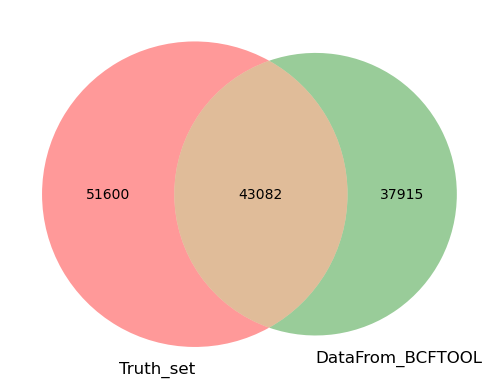

TP: 43082
TN: 132597
FP: 51600
FN: 37915
specificity: 0.719865144383459
sensitivity: 0.531896243070731
precision: 0.45501784922160493
Recall: 0.531896243070731
Accuracy: 0.662454655836859
F1_score: 0.49046271893624166


In [10]:
# Extract the column you want to compare
column_name = 'BCFTOOL'

# Get sets of values from each dataset
set1 = set(vcf_1[column_name])
set2 = set(df_1[column_name])

# Calculate the union and intersection of sets A and B
union_ab = set1.union(set2)
intersection_ab = set1.intersection(set2)

# Calculate the cardinality of sets A and B
n_a = len(set1)
n_b = len(set2)

# Create the Venn diagram
venn2([set1, set2], ('Truth_set', 'DataFrom_BCFTOOL'))

# Show the Venn diagram
plt.show()

# Calculate specificity and sensitivity

TP = len(intersection_ab)  # True Positives (A ∩ B)
FP = n_a - TP  # False Positives (n(A) - TP)
FN = n_b - TP  # False Negatives (n(B) - TP)
TN = FP + FN

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
Recall = TP / (TP + FN)
Accuracy = (TP + TN) / (TP + TN + FP + FN)
F1_score = 2*((precision*Recall)/(precision+Recall))

print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')
print(f'specificity: {specificity}')
print(f'sensitivity: {sensitivity}')
print(f'precision: {precision}')
print(f'Recall: {Recall}')
print(f'Accuracy: {Accuracy}')
print(f'F1_score: {F1_score}')

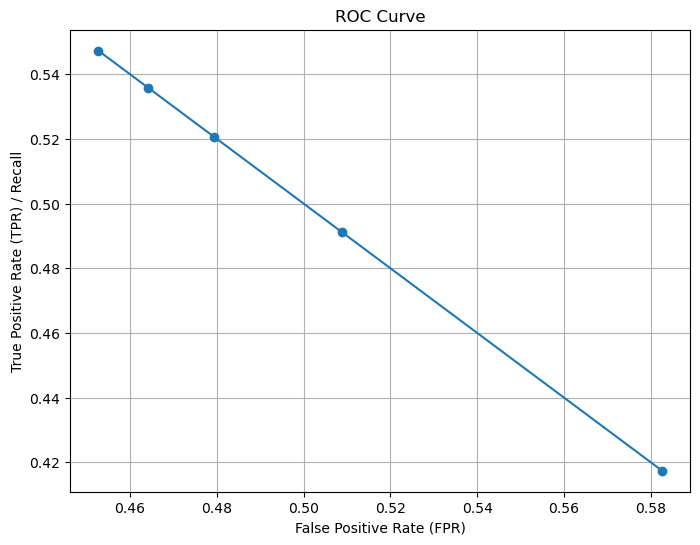

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with precision and recall values
data = {
    "Precision": [0.494793139, 0.495626102, 0.494318158, 0.494620161, 0.492986281],
    "Recall": [0.535753073, 0.54728181, 0.491248884, 0.520640038, 0.417369224],
}
df = pd.DataFrame(data)

# Sort the DataFrame by precision in descending order
df = df.sort_values(by="Precision", ascending=False)

# Calculate false positive rate (FPR) and true positive rate (TPR)
df["FPR"] = 1 - df["Recall"]

# Create an ROC curve
plt.figure(figsize=(8, 6))
plt.plot(df["FPR"], df["Recall"], marker='o', linestyle='-')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR) / Recall")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

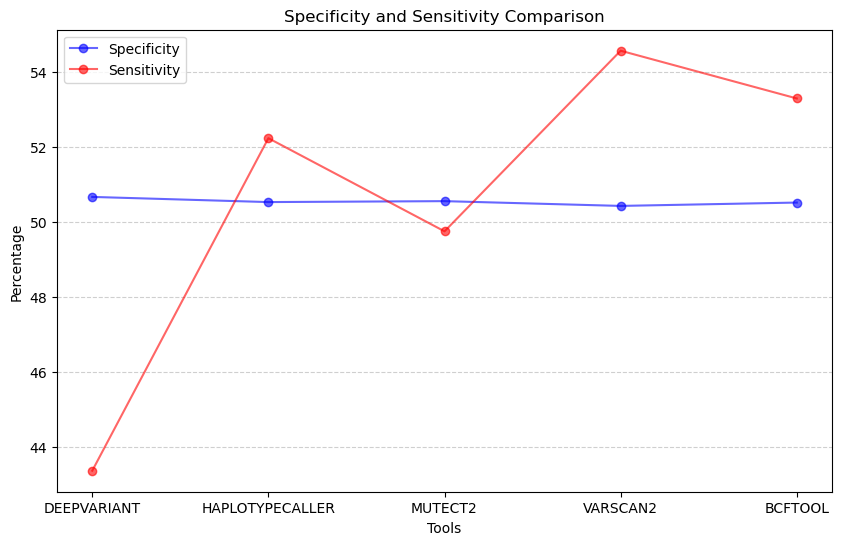

In [2]:
import matplotlib.pyplot as plt

# Data from the table
tools = ["DEEPVARIANT", "HAPLOTYPECALLER", "MUTECT2", "VARSCAN2", "BCFTOOL"]
specificity = [50.67402476, 50.53660943, 50.56142971, 50.43431101, 50.52369244]
sensitivity = [43.3765378, 52.23925993, 49.75665767, 54.57042326, 53.2982505]


# Create a figure
plt.figure(figsize=(10, 6))

# Plot a line for specificity
plt.plot(range(len(tools)), specificity, marker='o', label='Specificity', color='b', alpha=0.6)

# Plot a line for sensitivity
plt.plot(range(len(tools)), sensitivity, marker='o', label='Sensitivity', color='r', alpha=0.6)

# Add labels and a legend
plt.xticks(range(len(tools)), tools)
plt.xlabel('Tools')
plt.ylabel('Percentage')
plt.title('Specificity and Sensitivity Comparison')
plt.legend()

# Show the plot
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/all_spe_sen_samples_avg.svg', dpi=450, bbox_inches='tight')
plt.show()

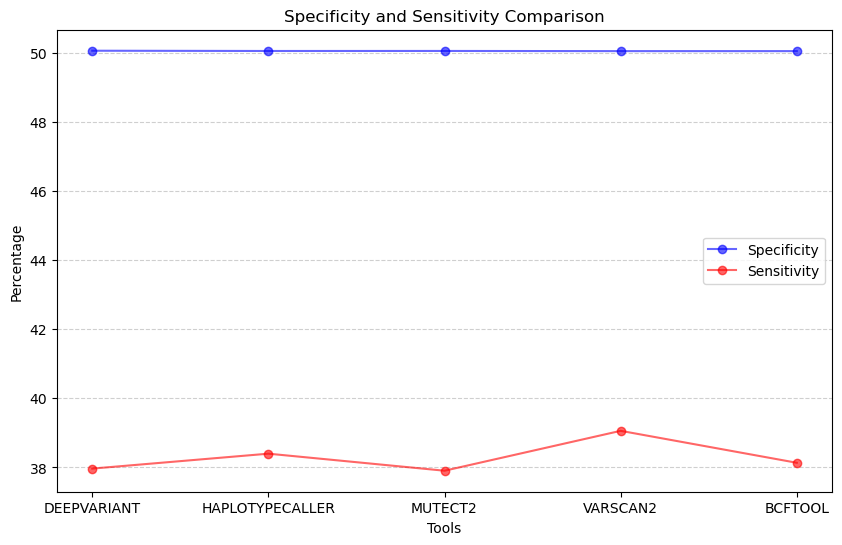

In [8]:
import matplotlib.pyplot as plt

# Data from the table
tools = ["DEEPVARIANT", "HAPLOTYPECALLER", "MUTECT2", "VARSCAN2", "BCFTOOL"]
specificity = [50.0568530281858, 50.0492188671698, 50.0502333063328, 50.0453654764166, 50.0453654764166]
sensitivity = [37.9651615045454, 38.3970076219185, 37.9037687565053, 39.0579870016644, 38.133612648072]


# Create a figure
plt.figure(figsize=(10, 6))

# Plot a line for specificity
plt.plot(range(len(tools)), specificity, marker='o', label='Specificity', color='b', alpha=0.6)

# Plot a line for sensitivity
plt.plot(range(len(tools)), sensitivity, marker='o', label='Sensitivity', color='r', alpha=0.6)

# Add labels and a legend
plt.xticks(range(len(tools)), tools)
plt.xlabel('Tools')
plt.ylabel('Percentage')
plt.title('Specificity and Sensitivity Comparison')
plt.legend()

# Show the plot
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Result/all_spe_sen_samples_0.001_avg.svg', dpi=450, bbox_inches='tight')
plt.show()

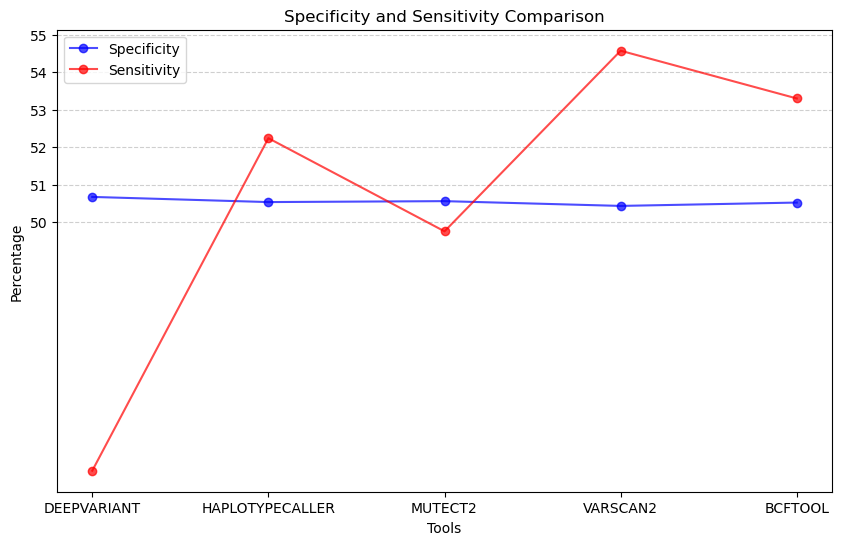

In [193]:
import matplotlib.pyplot as plt

# Data from the table
tools = ["DEEPVARIANT", "HAPLOTYPECALLER", "MUTECT2", "VARSCAN2", "BCFTOOL"]
specificity = [50.67402476, 50.53660943, 50.56142971, 50.43431101, 50.52369244]
sensitivity = [43.3765378, 52.23925993, 49.75665767, 54.57042326, 53.2982505]

# Create a figure
plt.figure(figsize=(10, 6))

# Plot a line for specificity
plt.plot(range(len(tools)), specificity, marker='o', label='Specificity', color='b', alpha=0.7)

# Plot a line for sensitivity
plt.plot(range(len(tools)), sensitivity, marker='o', label='Sensitivity', color='r', alpha=0.7)

# Set y-axis ticks for Specificity with a specified range and interval
y_ticks_specificity = range(50, 56, 1)  # Customize the range and interval as needed
plt.yticks(y_ticks_specificity)

# Add labels and a legend
plt.xticks(range(len(tools)), tools)
plt.xlabel('Tools')
plt.ylabel('Percentage')
plt.title('Specificity and Sensitivity Comparison')
plt.legend()

# Show the plot
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


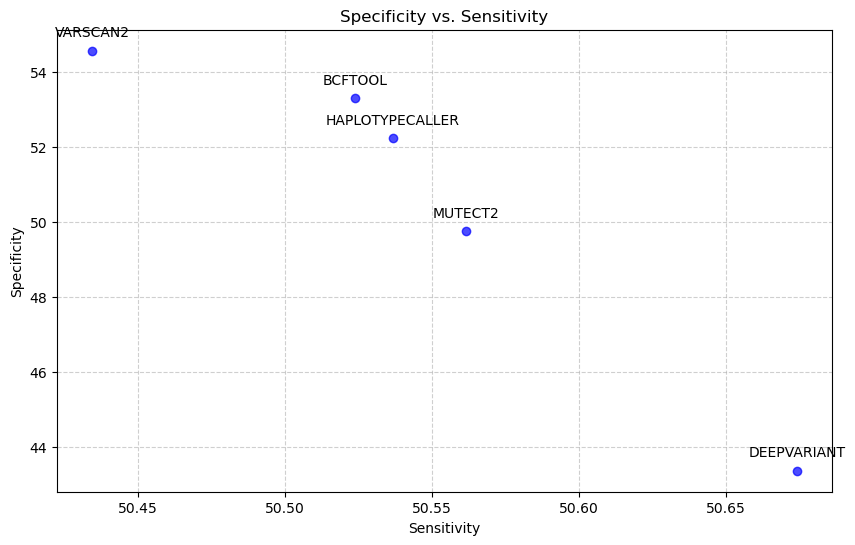

In [2]:
import matplotlib.pyplot as plt

# Data from the table
tools = ["DEEPVARIANT", "HAPLOTYPECALLER", "MUTECT2", "VARSCAN2", "BCFTOOL"]
specificity = [50.67402476, 50.53660943, 50.56142971, 50.43431101, 50.52369244]
sensitivity = [43.3765378, 52.23925993, 49.75665767, 54.57042326, 53.2982505]

# Create a figure
plt.figure(figsize=(10, 6))

# Plot specificity on the x-axis and sensitivity on the y-axis
plt.scatter(specificity, sensitivity, marker='o', color='b', alpha=0.7)

# Label each point with the corresponding tool
for i, tool in enumerate(tools):
    plt.annotate(tool, (specificity[i], sensitivity[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.title('Specificity vs. Sensitivity')
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/all_spe_sen_samples_both.svg', dpi=450, bbox_inches='tight')
plt.show()


In [93]:
#specificity = TN / (TN + FP)
#sensitivity = TP / (TP + FN)

specificity = 3932592 / (3932592 + 3893341)
sensitivity = 43628 / (43628 + 82879)
print(specificity)
print(sensitivity)

0.5025077521108345
0.3448662919838428


# Variants extraction

In [163]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_BCFTOOL.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf_new = vcf.apply(lambda row: '_'.join([str(row['CHROM']), str(row['POS']), str(row['REF']), str(row['ALT'])]), axis=1)
vcf_new = pd.DataFrame(vcf_new)
vcf_new.columns = ['BCFTOOL']
vcf_new.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705/12652712_BCFTOOL.xlsx', index=False)

In [164]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_VARSCAN2.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf_new = vcf.apply(lambda row: '_'.join([str(row['CHROM']), str(row['POS']), str(row['REF']), str(row['ALT'])]), axis=1)
vcf_new = pd.DataFrame(vcf_new)
vcf_new.columns = ['VARSCAN2']
vcf_new.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705/12652712_VARSCAN2.xlsx', index=False)

In [165]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_MUTECT2.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf_new = vcf.apply(lambda row: '_'.join([str(row['CHROM']), str(row['POS']), str(row['REF']), str(row['ALT'])]), axis=1)
vcf_new = pd.DataFrame(vcf_new)
vcf_new.columns = ['MUTECT2']
vcf_new.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705/12652712_MUTECT2.xlsx', index=False)

In [166]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_HAPLOTYPECALLER.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf_new = vcf.apply(lambda row: '_'.join([str(row['CHROM']), str(row['POS']), str(row['REF']), str(row['ALT'])]), axis=1)
vcf_new = pd.DataFrame(vcf_new)
vcf_new.columns = ['HAPLOTYPECALLER']
vcf_new.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705/12652712_HAPLOTYPECALLER.xlsx', index=False)

In [167]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_DEEPVARIANT.vcf', comment= '#', sep = '\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf = vcf[~vcf['ALT'].str.contains(',')]
vcf = vcf[vcf['QUAL'] >= 10]
vcf_new = vcf.apply(lambda row: '_'.join([str(row['CHROM']), str(row['POS']), str(row['REF']), str(row['ALT'])]), axis=1)
vcf_new = pd.DataFrame(vcf_new)
vcf_new.columns = ['DEEPVARIANT']
vcf_new.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652705/12652712_DEEPVARIANT.xlsx', index=False)

In [96]:
import pandas as pd

# Read the VCF file
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/truthset_output.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['BCFTOOL'] = vcf.apply(lambda row: '{}_{}_{}_{}'.format(row['CHROM'], row['POS'], row['REF'], row['ALT']), axis=1)
vcf_1 = vcf[['BCFTOOL']]

# Read the Excel file
df_1 = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652710/12652710_concordance_input.xlsx')

# Initialize lists to store specificity and sensitivity values
specificities = []
sensitivities = []

# Iterate through rows of df_1 and compare with vcf_1
for index, row in df_1.iterrows():
    column_name = 'BCFTOOL'  # The column to compare with in vcf_1
    set1 = set(vcf_1['BCFTOOL'])
    
    # Split the comma-separated values into a list and process each value
    values_to_compare = row[column_name].split(',')
    set2 = set([value.replace(r'_rs\d+_', '_').replace(r'_\._', '_') for value in values_to_compare if value])

    # Calculate the union and intersection of sets A and B
    union_ab = set1.union(set2)
    intersection_ab = set1.intersection(set2)

    # Calculate the cardinality of sets A and B
    n_a = len(set1)
    n_b = len(set2)

    # Calculate specificity and sensitivity
    TN = len(union_ab)  # True Negatives (A ∪ B)
    TP = len(intersection_ab)  # True Positives (A ∩ B)
    FP = n_a - TP  # False Positives (n(A) - TP)
    FN = n_b - TP  # False Negatives (n(B) - TP)

    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)

    specificities.append(specificity)
    sensitivities.append(sensitivity)

# Add specificity and sensitivity columns to df_1
df_1['Specificity'] = specificities
df_1['Sensitivity'] = sensitivities

# Display the DataFrame with added columns
df_1

KeyboardInterrupt: 

In [85]:
#specificity = TN / (TN + FP)
#sensitivity = TP / (TP + FN)

specificity = 3849740 / (3849740 + 3893341)
sensitivity = 43601 / (43601 + 83745)
print(specificity)
print(sensitivity)

0.49718451866898977
0.3423821714070328


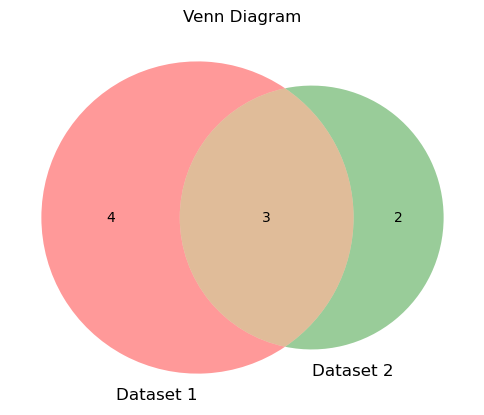

TP: 3
TN: 4
FP: 2
FN: 4


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Create example datasets
data1 = {
    "CHROM_POS_REF_ALT": ["1_100_A_T", "2_200_G_C", "3_300_T_A", "4_400_C_G", "5_500_A_T", "5_300_A_G", "8_400_A_T"],
}
data2 = {
    "CHROM_POS_REF_ALT": ["2_200_G_C", "4_400_C_G", "5_500_A_T", "6_600_T_G", "7_700_G_A"],
}

# Create dataframes
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Extract variants as lists
variants1 = list(df1['CHROM_POS_REF_ALT'])
variants2 = list(df2['CHROM_POS_REF_ALT'])

# Calculate TP, TN, FP, FN
TP = len([variant for variant in variants1 if variant in variants2])
TN = len([variant for variant in variants1 if variant not in variants2])
FP = len([variant for variant in variants2 if variant not in variants1])
FN = len([variant for variant in variants1 if variant not in variants2])

# Create the Venn diagram
plt.figure(figsize=(6, 6))
venn2(subsets=(TN, FP, TP), set_labels=("Dataset 1", "Dataset 2"))
plt.title("Venn Diagram")

# Show the Venn diagram
plt.show()

# Display TP, TN, FP, FN
print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')

In [27]:
# Example sets of genetic variants
actual_variants = vcf_1['BCFTOOLS']
predicted_variants = df_1['BCFTOOLS']

# Calculate True Positives (TP)
TP = len(actual_variants.intersection(predicted_variants))

# Calculate False Negatives (FN)
FN = len(actual_variants - predicted_variants)

# Calculate True Negatives (TN)
# In this context, TN represents variants that are not in either set, which can be the complement of the union of the sets.
TN = len(set() - (actual_variants.union(predicted_variants)))

# Calculate False Positives (FP)
# FP represents variants in predicted_variants but not in actual_variants.
FP = len(predicted_variants - actual_variants)

# Calculate Sensitivity (True Positive Rate or Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

# Display Sensitivity and Specificity
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

KeyError: 'BCFTOOLS'

In [14]:
specificity = 3849783 / (3849783 + 38263)
sensitivity = 43558 / (43558 + 3849783)
print(specificity)
print(sensitivity)

0.9901588098494719
0.011187820434942637


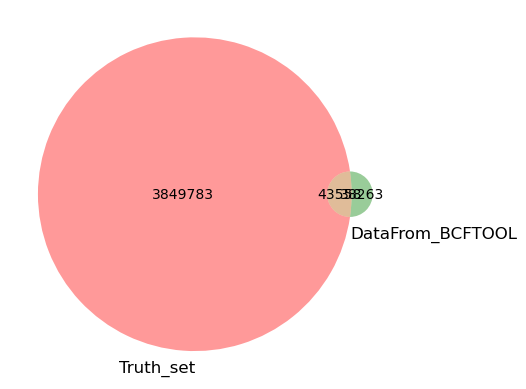

FP (n(A)): 3893341
FN (n(B)): 81821
TP (A ∩ B): 43558


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Extract the column you want to compare
column_name = 'BCFTOOL'

# Get sets of values from each dataset
set1 = set(vcf_1[column_name])
set2 = set(df_1[column_name])

# Calculate the union and intersection of sets A and B
union_ab = set1.union(set2)
intersection_ab = set1.intersection(set2)

# Calculate the cardinality of sets A and B
n_a = len(set1)
n_b = len(set2)

# Create the Venn diagram
venn2([set1, set2], ('Truth_set', 'DataFrom_BCFTOOL'))

# Show the Venn diagram
plt.show()

# Display the calculated values
print(f'FP (n(A)): {n_a}')
print(f'FN (n(B)): {n_b}')
print(f'Union of Set A and Set B (A ∪ B): {len(union_ab)}')
print(f'TP (A ∩ B): {len(intersection_ab)}')

In [11]:
TN = (3893341+81821) - (3893341+81821+43558)
TN

-43558

In [10]:
specificity = 3997496 / (3997496 + 3893341)
sensitivity = 43558 / (43558 + 81821)
print(specificity)
print(sensitivity)

0.5065997434746149
0.3474106509064516


In [ ]:
specificity = tn_count / (tn_count + fp_count)
sensitivity = tp_count / (tp_count + fn_count)


In [61]:
import pandas as pd

# Assuming you have two DataFrames vcf_1 and df_1
target_column = 'BCFTOOL'

# Merge the DataFrames on the 'DEEPVARIANT' column using an inner join
merged_df = pd.merge(vcf_1, df_1, on=target_column, how='inner')

# Count the number of TP (common rows)
tp_count = len(merged_df)

# Merge the DataFrames on the 'DEEPVARIANT' column using left and right joins
merged_left = pd.merge(vcf_1, df_1, on=target_column, how='left', indicator=True)
merged_right = pd.merge(vcf_1, df_1, on=target_column, how='right', indicator=True)

# Count the number of TN (exclusive to vcf_1), FP (exclusive to df_1), and FN (exclusive to vcf_2)
tn_count = len(merged_left[merged_left['_merge'] == 'left_only'])
fp_count = len(merged_right[merged_right['_merge'] == 'right_only'])
fn_count = len(merged_left[merged_left['_merge'] == 'right_only'])

# Print the counts for TP, TN, FP, and FN
print("True Positives (TP) count:", tp_count)
print("True Negatives (TN) count:", tn_count)
print("False Positives (FP) count:", fp_count)
print("False Negatives (FN) count:", fn_count)

True Positives (TP) count: 43558
True Negatives (TN) count: 3849783
False Positives (FP) count: 38263
False Negatives (FN) count: 0


In [62]:
specificity = tn_count / (tn_count + fp_count)
sensitivity = tp_count / (tp_count + fn_count)
print(specificity)
print(sensitivity)

0.9901588098494719
1.0


In [32]:
merged_df

DEEPVARIANT
0         chr1_817514_T_C
1         chr1_827209_G_C
2         chr1_827212_C_G
3         chr1_827221_T_C
4         chr1_827252_T_A
...                   ...
45125  chr22_50625559_G_C
45126  chr22_50625713_G_A
45127  chr22_50626390_T_C
45128  chr22_50695090_G_A
45129  chr22_50698821_T_C

[45130 rows x 1 columns]

In [23]:
duplicates_count = vcf_1.duplicated(subset=["new_column"]).sum()
duplicates_count

0

In [ ]:
truthset = pd.merge(vcf, dbsnp_sel, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'left', sort= False)
truthset

# ---------------------------------------------------------------------------------------------------------------

In [24]:
import pandas as pd

# Function to calculate specificity and sensitivity
def calculate_specificity_sensitivity(vcf_filename, truth_set_filename):
    # Read VCF and truth set files into pandas DataFrames
    vcf_df = pd.read_csv(vcf_filename, sep='\t', comment='#', header=None)
    truth_set_df = pd.read_csv(truth_set_filename, sep='\t', comment='#', header=None)

    # Set column names for clarity
    vcf_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    truth_set_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

    # Merge VCF and truth set DataFrames based on CHROM, POS, REF, and ALT
    merged_df = pd.merge(vcf_df, truth_set_df, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', indicator=True)

    # Calculate TP, FP, TN, and FN based on the merge indicator
    true_positives = (merged_df['_merge'] == 'both').sum()
    false_positives = (merged_df['_merge'] == 'left_only').sum()
    true_negatives = (merged_df['_merge'] == 'right_only').sum()
    false_negatives = 0  # Count false negatives separately

    # Calculate specificity and sensitivity
    specificity = true_negatives / (true_negatives + false_positives)
    sensitivity = true_positives / (true_positives + false_negatives)

    return specificity, sensitivity

# Example usage
vcf_file = r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/KHCDPRGPTTL14_final.vcf'
truth_set_file = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/KHCDPRGPTTL14/KHCDPRGPTTL14_final.vcf'

specificity, sensitivity = calculate_specificity_sensitivity(vcf_file, truth_set_file)
print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')

Specificity: nan
Sensitivity: 1.00


In [23]:
import pandas as pd

# Function to calculate specificity and sensitivity
def calculate_specificity_sensitivity(vcf_filename, truth_set_filename):
    # Read VCF files into Pandas DataFrames
    vcf_df = pd.read_csv(vcf_filename, sep='\t', comment='#', header=None)
    vcf_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

    truth_set_df = pd.read_csv(truth_set_filename, sep='\t', comment='#', header=None)
    truth_set_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    # Check for true positives and false positives
    for _, vcf_record in vcf_df.iterrows():
        in_truth_set = False
        for _, truth_set_record in truth_set_df.iterrows():
            if (
                vcf_record['CHROM'] == truth_set_record['CHROM']
                and vcf_record['POS'] == truth_set_record['POS']
                and vcf_record['REF'] == truth_set_record['REF']
                and vcf_record['ALT'] == truth_set_record['ALT']
            ):
                in_truth_set = True
                break

        if in_truth_set:
            true_positives += 1
        else:
            false_positives += 1

    # Count true negatives and false negatives
    for _, truth_set_record in truth_set_df.iterrows():
        in_vcf = False
        for _, vcf_record in vcf_df.iterrows():
            if (
                vcf_record['CHROM'] == truth_set_record['CHROM']
                and vcf_record['POS'] == truth_set_record['POS']
                and vcf_record['REF'] == truth_set_record['REF']
                and vcf_record['ALT'] == truth_set_record['ALT']
            ):
                in_vcf = True
                break

        if not in_vcf:
            false_negatives += 1
        else:
            true_negatives += 1

    specificity = true_negatives / (true_negatives + false_positives)
    sensitivity = true_positives / (true_positives + false_negatives)

    return specificity, sensitivity

# Example usage
vcf_file = r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/KHCDPRGPTTL14_final.vcf'
truth_set_file = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/KHCDPRGPTTL14/KHCDPRGPTTL14_final.vcf'

specificity, sensitivity = calculate_specificity_sensitivity(vcf_file, truth_set_file)
print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')

KeyboardInterrupt: 

In [27]:
import pandas as pd

# Function to calculate specificity and sensitivity
def calculate_specificity_sensitivity(vcf_filename, truth_set_filename):
    # Read VCF files into Pandas DataFrames
    vcf_df = pd.read_csv(vcf_filename, sep='\t', comment='#', header=None)
    vcf_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

    truth_set_df = pd.read_csv(truth_set_filename, sep='\t', comment='#', header=None)
    truth_set_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

    vcf_variants = set(vcf_df.apply(lambda row: (row['CHROM'], row['POS'], row['REF'], row['ALT']), axis=1))
    truth_set_variants = set(truth_set_df.apply(lambda row: (row['CHROM'], row['POS'], row['REF'], row['ALT']), axis=1))

    true_positives = len(vcf_variants.intersection(truth_set_variants))
    false_positives = len(vcf_variants.difference(truth_set_variants))
    false_negatives = len(truth_set_variants.difference(vcf_variants))

    total_non_variants = len(truth_set_df) - len(truth_set_variants)
    true_negatives = total_non_variants - false_positives

    # Avoid division by zero
    if true_negatives + false_positives == 0:
        specificity = 1.0
    else:
        specificity = true_negatives / (true_negatives + false_positives)

    sensitivity = true_positives / (true_positives + false_negatives)

    return specificity, sensitivity

# Example usage
vcf_file = r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/KHCDPRGPTTL14_final.vcf'
truth_set_file = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/KHCDPRGPTTL14/KHCDPRGPTTL14_final.vcf'

specificity, sensitivity = calculate_specificity_sensitivity(vcf_file, truth_set_file)
print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')

Specificity: 1.00
Sensitivity: 0.49


In [ ]:
import pandas as pd

# Function to calculate specificity and sensitivity for multiple VCF files
def calculate_specificity_sensitivity_for_multiple_files(vcf_filenames, truth_set_filename):
    specificity_scores = []
    sensitivity_scores = []

    # Read the truth set once since it's common for all tools
    truth_set_df = pd.read_csv(truth_set_filename, sep='\t', comment='#', header=None)
    truth_set_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    truth_set_variants = set(truth_set_df.apply(lambda row: (row['CHROM'], row['POS'], row['REF'], row['ALT']), axis=1))

    for vcf_filename in vcf_filenames:
        # Read the VCF file for the current tool
        vcf_df = pd.read_csv(vcf_filename, sep='\t', comment='#', header=None)
        vcf_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
        vcf_variants = set(vcf_df.apply(lambda row: (row['CHROM'], row['POS'], row['REF'], row['ALT']), axis=1))

        # Calculate specificity and sensitivity for the current tool
        true_positives = len(vcf_variants.intersection(truth_set_variants))
        false_positives = len(vcf_variants.difference(truth_set_variants))
        false_negatives = len(truth_set_variants.difference(vcf_variants))

        total_non_variants = len(truth_set_df) - len(truth_set_variants)
        true_negatives = total_non_variants - false_positives

        # Avoid division by zero
        if true_negatives + false_positives == 0:
            specificity = 1.0
        else:
            specificity = true_negatives / (true_negatives + false_positives)

        sensitivity = true_positives / (true_positives + false_negatives)

        specificity_scores.append(specificity)
        sensitivity_scores.append(sensitivity)

    return specificity_scores, sensitivity_scores

# Example usage with five VCF files and a common truth set
vcf_files = [
    'tool1_variant_calls.vcf',
    'tool2_variant_calls.vcf',
    'tool3_variant_calls.vcf',
    'tool4_variant_calls.vcf',
    'tool5_variant_calls.vcf'
]
truth_set_file = 'common_truth_set.vcf'

specificities, sensitivities = calculate_specificity_sensitivity_for_multiple_files(vcf_files, truth_set_file)

# Print the results for each tool
for i, vcf_file in enumerate(vcf_files):
    print(f'Tool {i + 1}:')
    print(f'Specificity: {specificities[i]:.2f}')
    print(f'Sensitivity: {sensitivities[i]:.2f}')
    print()

In [2]:
import pandas as pd

# Define paths to the reference genome file, known variants file (CSV), and truth set file (VCF)
reference_genome_file = "reference_genome.fasta"
known_variants_csv = "known_variants.csv"
truth_set_file = "truth_set.vcf"

# Read the known variants from a CSV file into a pandas DataFrame
known_variants_df = pd.read_csv(known_variants_csv)

# Function to extract sequences from the reference genome
def extract_sequence(chromosome, position, reference_genome_file):
    with open(reference_genome_file, 'r') as genome_file:
        for line in genome_file:
            if line.startswith(f">{chromosome}"):
                sequence = next(genome_file).strip()
                return sequence[position - 1:]

# Create a VCF file for the truth set
with open(truth_set_file, "w") as vcf_file:
    vcf_file.write("##fileformat=VCFv4.2\n")
    vcf_file.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\n")

    for index, row in known_variants_df.iterrows():
        chromosome = row["Chromosome"]
        position = row["Position"]
        ref_sequence = extract_sequence(chromosome, position, reference_genome_file)
        alt_sequence = row["Alternate"]
        
        vcf_record = f"{chromosome}\t{position}\t.\t{ref_sequence}\t{alt_sequence}\t.\t.\t.\n"
        vcf_file.write(vcf_record)

print("Truth set VCF file created successfully.")

FileNotFoundError: [Errno 2] No such file or directory: 'known_variants.csv'

In [10]:
pip install matplotlib matplotlib-venn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.9-py3-none-any.whl size=33037 sha256=2d8eff89c33e04f173757c07fa852a000ad139b276f993b95ad78fdd2d8d5eb6
  Stored in directory: c:\users\genepowerx_madhu\appdata\local\pip\cache\wheels\bd\e2\a0\b922199922d1c6d4c3a9827bdb66b6d8924bb7cfdc5378deb1
Successfully built matplotlib-venn
Note: you may need to restart the kernel to use updated packages.


# Data analysis from here

In [60]:
import pandas as pd
import os

# Define the list of VCF file names with Windows file paths
vcf_files = [
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_qual_filter_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_varscan_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_Mutect2_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_Haplotype_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_deep_variant_cov.vcf",
]

# Create a Pandas Excel writer
output_excel_file = r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/new_cutoff_unique_vcf_data.xlsx"
writer = pd.ExcelWriter(output_excel_file, engine="openpyxl")

# Function to sanitize sheet names
def sanitize_sheet_name(sheet_name):
    invalid_characters = ['\\', '/', '?', '*', '[', ']', ':']
    for char in invalid_characters:
        sheet_name = sheet_name.replace(char, '_')
    return sheet_name

# Iterate through each VCF file
for vcf_file in vcf_files:
    # Read the VCF file into a DataFrame
    vcf_data = pd.read_csv(vcf_file, sep="\t", header=None, comment="#")

    # Determine the number of columns in the DataFrame
    num_columns = len(vcf_data.columns)

    # Generate column names based on the number of columns
    column_names = [f"COL{i}" for i in range(1, num_columns + 1)]

    # Assign the generated column names to the DataFrame
    vcf_data.columns = column_names

    # Extract relevant columns (CHROM, POS, REF, ALT, ID, INFO, SAMPLE)
    vcf_data = vcf_data.iloc[:, 0:10]
    vcf_data.columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMPLE"]

    # Include your existing code for data processing here (replace this comment)
    vcf_data['DP'] = vcf_data['INFO'].str.extract(r'DP=(\d+)')[0]
    vcf_data['DP'] = vcf_data['DP'].fillna(0)  # Replace NaN with 0 for missing 'DP' values
    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'Unknown'
    vcf_data['Zygosity'] = vcf_data['SAMPLE'].apply(map_genotype)
    vcf_data = vcf_data[vcf_data['DP'].astype(int) >= 10]

    # Sanitize the sheet name
    sheet_name = sanitize_sheet_name(os.path.splitext(os.path.basename(vcf_file))[0])

    # Find unique rows based on all columns
    unique_vcf_data = vcf_data.drop_duplicates(subset=["CHROM", "POS", "ID", "REF", "ALT"])

    # Write the unique data to a new sheet in the Excel file
    unique_vcf_data.to_excel(writer, sheet_name=sheet_name, index=False)

# Save the Excel file
writer.save()

# Close the Pandas Excel writer
writer.close()

print(f"Unique data extracted and saved to '{output_excel_file}'")

Unique data extracted and saved to 'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/new_cutoff_unique_vcf_data.xlsx'


In [65]:
import pandas as pd
import os

# Define a function to process a VCF file and save it to an Excel sheet
def process_vcf_file(file_path, output_directory):
    vcf = pd.read_csv(file_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

    # Extract DP values, replacing NaN with 0
    vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)

    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'Unknown'

    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    vcf = vcf[vcf['DP'] >= 10]

    # Extract the file name without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # Save the processed DataFrame to an Excel file with a sheet named after the file name
    excel_file_path = os.path.join(output_directory, f'{file_name}.xlsx')
    
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)
    
    with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
        vcf.to_excel(writer, sheet_name=file_name, index=False)

# Directory containing your VCF files
vcf_directory = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/'

# Output directory
output_directory = vcf_directory  # Use the same directory as VCF files

# List all VCF files in the directory
vcf_files = [os.path.join(vcf_directory, file) for file in os.listdir(vcf_directory) if file.endswith('.vcf')]

# Process each VCF file and save it to the Excel file
for file in vcf_files:
    process_vcf_file(file, output_directory)

In [75]:
import pandas as pd
import os

# Define a function to extract DP value from INFO or SAMPLE column
def extract_dp(row):
    info_dp_match = re.search(r'DP=(\d+)', row['INFO'])
    sample_dp_match = re.search(r'DP=(\d+)', row['SAMPLE'])
    
    if info_dp_match:
        return int(info_dp_match.group(1))
    elif sample_dp_match:
        return int(sample_dp_match.group(1))
    else:
        return 0

# Define a function to process a VCF file and save it to an Excel sheet
def process_vcf_file(file_path, output_directory):
    vcf = pd.read_csv(file_path, comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

    # Extract DP values using the extract_dp function
    vcf['DP'] = vcf.apply(extract_dp, axis=1)

    def map_genotype(value):
        if '1/1' in value:
            return 'HOM'
        elif '0/1' in value:
            return 'HET'
        else:
            return 'Unknown'

    vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
    
    # Save the processed DataFrame to an Excel file with a sheet named after the file name
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    excel_file_path = os.path.join(output_directory, f'{file_name}_new.xlsx')
    
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)
    
    with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
        vcf.to_excel(writer, sheet_name=file_name, index=False)

# Directory containing your VCF files
vcf_directory = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/'

# Output directory
output_directory = vcf_directory  # Use the same directory as VCF files

# List all VCF files in the directory
vcf_files = [os.path.join(vcf_directory, file) for file in os.listdir(vcf_directory) if file.endswith('.vcf')]

# Process each VCF file and save it to the Excel file
for file in vcf_files:
    process_vcf_file(file, output_directory)

KeyboardInterrupt: 

In [100]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712_Mutect2_cov.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf

CHROM        POS                    rsID REF         ALT QUAL  \
0      chr1     817416             rs148649543   C           T    .   
1      chr1     930314               rs9988179   C           T    .   
2      chr1     930939               rs9988021   G           A    .   
3      chr1     931131  rs375757231;rs60722469   C       CCCCT    .   
4      chr1     935835              rs28419423   C           G    .   
...     ...        ...                     ...  ..         ...  ...   
99060  chrX  155228363             rs781912204   A      AT,ATT    .   
99061  chrX  155277884                rs559165   G           T    .   
99062  chrX  155545002               rs2305517   G           A    .   
99063  chrX  155545046               rs2305518   C           T    .   
99064  chrY   22314489                       .   T  TGATGCGTGG    .   

              FILTER                                               INFO  \
0               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=49,11|16,9;DP...   
1               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=11,20|14,22;D...   
2               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=0,0|35,12;DP=...   
3           slippage  AS_FilterStatus=SITE;AS_SB_TABLE=3,6|2,5;DP=28...   
4               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=5,16|7,10;DP=...   
...              ...                                                ...   
99060   multiallelic  AS_FilterStatus=SITE|weak_evidence;AS_SB_TABLE...   
99061           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=19,10|28,18;D...   
99062           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=21,7|19,4;DP=...   
99063           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=30,11|25,9;DP...   
99064  weak_evidence  AS_FilterStatus=weak_evidence;AS_SB_TABLE=0,0|...   

                         FORMAT  \
0      GT:AD:AF:DP:F1R2:F2R1:SB   
1      GT:AD:AF:DP:F1R2:F2R1:SB   
2      GT:AD:AF:DP:F1R2:F2R1:SB   
3      GT:AD:AF:DP:F1R2:F2R1:SB   
4      GT:AD:AF:DP:F1R2:F2R1:SB   
...                         ...   
99060  GT:AD:AF:DP:F1R2:F2R1:SB   
99061  GT:AD:AF:DP:F1R2:F2R1:SB   
99062  GT:AD:AF:DP:F1R2:F2R1:SB   
99063  GT:AD:AF:DP:F1R2:F2R1:SB   
99064  GT:AD:AF:DP:F1R2:F2R1:SB   

                                                  SAMPLE  
0              0/1:60,25:0.296:85:25,14:34,10:49,11,16,9  
1             0/1:31,36:0.531:67:15,17:16,19:11,20,14,22  
2                  0/1:0,47:0.978:47:0,14:0,32:0,0,35,12  
3                       0/1:9,7:0.463:16:5,3:4,4:3,6,2,5  
4                  0/1:21,17:0.435:38:4,9:16,7:5,16,7,10  
...                                                  ...  
99060  0/1/2:27,20,5:0.413,0.106:52:12,10,3:14,10,1:2...  
99061          0/1:29,46:0.608:75:8,19:20,27:19,10,28,18  
99062            0/1:28,23:0.438:51:7,11:20,12:21,7,19,4  
99063          0/1:41,34:0.443:75:11,17:30,17:30,11,25,9  
99064                    0/1:0,1:0.667:1:0,1:0,0:0,0,1,0  

[99065 rows x 10 columns]

In [101]:
#vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2]
# Define a function to map the values
def map_genotype(value):
    if '1/1' in value:
        return 'HOM'
    elif '0/1' in value:
        return 'HET'
    else:
        return 'HET'

# Apply the function to create a new column
vcf['Zygosity'] = vcf['SAMPLE'].apply(map_genotype)
vcf

CHROM        POS                    rsID REF         ALT QUAL  \
0      chr1     817416             rs148649543   C           T    .   
1      chr1     930314               rs9988179   C           T    .   
2      chr1     930939               rs9988021   G           A    .   
3      chr1     931131  rs375757231;rs60722469   C       CCCCT    .   
4      chr1     935835              rs28419423   C           G    .   
...     ...        ...                     ...  ..         ...  ...   
99060  chrX  155228363             rs781912204   A      AT,ATT    .   
99061  chrX  155277884                rs559165   G           T    .   
99062  chrX  155545002               rs2305517   G           A    .   
99063  chrX  155545046               rs2305518   C           T    .   
99064  chrY   22314489                       .   T  TGATGCGTGG    .   

              FILTER                                               INFO  \
0               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=49,11|16,9;DP...   
1               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=11,20|14,22;D...   
2               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=0,0|35,12;DP=...   
3           slippage  AS_FilterStatus=SITE;AS_SB_TABLE=3,6|2,5;DP=28...   
4               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=5,16|7,10;DP=...   
...              ...                                                ...   
99060   multiallelic  AS_FilterStatus=SITE|weak_evidence;AS_SB_TABLE...   
99061           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=19,10|28,18;D...   
99062           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=21,7|19,4;DP=...   
99063           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=30,11|25,9;DP...   
99064  weak_evidence  AS_FilterStatus=weak_evidence;AS_SB_TABLE=0,0|...   

                         FORMAT  \
0      GT:AD:AF:DP:F1R2:F2R1:SB   
1      GT:AD:AF:DP:F1R2:F2R1:SB   
2      GT:AD:AF:DP:F1R2:F2R1:SB   
3      GT:AD:AF:DP:F1R2:F2R1:SB   
4      GT:AD:AF:DP:F1R2:F2R1:SB   
...                         ...   
99060  GT:AD:AF:DP:F1R2:F2R1:SB   
99061  GT:AD:AF:DP:F1R2:F2R1:SB   
99062  GT:AD:AF:DP:F1R2:F2R1:SB   
99063  GT:AD:AF:DP:F1R2:F2R1:SB   
99064  GT:AD:AF:DP:F1R2:F2R1:SB   

                                                  SAMPLE           DP Zygosity  
0              0/1:60,25:0.296:85:25,14:34,10:49,11,16,9        0.296      HET  
1             0/1:31,36:0.531:67:15,17:16,19:11,20,14,22        0.531      HET  
2                  0/1:0,47:0.978:47:0,14:0,32:0,0,35,12        0.978      HET  
3                       0/1:9,7:0.463:16:5,3:4,4:3,6,2,5        0.463      HET  
4                  0/1:21,17:0.435:38:4,9:16,7:5,16,7,10        0.435      HET  
...                                                  ...          ...      ...  
99060  0/1/2:27,20,5:0.413,0.106:52:12,10,3:14,10,1:2...  0.413,0.106      HET  
99061          0/1:29,46:0.608:75:8,19:20,27:19,10,28,18        0.608      HET  
99062            0/1:28,23:0.438:51:7,11:20,12:21,7,19,4        0.438      HET  
99063          0/1:41,34:0.443:75:11,17:30,17:30,11,25,9        0.443      HET  
99064                    0/1:0,1:0.667:1:0,1:0,0:0,0,1,0        0.667      HET  

[99065 rows x 12 columns]

In [103]:
vcf['GT'] = vcf['SAMPLE'].str.split(':').str[0]
vcf

CHROM        POS                    rsID REF         ALT QUAL  \
0      chr1     817416             rs148649543   C           T    .   
1      chr1     930314               rs9988179   C           T    .   
2      chr1     930939               rs9988021   G           A    .   
3      chr1     931131  rs375757231;rs60722469   C       CCCCT    .   
4      chr1     935835              rs28419423   C           G    .   
...     ...        ...                     ...  ..         ...  ...   
99060  chrX  155228363             rs781912204   A      AT,ATT    .   
99061  chrX  155277884                rs559165   G           T    .   
99062  chrX  155545002               rs2305517   G           A    .   
99063  chrX  155545046               rs2305518   C           T    .   
99064  chrY   22314489                       .   T  TGATGCGTGG    .   

              FILTER                                               INFO  \
0               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=49,11|16,9;DP...   
1               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=11,20|14,22;D...   
2               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=0,0|35,12;DP=...   
3           slippage  AS_FilterStatus=SITE;AS_SB_TABLE=3,6|2,5;DP=28...   
4               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=5,16|7,10;DP=...   
...              ...                                                ...   
99060   multiallelic  AS_FilterStatus=SITE|weak_evidence;AS_SB_TABLE...   
99061           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=19,10|28,18;D...   
99062           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=21,7|19,4;DP=...   
99063           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=30,11|25,9;DP...   
99064  weak_evidence  AS_FilterStatus=weak_evidence;AS_SB_TABLE=0,0|...   

                         FORMAT  \
0      GT:AD:AF:DP:F1R2:F2R1:SB   
1      GT:AD:AF:DP:F1R2:F2R1:SB   
2      GT:AD:AF:DP:F1R2:F2R1:SB   
3      GT:AD:AF:DP:F1R2:F2R1:SB   
4      GT:AD:AF:DP:F1R2:F2R1:SB   
...                         ...   
99060  GT:AD:AF:DP:F1R2:F2R1:SB   
99061  GT:AD:AF:DP:F1R2:F2R1:SB   
99062  GT:AD:AF:DP:F1R2:F2R1:SB   
99063  GT:AD:AF:DP:F1R2:F2R1:SB   
99064  GT:AD:AF:DP:F1R2:F2R1:SB   

                                                  SAMPLE           DP  \
0              0/1:60,25:0.296:85:25,14:34,10:49,11,16,9        0.296   
1             0/1:31,36:0.531:67:15,17:16,19:11,20,14,22        0.531   
2                  0/1:0,47:0.978:47:0,14:0,32:0,0,35,12        0.978   
3                       0/1:9,7:0.463:16:5,3:4,4:3,6,2,5        0.463   
4                  0/1:21,17:0.435:38:4,9:16,7:5,16,7,10        0.435   
...                                                  ...          ...   
99060  0/1/2:27,20,5:0.413,0.106:52:12,10,3:14,10,1:2...  0.413,0.106   
99061          0/1:29,46:0.608:75:8,19:20,27:19,10,28,18        0.608   
99062            0/1:28,23:0.438:51:7,11:20,12:21,7,19,4        0.438   
99063          0/1:41,34:0.443:75:11,17:30,17:30,11,25,9        0.443   
99064                    0/1:0,1:0.667:1:0,1:0,0:0,0,1,0        0.667   

      Zygosity     GT  
0          HET    0/1  
1          HET    0/1  
2          HET    0/1  
3          HET    0/1  
4          HET    0/1  
...        ...    ...  
99060      HET  0/1/2  
99061      HET    0/1  
99062      HET    0/1  
99063      HET    0/1  
99064      HET    0/1  

[99065 rows x 13 columns]

In [104]:
vcf.GT.value_counts()

0/1              87688
0|1               8601
0/1/2             1781
1|0                586
0/1/2/3            340
0/1/2/3/4           56
0/1/2/3/4/5         11
0/1/2/3/4/5/6        2
Name: GT, dtype: int64

In [105]:
vcf[vcf['GT'] == '0/1/2/3/4/5/6']

CHROM        POS          rsID        REF  \
74505  chr4  154826739  rs1429139024    CTTTTTT   
97831  chrX   49694021  rs1331965396  GACACACAC   

                                                 ALT QUAL        FILTER  \
74505                     C,CT,CTT,CTTT,CTTTT,CTTTTT    .  multiallelic   
97831  G,GAC,GACAC,GACACAC,GACACACACAC,GACACACACACAC    .  multiallelic   

                                                    INFO  \
74505  AS_FilterStatus=weak_evidence|weak_evidence|SI...   
97831  AS_FilterStatus=weak_evidence|SITE|SITE|weak_e...   

                         FORMAT  \
74505  GT:AD:AF:DP:F1R2:F2R1:SB   
97831  GT:AD:AF:DP:F1R2:F2R1:SB   

                                                  SAMPLE  \
74505  0/1/2/3/4/5/6:3,5,5,13,35,19,19:0.035,0.048,0....   
97831  0/1/2/3/4/5/6:8,9,25,46,5,23,35:0.049,0.127,0....   

                                        DP Zygosity             GT  
74505  0.035,0.048,0.121,0.319,0.166,0.267      HET  0/1/2/3/4/5/6  
97831  0.049,0.127,0.266,0.036,0.193,0.271      HET  0/1/2/3/4/5/6

In [96]:
unique_vcf_data = vcf.drop_duplicates(subset=["CHROM", "POS", "rsID", "REF", "ALT"])

In [97]:
unique_vcf_data = unique_vcf_data[unique_vcf_data['DP'].astype(int) >= 10]
unique_vcf_data

CHROM        POS         rsID  \
0      chr1     817514    rs3131971   
1      chr1     930939    rs9988021   
2      chr1     935662  rs199537431   
3      chr1     939398  rs568340123   
4      chr1     941119    rs4372192   
...     ...        ...          ...   
91852  chrX  154781346  rs782421732   
91853  chrX  154784234    rs5945238   
91854  chrX  154901948    rs4074307   
91855  chrX  154903815    rs4898352   
91856  chrX  154929926    rs1800292   

                                                     REF ALT     QUAL FILTER  \
0                                                      T   C  1081.06   PASS   
1                                                      G   A  1907.06   PASS   
2                                                      C  CA   856.60   PASS   
3      GCCTCCCCAGCCACGGTGAGGACCCACCCTGGCATGATCCCCCTCATCA   G   539.60   PASS   
4                                                      A   G   765.06   PASS   
...                                                  ...  ..      ...    ...   
91852                                                  G   C   410.64   PASS   
91853                                                  C   T   937.06   PASS   
91854                                                  A   G   128.64   PASS   
91855                                                  A   T   450.64   PASS   
91856                                                  T   G  1092.64   PASS   

                                                    INFO          FORMAT  \
0      AC=2;AF=1.00;AN=2;BaseQRankSum=1.222;DB;DP=44;...  GT:AD:DP:GQ:PL   
1      AC=2;AF=1.00;AN=2;DB;DP=60;ExcessHet=3.0103;FS...  GT:AD:DP:GQ:PL   
2      AC=1;AF=0.500;AN=2;BaseQRankSum=-0.682;DB;DP=5...  GT:AD:DP:GQ:PL   
3      AC=1;AF=0.500;AN=2;BaseQRankSum=0.926;DP=108;E...  GT:AD:DP:GQ:PL   
4      AC=2;AF=1.00;AN=2;DB;DP=25;ExcessHet=3.0103;FS...  GT:AD:DP:GQ:PL   
...                                                  ...             ...   
91852  AC=1;AF=0.500;AN=2;BaseQRankSum=-3.613;DP=36;E...  GT:AD:DP:GQ:PL   
91853  AC=2;AF=1.00;AN=2;DB;DP=28;ExcessHet=3.0103;FS...  GT:AD:DP:GQ:PL   
91854  AC=1;AF=0.500;AN=2;BaseQRankSum=3.340;DB;DP=19...  GT:AD:DP:GQ:PL   
91855  AC=1;AF=0.500;AN=2;BaseQRankSum=-1.669;DB;DP=4...  GT:AD:DP:GQ:PL   
91856  AC=1;AF=0.500;AN=2;BaseQRankSum=4.243;DB;DP=80...  GT:AD:DP:GQ:PL   

                            SAMPLE  DP Zygosity  
0         1/1:1,40:41:96:1095,96,0  41      HOM  
1        1/1:0,57:57:99:1921,171,0  57      HOM  
2        0/1:19,27:46:99:864,0,573  46      HET  
3       0/1:50,18:68:99:547,0,1858  68      HET  
4          1/1:0,23:23:69:779,69,0  23      HOM  
...                            ...  ..      ...  
91852    0/1:14,21:35:99:418,0,365  35      HET  
91853      1/1:0,27:27:81:951,81,0  27      HOM  
91854     0/1:13,5:18:99:136,0,395  18      HET  
91855    0/1:26,17:43:99:458,0,782  43      HET  
91856  0/1:41,38:79:99:1100,0,1141  79      HET  

[83445 rows x 12 columns]

In [98]:
unique_vcf_data = unique_vcf_data[['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'DP', 'Zygosity']]
unique_vcf_data.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652705_Haplotype_cov.xlsx', index=False)

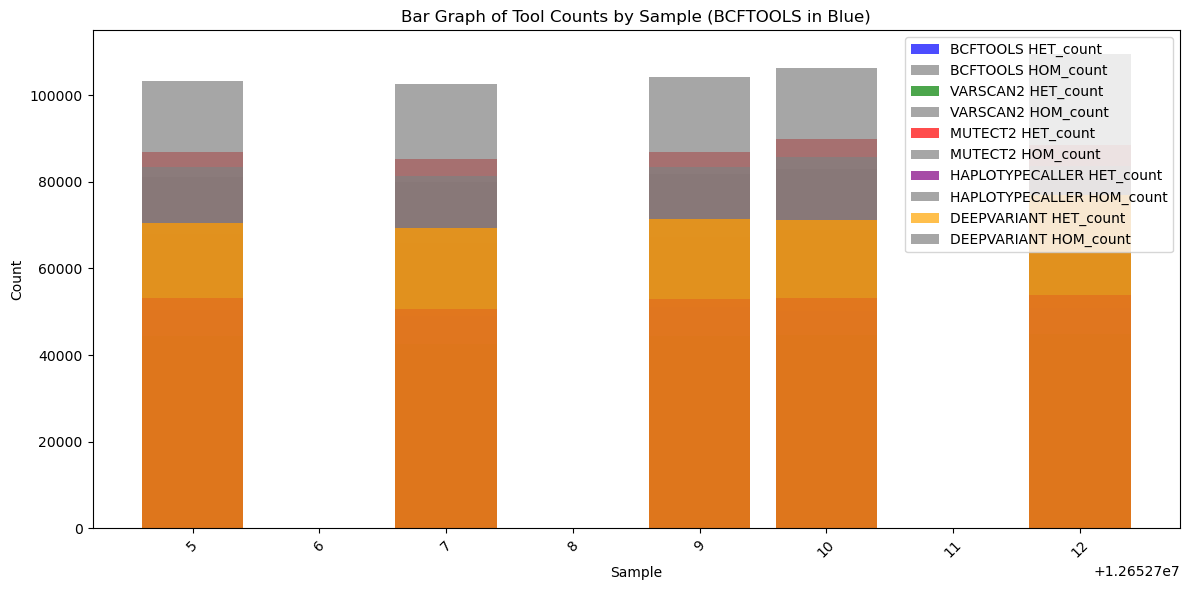

In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a DataFrame from your data
data = {
    "Sample": [12652712, 12652712, 12652712, 12652712, 12652712, 12652710, 12652710, 12652710, 12652710, 12652710, 12652709, 12652709, 12652709, 12652709, 12652709, 12652707, 12652707, 12652707, 12652707, 12652707, 12652705, 12652705, 12652705, 12652705, 12652705],
    "Tool": ["BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT", "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT", "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT", "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT", "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT"],
    "HET_count": [50922, 44899, 88503, 53892, 76966, 50136, 44631, 89758, 53203, 71133, 51198, 44351, 86781, 52940, 71351, 48927, 42539, 85197, 50561, 69311, 50468, 44437, 86955, 53101, 70499],
    "HOM_count": [30106, 23161, 0, 29853, 32515, 32743, 24262, 0, 32539, 35107, 30623, 22844, 0, 30395, 32804, 31057, 23234, 0, 30814, 33270, 30529, 23559, 0, 30344, 32831]
}

df = pd.DataFrame(data)

# Create a list of unique tools
unique_tools = df['Tool'].unique()

# Define custom colors for each tool
tool_colors = {
    "BCFTOOLS": 'blue',
    "VARSCAN2": 'green',
    "MUTECT2": 'red',
    "HAPLOTYPECALLER": 'purple',
    "DEEPVARIANT": 'orange'
}

# Create a bar graph with custom colors
fig, ax = plt.subplots(figsize=(12, 6))

for tool in unique_tools:
    tool_data = df[df['Tool'] == tool]
    het_counts = tool_data['HET_count']
    hom_counts = tool_data['HOM_count']
    samples = tool_data['Sample']

    # Define the colors for HET_count and HOM_count based on the tool
    het_color = tool_colors[tool]
    hom_color = 'gray'  # You can change this to a different color for HOM_count if needed

    ax.bar(samples, het_counts, color=het_color, label=f'{tool} HET_count', alpha=0.7)
    ax.bar(samples, hom_counts, bottom=het_counts, color=hom_color, label=f'{tool} HOM_count', alpha=0.7)

# Set labels and title
ax.set_xlabel('Sample')
ax.set_ylabel('Count')
ax.set_title('Bar Graph of Tool Counts by Sample (BCFTOOLS in Blue)')
ax.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import os

# Define the list of VCF file names with Windows file paths
vcf_files = [
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_qual_filter_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_varscan_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_Mutect2_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_Haplotype_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/12652705_deep_variant_cov.vcf",
]

# Create a Pandas Excel writer
output_excel_file = r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/unique_vcf_data.xlsx"
writer = pd.ExcelWriter(output_excel_file, engine="openpyxl")

# Function to sanitize sheet names
def sanitize_sheet_name(sheet_name):
    invalid_characters = ['\\', '/', '?', '*', '[', ']', ':']
    for char in invalid_characters:
        sheet_name = sheet_name.replace(char, '_')
    return sheet_name

# Iterate through each VCF file
for vcf_file in vcf_files:
    # Read the VCF file into a DataFrame
    vcf_data = pd.read_csv(vcf_file, sep="\t", header=None, comment="#")
    
    # Extract relevant columns (CHROM, POS, REF, ALT, ID)
    vcf_data = vcf_data.iloc[:, 0:5]
    vcf_data.columns = ["CHROM", "POS", "ID", "REF", "ALT"]
    
    # Find unique rows based on all columns
    unique_vcf_data = vcf_data.drop_duplicates()
    
    # Sanitize the sheet name
    sheet_name = sanitize_sheet_name(os.path.splitext(os.path.basename(vcf_file))[0])
    
    # Write the unique data to a new sheet in the Excel file
    unique_vcf_data.to_excel(writer, sheet_name=sheet_name, index=False)

# Save the Excel file
writer.save()

# Close the Pandas Excel writer
writer.close()

print(f"Unique data extracted and saved to '{output_excel_file}'")

Unique data extracted and saved to 'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/unique_vcf_data.xlsx'


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Step 1: Read the Excel file into a dictionary of DataFrames
excel_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Variants_all_files/12652712_unique_vcf_data.xlsx'
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names
dataframes = {sheet_name: xls.parse(sheet_name) for sheet_name in sheet_names}

# Step 2 and 3: Extract values from the concatenate column and create Venn diagrams
for sheet_name, df in dataframes.items():
    if 'concatinate' not in df.columns:
        print(f"Skipping sheet '{sheet_name}' as it doesn't contain a 'concatinate'.")
        continue
    
    concatenate_column_values = set(df['concatinate'])
    
    # Create Venn diagrams
    if sheet_name == sheet_names[0]:
        venn = venn2([concatenate_column_values], set_labels=[sheet_name])
    else:
        venn = venn2([venn.sets, concatenate_column_values], set_labels=[sheet_names[0], sheet_name])

    plt.title(f'Venn Diagram for {sheet_name}')
    plt.show()

TypeError: bad operand type for abs(): 'set'

In [26]:
pip install matplotlib-venn

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712_concat_columns_5_vcf.xlsx')

column1_values = df['qual_filter']
column2_values = df['varscan']
column3_values = df['Mutect2']
column4_values = df['Haplotype']
column5_values = df['deep_variant']

venn = venn3([column1_values, column2_values, column3_values, column4_values, column5_values], 
             set_labels=('qual_filter', 'varscan', 'Mutect2', 'Haplotype', 'deep_variant'))

plt.title("Venn Diagram for 12652712")
plt.show()

TypeError: bad operand type for abs(): 'str'

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
data = {
    "Sample": [12652712, 12652712, 12652712, 12652712, 12652712,
               12652710, 12652710, 12652710, 12652710, 12652710,
               12652709, 12652709, 12652709, 12652709, 12652709,
               12652707, 12652707, 12652707, 12652707, 12652707,
               12652705, 12652705, 12652705, 12652705, 12652705],
    "Tool": ["BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT"],
    "HET_count": [50922, 44899, 88503, 53892, 76966,
                  50136, 44631, 89758, 53203, 71133,
                  51198, 44351, 86781, 52940, 71351,
                  48927, 42539, 85197, 50561, 69311,
                  50468, 44437, 86955, 53101, 70499],
    "HOM_count": [30106, 23161, 0, 29853, 32515,
                  32743, 24262, 0, 32539, 35107,
                  30623, 22844, 0, 30395, 32804,
                  31057, 23234, 0, 30814, 33270,
                  30529, 23559, 0, 30344, 32831]
}

df = pd.DataFrame(data)
df

Sample             Tool  HET_count  HOM_count
0   12652712         BCFTOOLS      50922      30106
1   12652712         VARSCAN2      44899      23161
2   12652712          MUTECT2      88503          0
3   12652712  HAPLOTYPECALLER      53892      29853
4   12652712      DEEPVARIANT      76966      32515
5   12652710         BCFTOOLS      50136      32743
6   12652710         VARSCAN2      44631      24262
7   12652710          MUTECT2      89758          0
8   12652710  HAPLOTYPECALLER      53203      32539
9   12652710      DEEPVARIANT      71133      35107
10  12652709         BCFTOOLS      51198      30623
11  12652709         VARSCAN2      44351      22844
12  12652709          MUTECT2      86781          0
13  12652709  HAPLOTYPECALLER      52940      30395
14  12652709      DEEPVARIANT      71351      32804
15  12652707         BCFTOOLS      48927      31057
16  12652707         VARSCAN2      42539      23234
17  12652707          MUTECT2      85197          0
18  12652707  HAPLOTYPECALLER      50561      30814
19  12652707      DEEPVARIANT      69311      33270
20  12652705         BCFTOOLS      50468      30529
21  12652705         VARSCAN2      44437      23559
22  12652705          MUTECT2      86955          0
23  12652705  HAPLOTYPECALLER      53101      30344
24  12652705      DEEPVARIANT      70499      32831

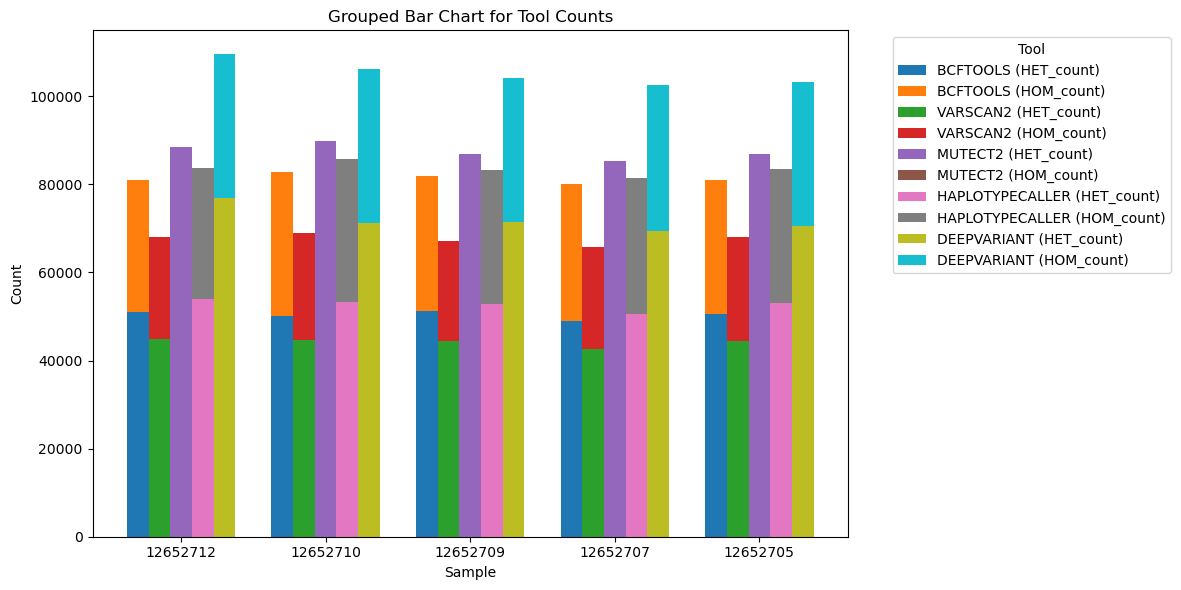

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your data
data = {
    "Sample": [12652712, 12652712, 12652712, 12652712, 12652712,
               12652710, 12652710, 12652710, 12652710, 12652710,
               12652709, 12652709, 12652709, 12652709, 12652709,
               12652707, 12652707, 12652707, 12652707, 12652707,
               12652705, 12652705, 12652705, 12652705, 12652705],
    "Tool": ["BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT"],
    "HET_count": [50922, 44899, 88503, 53892, 76966,
                  50136, 44631, 89758, 53203, 71133,
                  51198, 44351, 86781, 52940, 71351,
                  48927, 42539, 85197, 50561, 69311,
                  50468, 44437, 86955, 53101, 70499],
    "HOM_count": [30106, 23161, 0, 29853, 32515,
                  32743, 24262, 0, 32539, 35107,
                  30623, 22844, 0, 30395, 32804,
                  31057, 23234, 0, 30814, 33270,
                  30529, 23559, 0, 30344, 32831]
}

df = pd.DataFrame(data)

# Create unique x-values for each sample
samples = df['Sample'].unique()
x = np.arange(len(samples))

# Width of each bar
bar_width = 0.15  # Adjust the bar width as needed

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Grouped bar chart for each tool
tools = df['Tool'].unique()
for i, tool in enumerate(tools):
    het_counts = df[df['Tool'] == tool]['HET_count']
    hom_counts = df[df['Tool'] == tool]['HOM_count']

    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, het_counts, bar_width, label=f'{tool} (HET_count)')
    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, hom_counts, bar_width, label=f'{tool} (HOM_count)', bottom=het_counts)

# Customize the plot
ax.set_xlabel('Sample')
ax.set_ylabel('Count')
ax.set_title('Grouped Bar Chart for Tool Counts')
ax.set_xticks(x)
ax.set_xticklabels(samples)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=0)

# Place the legend outside the plot
ax.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

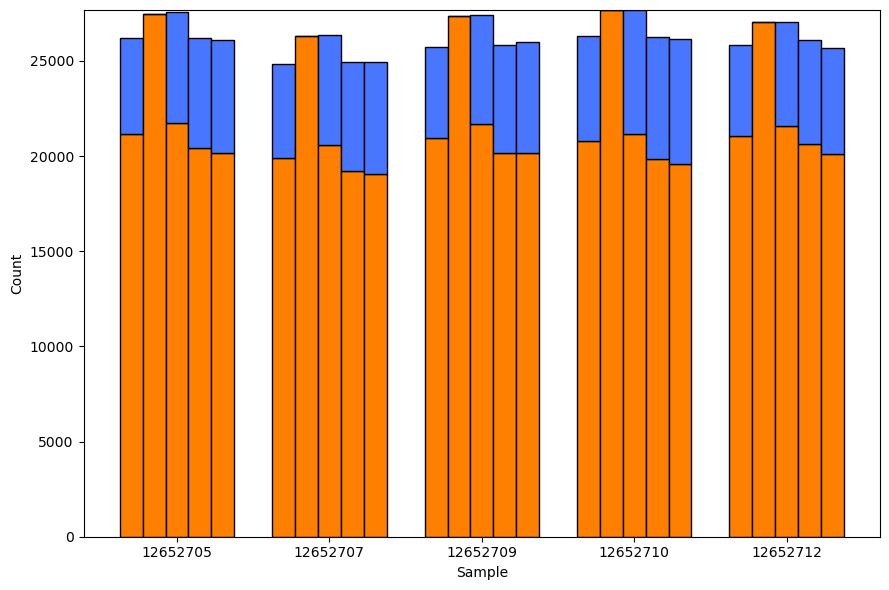

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your data
data = {
    "Sample": [12652705, 12652705, 12652705, 12652705, 12652705,
               12652707, 12652707, 12652707, 12652707, 12652707,
               12652709, 12652709, 12652709, 12652709, 12652709,
               12652710, 12652710, 12652710, 12652710, 12652710,
               12652712, 12652712, 12652712, 12652712, 12652712],
    "Tool": ["VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "BCFTOOL", "DEEPVARIANT",
             "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "BCFTOOL", "DEEPVARIANT",
             "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "BCFTOOL", "DEEPVARIANT",
             "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "BCFTOOL", "DEEPVARIANT",
             "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "BCFTOOL", "DEEPVARIANT"],
    "HET_count": [21131, 27473, 21748, 20447, 20180,
                  19886, 26294, 20572, 19201, 19048,
                  20965, 27331, 21675, 20168, 20178,
                  20797, 27671, 21180, 19839, 19599,
                  21061, 27023, 21599, 20643, 20098],
    "HOM_count": [5086, 0, 5794, 5779, 5918,
                  4922, 0, 5764, 5756, 5874,
                  4772, 0, 5716, 5654, 5788,
                  5486, 0, 6484, 6417, 6574,
                  4775, 0, 5435, 5470, 5554]
}

df = pd.DataFrame(data)

# Create unique x-values for each sample
samples = df['Sample'].unique()
x = np.arange(len(samples))

# Width of each bar
bar_width = 0.15  # Adjust the bar width as needed

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Define custom colors for HET_count and HOM_count
het_color = '#FF8000'
hom_color = '#4876FF'

# Grouped bar chart for each tool (HET_count in blue and HOM_count in orange)
tools = df['Tool'].unique()
for i, tool in enumerate(tools):
    het_counts = df[df['Tool'] == tool]['HET_count']
    hom_counts = df[df['Tool'] == tool]['HOM_count']

    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, het_counts, bar_width, label=f'{tool} (HET_count)', color=het_color, edgecolor='black')
    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, hom_counts, bar_width, label=f'{tool} (HOM_count)', bottom=het_counts, color=hom_color, edgecolor='black')

# Customize the plot
ax.set_xlabel('Sample')
ax.set_ylabel('Count')
ax.set_title("")
ax.set_xticks(x)
ax.set_xticklabels(samples)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_OLD/BWA_MEM_variants_HET_HOM_counts_after_filter.tiff', dpi=600, bbox_inches='tight')
plt.show()

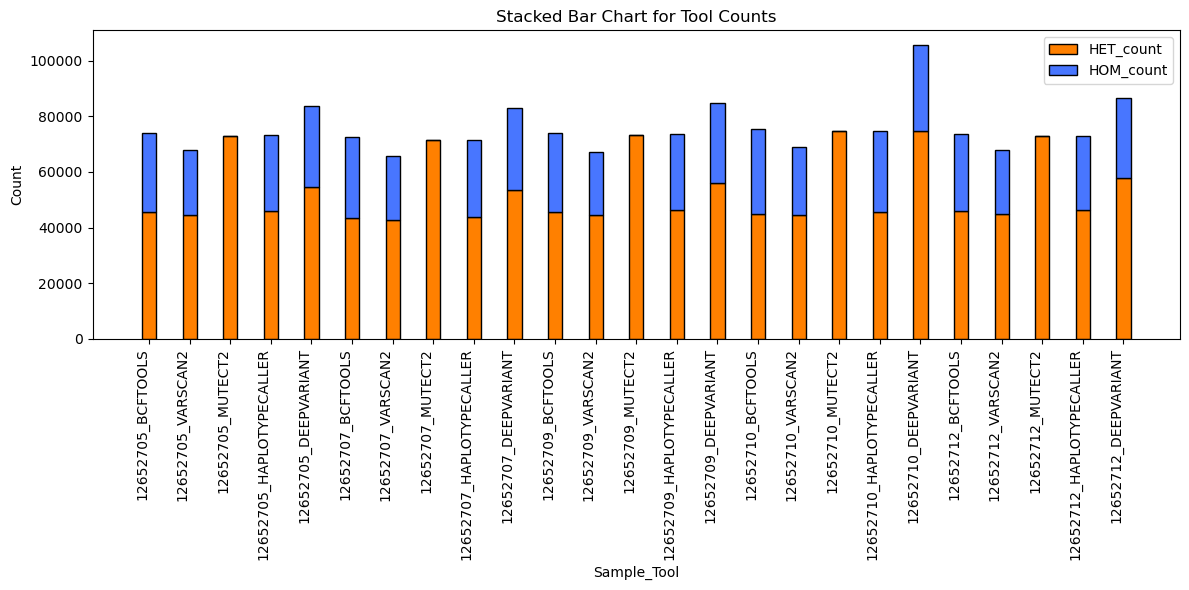

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your data with Sample and Tool combined
data = {
    "Sample_Tool": [
        "12652705_BCFTOOLS", "12652705_VARSCAN2", "12652705_MUTECT2", "12652705_HAPLOTYPECALLER", "12652705_DEEPVARIANT",
        "12652707_BCFTOOLS", "12652707_VARSCAN2", "12652707_MUTECT2", "12652707_HAPLOTYPECALLER", "12652707_DEEPVARIANT",
        "12652709_BCFTOOLS", "12652709_VARSCAN2", "12652709_MUTECT2", "12652709_HAPLOTYPECALLER", "12652709_DEEPVARIANT",
        "12652710_BCFTOOLS", "12652710_VARSCAN2", "12652710_MUTECT2", "12652710_HAPLOTYPECALLER", "12652710_DEEPVARIANT",
        "12652712_BCFTOOLS", "12652712_VARSCAN2", "12652712_MUTECT2", "12652712_HAPLOTYPECALLER", "12652712_DEEPVARIANT"
    ],
    "HET_count": [45612, 44437, 73089, 45939, 54559,
                  43594, 42539, 71549, 43821, 53536,
                  45702, 44351, 73480, 46137, 55884,
                  44941, 44631, 74705, 45461, 74705,
                  45785, 44899, 72893, 46192, 57871],
    "HOM_count": [28467, 23559, 0, 27418, 29097,
                  28846, 23234, 0, 27825, 29417,
                  28462, 22844, 0, 27468, 29095,
                  30400, 24262, 0, 29405, 31016,
                  28006, 23161, 0, 26853, 28620]
}

df = pd.DataFrame(data)

# Create unique x-values for each Sample_Tool combination
sample_tool_labels = df['Sample_Tool']
x = np.arange(len(sample_tool_labels))

# Width of each bar
bar_width = 0.35  # Adjust the bar width as needed

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define custom colors for HET_count and HOM_count
het_color = '#FF8000'
hom_color = '#4876FF'

# Stacked bar chart for each Sample_Tool (HET_count in blue and HOM_count in orange)
het_counts = df['HET_count']
hom_counts = df['HOM_count']

ax.bar(x, het_counts, bar_width, label='HET_count', color=het_color, edgecolor='black')
ax.bar(x, hom_counts, bar_width, label='HOM_count', color=hom_color, edgecolor='black', bottom=het_counts)

# Customize the plot
ax.set_xlabel('Sample_Tool')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Chart for Tool Counts')
ax.set_xticks(x)
ax.set_xticklabels(sample_tool_labels, rotation=90, ha="right")  # Rotate x-axis labels for better readability

# Show the plot
ax.legend()
plt.tight_layout()
plt.show()


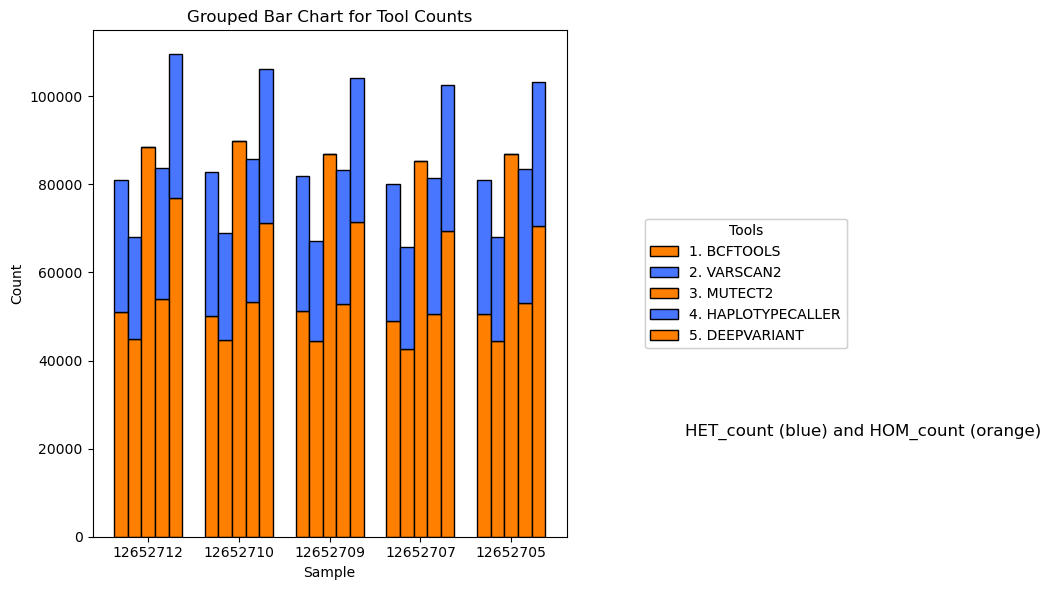

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your data (same as provided in the question)
data = {
    "Sample": [12652712, 12652712, 12652712, 12652712, 12652712,
               12652710, 12652710, 12652710, 12652710, 12652710,
               12652709, 12652709, 12652709, 12652709, 12652709,
               12652707, 12652707, 12652707, 12652707, 12652707,
               12652705, 12652705, 12652705, 12652705, 12652705],
    "Tool": ["BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT"],
    "HET_count": [50922, 44899, 88503, 53892, 76966,
                  50136, 44631, 89758, 53203, 71133,
                  51198, 44351, 86781, 52940, 71351,
                  48927, 42539, 85197, 50561, 69311,
                  50468, 44437, 86955, 53101, 70499],
    "HOM_count": [30106, 23161, 0, 29853, 32515,
                  32743, 24262, 0, 32539, 35107,
                  30623, 22844, 0, 30395, 32804,
                  31057, 23234, 0, 30814, 33270,
                  30529, 23559, 0, 30344, 32831]
}

df = pd.DataFrame(data)

# Create unique x-values for each sample
samples = df['Sample'].unique()
x = np.arange(len(samples))

# Width of each bar
bar_width = 0.15  # Adjust the bar width as needed

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Define custom colors for HET_count and HOM_count
het_color = '#FF8000'
hom_color = '#4876FF'

# Grouped bar chart for each tool (HET_count in blue and HOM_count in orange)
tools = df['Tool'].unique()
legend_labels = []  # To store legend labels in the correct order
for i, tool in enumerate(tools):
    het_counts = df[df['Tool'] == tool]['HET_count']
    hom_counts = df[df['Tool'] == tool]['HOM_count']

    labels = [f'{sample}' for sample in samples]  # Generate labels for each bar
    legend_labels.append(f'{tool} (HET_count)')
    legend_labels.append(f'{tool} (HOM_count)')
    
    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, het_counts, bar_width, label=f'{tool} (HET_count)', color=het_color, edgecolor='black')
    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, hom_counts, bar_width, label=f'{tool} (HOM_count)', bottom=het_counts, color=hom_color, edgecolor='black')

# Customize the plot
ax.set_xlabel('Sample')
ax.set_ylabel('Count')
ax.set_title('Grouped Bar Chart for Tool Counts')
ax.set_xticks(x)
ax.set_xticklabels(samples)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=0)

# Place both legends outside the plot to the right
ax.legend(title='Tool', labels=legend_labels, bbox_to_anchor=(1.15, 1), loc='upper left')
custom_legend_labels = ["1. BCFTOOLS", "2. VARSCAN2", "3. MUTECT2", "4. HAPLOTYPECALLER", "5. DEEPVARIANT"]
custom_legend = plt.legend(custom_legend_labels, title='Tools', bbox_to_anchor=(1.15, 0.5), loc='center left')

# Show the plot
plt.tight_layout()
plt.text(1.25, 0.2, "HET_count (blue) and HOM_count (orange)", fontsize=12, transform=ax.transAxes)

# Combine both legends
ax.add_artist(custom_legend)

plt.show()

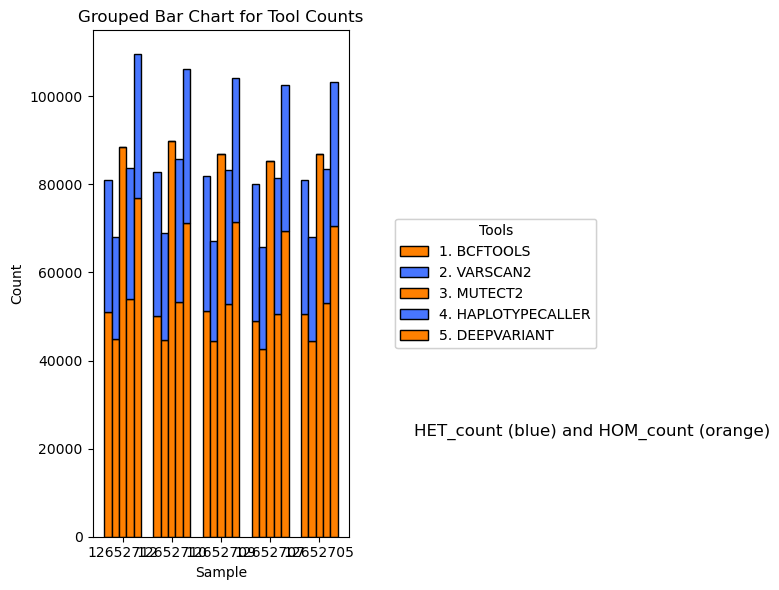

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your data (same as provided in the question)
data = {
    "Sample": [12652712, 12652712, 12652712, 12652712, 12652712,
               12652710, 12652710, 12652710, 12652710, 12652710,
               12652709, 12652709, 12652709, 12652709, 12652709,
               12652707, 12652707, 12652707, 12652707, 12652707,
               12652705, 12652705, 12652705, 12652705, 12652705],
    "Tool": ["BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT"],
    "HET_count": [50922, 44899, 88503, 53892, 76966,
                  50136, 44631, 89758, 53203, 71133,
                  51198, 44351, 86781, 52940, 71351,
                  48927, 42539, 85197, 50561, 69311,
                  50468, 44437, 86955, 53101, 70499],
    "HOM_count": [30106, 23161, 0, 29853, 32515,
                  32743, 24262, 0, 32539, 35107,
                  30623, 22844, 0, 30395, 32804,
                  31057, 23234, 0, 30814, 33270,
                  30529, 23559, 0, 30344, 32831]
}

df = pd.DataFrame(data)

# Create unique x-values for each sample
samples = df['Sample'].unique()
x = np.arange(len(samples))

# Width of each bar
bar_width = 0.15  # Adjust the bar width as needed

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Define custom colors for HET_count and HOM_count
het_color = '#FF8000'
hom_color = '#4876FF'

# Grouped bar chart for each tool (HET_count in blue and HOM_count in orange)
tools = df['Tool'].unique()
legend_labels = []  # To store legend labels in the correct order
for i, tool in enumerate(tools):
    het_counts = df[df['Tool'] == tool]['HET_count']
    hom_counts = df[df['Tool'] == tool]['HOM_count']

    labels = [f'{sample}' for sample in samples]  # Generate labels for each bar
    legend_labels.append(f'{tool} (HET_count)')
    legend_labels.append(f'{tool} (HOM_count')
    
    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, het_counts, bar_width, label=f'{tool} (HET_count)', color=het_color, edgecolor='black')
    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, hom_counts, bar_width, label=f'{tool} (HOM_count)', bottom=het_counts, color=hom_color, edgecolor='black')

# Customize the plot
ax.set_xlabel('Sample')
ax.set_ylabel('Count')
ax.set_title('Grouped Bar Chart for Tool Counts')
ax.set_xticks(x)
ax.set_xticklabels(samples)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=0)

# Place both legends outside the plot to the right
ax.legend(title='Tool', labels=legend_labels, bbox_to_anchor=(1.15, 1), loc='upper left')
custom_legend_labels = ["1. BCFTOOLS", "2. VARSCAN2", "3. MUTECT2", "4. HAPLOTYPECALLER", "5. DEEPVARIANT"]
custom_legend = plt.legend(custom_legend_labels, title='Tools', bbox_to_anchor=(1.15, 0.5), loc='center left')

# Add an overall label
plt.text(1.25, 0.2, "HET_count (blue) and HOM_count (orange)", fontsize=12, transform=ax.transAxes)

# Show the plot
plt.tight_layout()

# Combine both legends
ax.add_artist(custom_legend)

plt.show()


In [190]:
import os
import pandas as pd

# Function to load variants from a VCF file into a pandas DataFrame
def load_variants_into_dataframe(vcf_file):
    vcf_reader = pd.read_csv(vcf_file, sep='\t', comment='#', header=None)
    vcf_reader.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    return vcf_reader

# Function to calculate Jaccard similarity between two sets
def calculate_jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0.0

# Folder path containing VCF files
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/'

# Get a list of all VCF files in the folder
vcf_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.vcf')]

# Load variants from each VCF file into pandas DataFrames
variant_dataframes = [load_variants_into_dataframe(vcf_file) for vcf_file in vcf_files]

# Calculate Jaccard similarity between each pair of VCF files
similarity_matrix = []

for i in range(len(vcf_files)):
    row = []
    for j in range(len(vcf_files)):
        set1 = set(variant_dataframes[i]['POS'].astype(str))
        set2 = set(variant_dataframes[j]['POS'].astype(str))
        similarity = calculate_jaccard_similarity(set1, set2)
        row.append(similarity)
    similarity_matrix.append(row)

# Create a pandas DataFrame for the Jaccard similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=[os.path.basename(file) for file in vcf_files], columns=[os.path.basename(file) for file in vcf_files])

# Print the Jaccard similarity matrix
similarity_df

12652705_deep_variant_cov.vcf  \
12652705_deep_variant_cov.vcf                       1.000000   
12652705_Haplotype_cov.vcf                          0.800640   
12652705_Mutect2_cov.vcf                            0.791087   
12652705_qual_filter_cov.vcf                        0.746223   
12652705_varscan_cov.vcf                            0.569312   

                               12652705_Haplotype_cov.vcf  \
12652705_deep_variant_cov.vcf                    0.800640   
12652705_Haplotype_cov.vcf                       1.000000   
12652705_Mutect2_cov.vcf                         0.919420   
12652705_qual_filter_cov.vcf                     0.889669   
12652705_varscan_cov.vcf                         0.640944   

                               12652705_Mutect2_cov.vcf  \
12652705_deep_variant_cov.vcf                  0.791087   
12652705_Haplotype_cov.vcf                     0.919420   
12652705_Mutect2_cov.vcf                       1.000000   
12652705_qual_filter_cov.vcf                   0.834135   
12652705_varscan_cov.vcf                       0.602359   

                               12652705_qual_filter_cov.vcf  \
12652705_deep_variant_cov.vcf                      0.746223   
12652705_Haplotype_cov.vcf                         0.889669   
12652705_Mutect2_cov.vcf                           0.834135   
12652705_qual_filter_cov.vcf                       1.000000   
12652705_varscan_cov.vcf                           0.689736   

                               12652705_varscan_cov.vcf  
12652705_deep_variant_cov.vcf                  0.569312  
12652705_Haplotype_cov.vcf                     0.640944  
12652705_Mutect2_cov.vcf                       0.602359  
12652705_qual_filter_cov.vcf                   0.689736  
12652705_varscan_cov.vcf                       1.000000

In [191]:
similarity_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652705/12652705_Jaccard_similarity_table.xlsx', index=False)

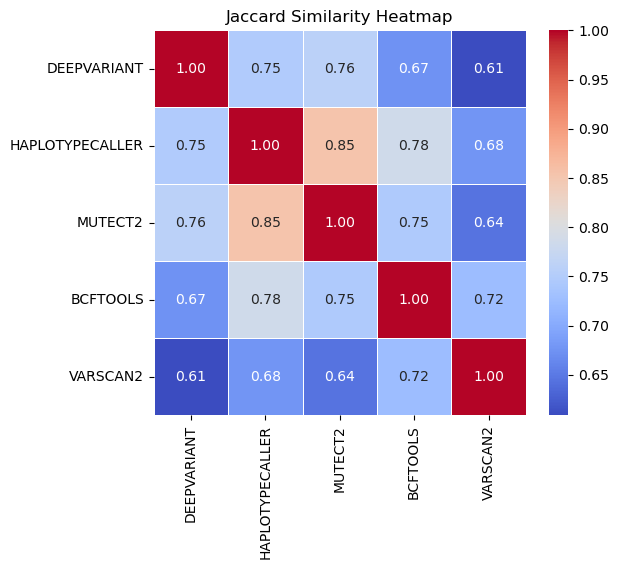

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Jaccard similarity matrix (replace this with your actual data)
data = [
    [1, 0.741145224, 0.757608115, 0.665093875, 0.599413813],
    [0.741145224, 1, 0.858845897, 0.781695003, 0.674080829],
    [0.757608115, 0.858845897, 1, 0.743882005, 0.641535181],
    [0.665093875, 0.781695003, 0.743882005, 1, 0.711745448],
    [0.599413813, 0.674080829, 0.641535181, 0.711745448, 1]
]

# Names of the VCF files (replace with your actual file names)
file_names = [
    "DEEPVARIANT",
    "HAPLOTYPECALLER",
    "MUTECT2",
    "BCFTOOLS",
    "VARSCAN2"
]

# Create a DataFrame from the Jaccard similarity matrix
df = pd.DataFrame(data, index=file_names, columns=file_names)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.6)
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/Heatmap.png', dpi=2000, bbox_inches='tight')
plt.title('Jaccard Similarity Heatmap')
plt.show()

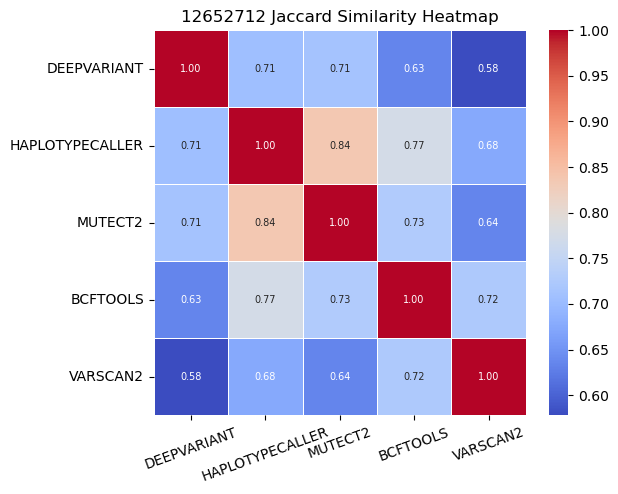

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Jaccard similarity matrix (replace this with your actual data)
data = [
    [1, 0.705090758, 0.711962161, 0.633966019, 0.57788976],
    [0.705090758, 1, 0.835236959, 0.773010954, 0.675699841],
    [0.711962161, 0.835236959, 1, 0.727299588, 0.635430159],
    [0.633966019, 0.773010954, 0.727299588, 1, 0.724637346],
    [0.57788976, 0.675699841, 0.635430159, 0.724637346, 1]
]

# Names of the VCF files (replace with your actual file names)
file_names = [
    "DEEPVARIANT",
    "HAPLOTYPECALLER",
    "MUTECT2",
    "BCFTOOLS",
    "VARSCAN2"
]

# Create a DataFrame from the Jaccard similarity matrix
df = pd.DataFrame(data, index=file_names, columns=file_names)

# Create a heatmap with x-axis labels rotated by 45 degrees
plt.figure(figsize=(6, 5))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.7, xticklabels=True,
            annot_kws={"size": 7})  # Adjust the "size" parameter to set the font size
plt.xticks(rotation=20)  # Rotate x-axis labels by 45 degrees
plt.title('12652712 Jaccard Similarity Heatmap')
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652712/12652712_Heatmap.png', dpi=2000, bbox_inches='tight')
plt.show()

# Concordance_rate

In [14]:
import pandas as pd

# Function to load variants from an Excel file into a list of sets
def load_variants_from_excel(excel_file):
    df = pd.read_excel(excel_file)
    
    # Assuming each column represents variants from a different VCF file
    variants_lists = [set(df[column]) for column in df.columns]
    
    return variants_lists

# Function to calculate concordance rate between two sets of variants
def calculate_concordance_rate(variants1, variants2):
    # Calculate shared variants (intersection)
    shared_variants = variants1.intersection(variants2)
    
    # Calculate concordance rate
    concordance_rate = len(shared_variants) / max(len(variants1), len(variants2))
    
    return concordance_rate

# Path to the Excel file containing variants (with 5 columns)
excel_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652710/12652710_concordance_input.xlsx'

# Load variants from the Excel file into a list of sets
variants_lists = load_variants_from_excel(excel_file)

# Calculate concordance rates between pairs of variants
concordance_matrix = []

for i in range(len(variants_lists)):
    row = []
    for j in range(len(variants_lists)):
        concordance = calculate_concordance_rate(variants_lists[i], variants_lists[j])
        row.append(concordance)
    concordance_matrix.append(row)

# Display the concordance matrix (replace with your desired output)
for i, row in enumerate(concordance_matrix):
    for j, concordance in enumerate(row):
        print(f'Concordance rate between VCF {i+1} and VCF {j+1}: {concordance:.2%}')

# You can further analyze the concordance matrix as needed

Concordance rate between VCF 1 and VCF 1: 100.00%
Concordance rate between VCF 1 and VCF 2: 76.39%
Concordance rate between VCF 1 and VCF 3: 81.55%
Concordance rate between VCF 1 and VCF 4: 86.07%
Concordance rate between VCF 1 and VCF 5: 71.08%
Concordance rate between VCF 2 and VCF 1: 76.39%
Concordance rate between VCF 2 and VCF 2: 100.00%
Concordance rate between VCF 2 and VCF 3: 68.55%
Concordance rate between VCF 2 and VCF 4: 72.26%
Concordance rate between VCF 2 and VCF 5: 61.76%
Concordance rate between VCF 3 and VCF 1: 81.55%
Concordance rate between VCF 3 and VCF 2: 68.55%
Concordance rate between VCF 3 and VCF 3: 100.00%
Concordance rate between VCF 3 and VCF 4: 89.42%
Concordance rate between VCF 3 and VCF 5: 79.33%
Concordance rate between VCF 4 and VCF 1: 86.07%
Concordance rate between VCF 4 and VCF 2: 72.26%
Concordance rate between VCF 4 and VCF 3: 89.42%
Concordance rate between VCF 4 and VCF 4: 100.00%
Concordance rate between VCF 4 and VCF 5: 77.08%
Concordance rate

In [21]:
import pandas as pd

# Function to load variants from an Excel file into a list of sets
def load_variants_from_excel(excel_file):
    df = pd.read_excel(excel_file)
    
    # Get the column names as VCF file names
    vcf_names = df.columns.tolist()
    
    # Create a dictionary to store variants lists with VCF names as keys
    variants_dict = {vcf_name: set(df[vcf_name]) for vcf_name in vcf_names}
    
    return vcf_names, variants_dict

# Function to calculate concordance rate between two sets of variants
def calculate_concordance_rate(variants1, variants2):
    # Calculate shared variants (intersection)
    shared_variants = variants1.intersection(variants2)
    
    # Calculate concordance rate
    concordance_rate = len(shared_variants) / max(len(variants1), len(variants2))
    
    return concordance_rate

# Path to the Excel file containing variants (with 5 columns)
excel_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652707/12652707_concordance_input.xlsx'

# Load variants from the Excel file into a list of sets and get VCF names
vcf_names, variants_dict = load_variants_from_excel(excel_file)

# Calculate concordance rates between pairs of variants
concordance_matrix = []

for i in range(len(vcf_names)):
    row = []
    for j in range(len(vcf_names)):
        concordance = calculate_concordance_rate(variants_dict[vcf_names[i]], variants_dict[vcf_names[j]])
        row.append(concordance)
    concordance_matrix.append(row)

# Display the concordance matrix with VCF names
for i, row in enumerate(concordance_matrix):
    for j, concordance in enumerate(row):
        print(f'{vcf_names[i]} and {vcf_names[j]}: {concordance:.2%}')

# You can further analyze the concordance matrix as needed

BCFTOOL and BCFTOOL: 100.00%
BCFTOOL and VARSCAN2: 75.89%
BCFTOOL and MUTECT2: 82.34%
BCFTOOL and HAPLOTYPECALLER: 86.84%
BCFTOOL and DEEPVARIANT: 70.73%
VARSCAN2 and BCFTOOL: 75.89%
VARSCAN2 and VARSCAN2: 100.00%
VARSCAN2 and MUTECT2: 69.12%
VARSCAN2 and HAPLOTYPECALLER: 72.92%
VARSCAN2 and DEEPVARIANT: 61.21%
MUTECT2 and BCFTOOL: 82.34%
MUTECT2 and VARSCAN2: 69.12%
MUTECT2 and MUTECT2: 100.00%
MUTECT2 and HAPLOTYPECALLER: 89.90%
MUTECT2 and DEEPVARIANT: 78.32%
HAPLOTYPECALLER and BCFTOOL: 86.84%
HAPLOTYPECALLER and VARSCAN2: 72.92%
HAPLOTYPECALLER and MUTECT2: 89.90%
HAPLOTYPECALLER and HAPLOTYPECALLER: 100.00%
HAPLOTYPECALLER and DEEPVARIANT: 75.93%
DEEPVARIANT and BCFTOOL: 70.73%
DEEPVARIANT and VARSCAN2: 61.21%
DEEPVARIANT and MUTECT2: 78.32%
DEEPVARIANT and HAPLOTYPECALLER: 75.93%
DEEPVARIANT and DEEPVARIANT: 100.00%


In [22]:
import pandas as pd

# Function to load variants from an Excel file into a list of sets
def load_variants_from_excel(excel_file):
    df = pd.read_excel(excel_file)
    
    # Get the column names as VCF file names
    vcf_names = df.columns.tolist()
    
    # Create a dictionary to store variants lists with VCF names as keys
    variants_dict = {vcf_name: set(df[vcf_name]) for vcf_name in vcf_names}
    
    return vcf_names, variants_dict

# Function to calculate concordance rate between two sets of variants
def calculate_concordance_rate(variants1, variants2):
    # Calculate shared variants (intersection)
    shared_variants = variants1.intersection(variants2)
    
    # Calculate concordance rate
    concordance_rate = len(shared_variants) / max(len(variants1), len(variants2))
    
    return concordance_rate

# Path to the Excel file containing variants (with 5 columns)
excel_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652707/12652707_concordance_input.xlsx'

# Load variants from the Excel file into a list of sets and get VCF names
vcf_names, variants_dict = load_variants_from_excel(excel_file)

# Calculate concordance rates between pairs of variants
concordance_matrix = []

for i in range(len(vcf_names)):
    row = []
    for j in range(len(vcf_names)):
        concordance = calculate_concordance_rate(variants_dict[vcf_names[i]], variants_dict[vcf_names[j]])
        row.append(concordance)
    concordance_matrix.append(row)

# Create a DataFrame from the concordance matrix with VCF names as columns and index
concordance_df = pd.DataFrame(concordance_matrix, columns=vcf_names, index=vcf_names)

# Display the DataFrame
concordance_df

BCFTOOL  VARSCAN2   MUTECT2  HAPLOTYPECALLER  DEEPVARIANT
BCFTOOL          1.000000  0.758867  0.823447         0.868376     0.707314
VARSCAN2         0.758867  1.000000  0.691213         0.729232     0.612141
MUTECT2          0.823447  0.691213  1.000000         0.899012     0.783205
HAPLOTYPECALLER  0.868376  0.729232  0.899012         1.000000     0.759263
DEEPVARIANT      0.707314  0.612141  0.783205         0.759263     1.000000

In [215]:
import pandas as pd

# Function to load variants from an Excel file into a list of sets
def load_variants_from_excel(excel_file):
    df = pd.read_excel(excel_file)
    return df

# Function to calculate concordance rate between two sets of variants
def calculate_concordance_rate(variants1, variants2):
    # Calculate shared variants (intersection)
    shared_variants = variants1.intersection(variants2)
    
    # Calculate concordance rate
    concordance_rate = len(shared_variants) / max(len(variants1), len(variants2))
    
    return concordance_rate

# Path to the Excel file containing variants (with 5 columns)
excel_file = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/Output_files/12652705/12652705_concordance_input.xlsx'

# Load variants and VCF file names from the Excel file
data = load_variants_from_excel(excel_file)
vcf_file_names = data.columns.tolist()

# Calculate concordance rates between pairs of variants
concordance_matrix = []

for i in range(len(vcf_file_names)):
    row = []
    for j in range(len(vcf_file_names)):
        concordance = calculate_concordance_rate(set(data[vcf_file_names[i]]), set(data[vcf_file_names[j]]))
        row.append(concordance)
    concordance_matrix.append(row)

# Create a DataFrame for the concordance matrix
concordance_df = pd.DataFrame(concordance_matrix, columns=vcf_file_names, index=vcf_file_names)

# Display the concordance matrix in table form
concordance_df

BCFTOOL  VARSCAN2   MUTECT2  HAPLOTYPECALLER  DEEPVARIANT
BCFTOOL          1.000000  0.772612  0.825429         0.866632     0.718339
VARSCAN2         0.772612  1.000000  0.698250         0.732522     0.627514
MUTECT2          0.825429  0.698250  1.000000         0.902744     0.795200
HAPLOTYPECALLER  0.866632  0.732522  0.902744         1.000000     0.772796
DEEPVARIANT      0.718339  0.627514  0.795200         0.772796     1.000000

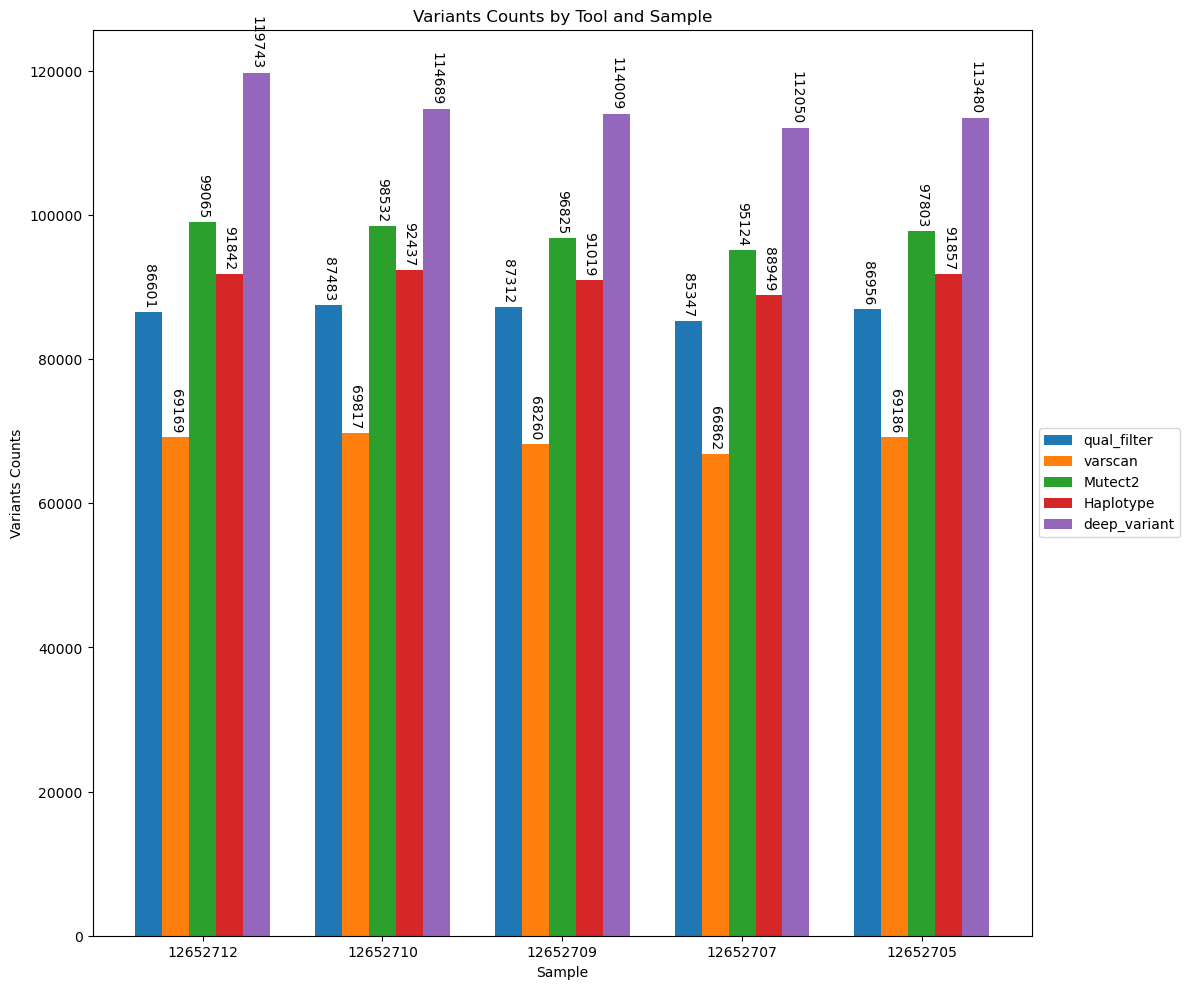

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
samples = [12652712, 12652710, 12652709, 12652707, 12652705]
tools = ["qual_filter", "varscan", "Mutect2", "Haplotype", "deep_variant"]
variants_counts = [
    [86601, 87483, 87312, 85347, 86956],
    [69169, 69817, 68260, 66862, 69186],
    [99065, 98532, 96825, 95124, 97803],
    [91842, 92437, 91019, 88949, 91857],
    [119743, 114689, 114009, 112050, 113480]
]

# Create a stacked bar graph
bar_width = 0.15
index = np.arange(len(samples))

fig, ax = plt.subplots(figsize=(12, 10))  # Adjust the figure size if needed

for i, tool in enumerate(tools):
    bars = plt.bar(index + i * bar_width, variants_counts[i], bar_width, label=tool)
    
    # Add data labels on top of the bars with 180-degree rotation
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=270)  # Rotate the label by 180 degrees

plt.xlabel("Sample")
plt.ylabel("Variants Counts")
plt.title("Variants Counts by Tool and Sample")
plt.xticks(index + bar_width * 2, samples)

# Place the legend outside the graph
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the graph
plt.tight_layout()
plt.show()


ValueError: 'label' must be of length 'x'

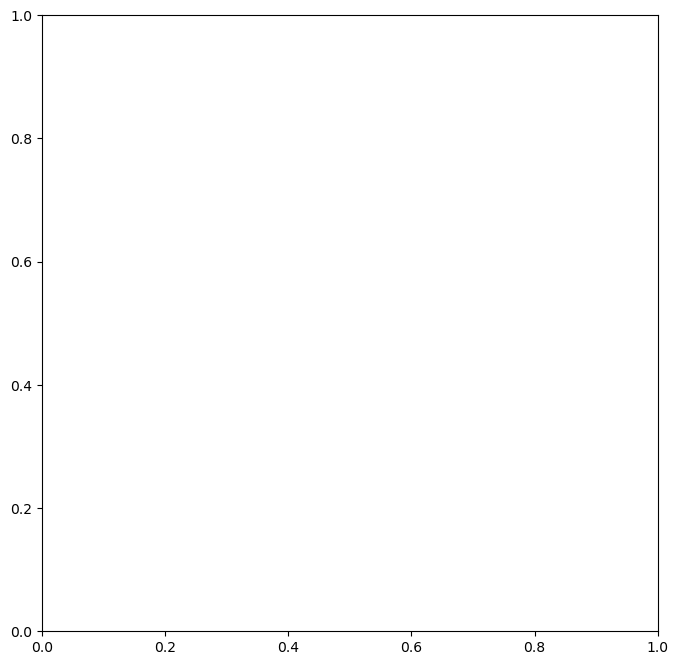

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Read your Excel file into a Pandas DataFrame
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712_concat_columns_5_vcf.xlsx')

# Create sets for each column's unique values
column1_values = set(df['qual_filter'])
column2_values = set(df['varscan'])
column3_values = set(df['Mutect2'])
column4_values = set(df['Haplotype'])
column5_values = set(df['deep_variant'])

# Calculate the intersections
intersection_1_2 = column1_values.intersection(column2_values)
intersection_1_3 = column1_values.intersection(column3_values)
intersection_1_4 = column1_values.intersection(column4_values)
intersection_1_5 = column1_values.intersection(column5_values)
intersection_2_3 = column2_values.intersection(column3_values)
intersection_2_4 = column2_values.intersection(column4_values)
intersection_2_5 = column2_values.intersection(column5_values)
intersection_3_4 = column3_values.intersection(column4_values)
intersection_3_5 = column3_values.intersection(column5_values)
intersection_4_5 = column4_values.intersection(column5_values)

# Calculate the unique values in each column
unique_1 = column1_values - (intersection_1_2 | intersection_1_3 | intersection_1_4 | intersection_1_5)
unique_2 = column2_values - (intersection_1_2 | intersection_2_3 | intersection_2_4 | intersection_2_5)
unique_3 = column3_values - (intersection_1_3 | intersection_2_3 | intersection_3_4 | intersection_3_5)
unique_4 = column4_values - (intersection_1_4 | intersection_2_4 | intersection_3_4 | intersection_4_5)
unique_5 = column5_values - (intersection_1_5 | intersection_2_5 | intersection_3_5 | intersection_4_5)

# Create a custom Venn-like diagram using matplotlib
plt.figure(figsize=(8, 8))
venn_labels = [
    f"Column1 ({len(unique_1)})",
    f"Column2 ({len(unique_2)})",
    f"Column3 ({len(unique_3)})",
    f"Column4 ({len(unique_4)})",
    f"Column5 ({len(unique_5)})"
]

venn_areas = [
    len(unique_1),
    len(unique_2),
    len(intersection_1_2),
    len(unique_3),
    len(intersection_1_3),
    len(intersection_2_3),
    len(intersection_3_4),
    len(intersection_1_4),
    len(intersection_2_4),
    len(unique_4),
    len(intersection_1_5),
    len(intersection_2_5),
    len(intersection_3_5),
    len(intersection_4_5),
    len(unique_5)
]

plt.pie(venn_areas, labels=venn_labels, autopct='%1.1f%%', startangle=90)
plt.title("Venn Diagram for 12652712")
plt.show()

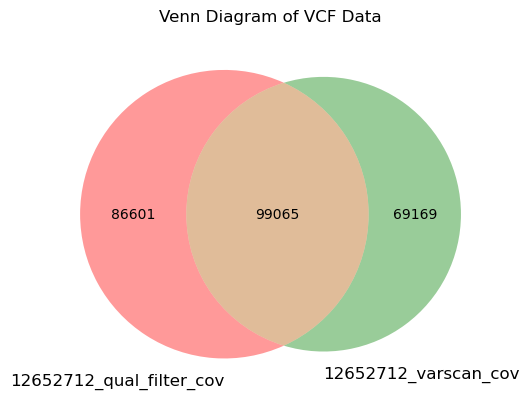

In [15]:
import pandas as pd
import os
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Define the list of VCF file names with Windows file paths
vcf_files = [
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/12652712_qual_filter_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/12652712_varscan_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/12652712_Mutect2_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/12652712_Haplotype_cov.vcf",
    r"C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/12652712_deep_variant_cov.vcf",
]

# Create empty sets to store data
data_sets = []

# Iterate through each VCF file and extract relevant data
for vcf_file in vcf_files:
    # Read the VCF file into a DataFrame
    vcf_data = pd.read_csv(vcf_file, sep="\t", header=None, comment="#")
    
    # Extract relevant columns (CHROM, POS, REF, ALT, ID)
    vcf_data = vcf_data.iloc[:, 0:5]
    vcf_data.columns = ["CHROM", "POS", "REF", "ALT", "ID"]
    
    # Convert the data to a set of tuples for easy comparison
    data_set = set(map(tuple, vcf_data.values.tolist()))
    data_sets.append(data_set)

# Extract count values for the Venn diagram
venn_data = [len(data_set) for data_set in data_sets]

# Create a Venn diagram to visualize the common and unique data
venn2(subsets=venn_data, set_labels=[os.path.splitext(os.path.basename(file))[0] for file in vcf_files])

# Display the Venn diagram
plt.title("Venn Diagram of VCF Data")
plt.show()


In [18]:
data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/1074_GENEINFO_samples_gene_rsID.csv', header = None, sep='\t')
data.columns = ['samples', 'gene', 'rsID']
data = data[data['samples'] != 'Samples,Gene,rsID']
data

samples                             gene         rsID
0         KHAIGPRX1000  DDX11L1:100287102|WASH7P:653635  rs878986575
1         KHAIGPRX1000  DDX11L1:100287102|WASH7P:653635   rs62635297
2         KHAIGPRX1000  DDX11L1:100287102|WASH7P:653635    rs6682375
3         KHAIGPRX1000                    WASH7P:653635    rs6682385
4         KHAIGPRX1000                    WASH7P:653635   rs11580262
...                ...                              ...          ...
62274395     KHAIGPRX9           LOC105379273:105379273  rs879131487
62274396     KHAIGPRX9                       DDX3Y:8653    rs2032624
62274397     KHAIGPRX9                         UTY:7404  rs376367714
62274398     KHAIGPRX9                     NLGN4Y:22829   rs67643699
62274399     KHAIGPRX9                      EIF1AY:9086    rs9786153

[62273327 rows x 3 columns]

In [19]:
data['Gene'] = data['gene'].apply(lambda x: ','.join([segment.split(':')[0] for segment in x.split('|')]) if pd.notnull(x) else '')
data

samples                             gene         rsID  \
0         KHAIGPRX1000  DDX11L1:100287102|WASH7P:653635  rs878986575   
1         KHAIGPRX1000  DDX11L1:100287102|WASH7P:653635   rs62635297   
2         KHAIGPRX1000  DDX11L1:100287102|WASH7P:653635    rs6682375   
3         KHAIGPRX1000                    WASH7P:653635    rs6682385   
4         KHAIGPRX1000                    WASH7P:653635   rs11580262   
...                ...                              ...          ...   
62274395     KHAIGPRX9           LOC105379273:105379273  rs879131487   
62274396     KHAIGPRX9                       DDX3Y:8653    rs2032624   
62274397     KHAIGPRX9                         UTY:7404  rs376367714   
62274398     KHAIGPRX9                     NLGN4Y:22829   rs67643699   
62274399     KHAIGPRX9                      EIF1AY:9086    rs9786153   

                    Gene  
0         DDX11L1,WASH7P  
1         DDX11L1,WASH7P  
2         DDX11L1,WASH7P  
3                 WASH7P  
4                 WASH7P  
...                  ...  
62274395    LOC105379273  
62274396           DDX3Y  
62274397             UTY  
62274398          NLGN4Y  
62274399          EIF1AY  

[62273327 rows x 4 columns]

In [20]:
data.isnull().sum()

samples    0
gene       0
rsID       0
Gene       0
dtype: int64

In [21]:
null_rows = data[data['gene'].isnull()]
null_rows

Empty DataFrame
Columns: [samples, gene, rsID, Gene]
Index: []

In [22]:
data.samples.value_counts()

KHAIGPRX100     96684
KHAIGPRX11      91833
KHAIGPRX94      91049
KHAIGPRX98      87577
KHAIGPRX99      87228
                ...  
KHAIGPRX1025    27053
KHAIGPRX1011    26793
KHAIGPRX1023    26710
KHAIGPRX1026    26309
KHAIGPRX1008    26213
Name: samples, Length: 1074, dtype: int64

In [23]:
data.iloc[62204510:62204520]

samples                             gene          rsID  \
62205583  KHAIGPRX9                   PRAMEF9:343070  rs1436552013   
62205584  KHAIGPRX9                   PRAMEF9:343070  rs1339853792   
62205585  KHAIGPRX9                   PRAMEF9:343070  rs1433416284   
62205586  KHAIGPRX9                   PRAMEF9:343070  rs1409225045   
62205587  KHAIGPRX9                   PRAMEF9:343070  rs1421615433   
62205588  KHAIGPRX9                   PRAMEF9:343070  rs1211386606   
62205589  KHAIGPRX9                   PRAMEF9:343070    rs72474524   
62205590  KHAIGPRX9                   PRAMEF9:343070    rs71225489   
62205591  KHAIGPRX9  PRAMEF18:391003|PRAMEF22:653606    rs56295303   
62205592  KHAIGPRX9  PRAMEF18:391003|PRAMEF22:653606    rs56101354   

                       Gene  
62205583            PRAMEF9  
62205584            PRAMEF9  
62205585            PRAMEF9  
62205586            PRAMEF9  
62205587            PRAMEF9  
62205588            PRAMEF9  
62205589            PRAMEF9  
62205590            PRAMEF9  
62205591  PRAMEF18,PRAMEF22  
62205592  PRAMEF18,PRAMEF22

In [ ]:
data['gene_new'] = data['Gene'].str.split(',')
data

In [ ]:
data_new = data.explode('gene_new')

In [8]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/1074_with_out_GENEINFO_samples_gene_rsID.csv', header = 0)
df

Samples     Gene        rsID
0        KHAIGPRX1000    TTC34  rs60389769
1        KHAIGPRX1000  EEF1DP6   rs4654500
2        KHAIGPRX1000   ERRFI1  rs72634228
3        KHAIGPRX1000   SBF1P2  rs61359664
4        KHAIGPRX1000   SBF1P2    rs885770
...               ...      ...         ...
5199829     KHAIGPRX9  CTBP2P1   rs4893674
5199830     KHAIGPRX9  CTBP2P1   rs9782846
5199831     KHAIGPRX9  CTBP2P1   rs6568353
5199832     KHAIGPRX9  CTBP2P1   rs6568352
5199833     KHAIGPRX9  CTBP2P1   rs6568351

[5199834 rows x 3 columns]

In [1]:
import pandas as pd

data = [
    {'alleledefinitionid': 778744, 'locationid': 778526, 'variantallele': 'C', 'version': 1, 'sequence_location': {'id': 778526, 'version': 58, 'name': 'c.376A>G', 'chromosomelocation': 'g.154535277T>C', 'genelocation': 'g.17296A>G', 'proteinlocation': 'p.N126D', 'genesymbol': 'G6PD', 'dbsnpid': 'rs1050829', 'position': 154535277}},
    {'alleledefinitionid': 778744, 'locationid': 778549, 'variantallele': 'A', 'version': 1, 'sequence_location': {'id': 778549, 'version': 58, 'name': 'c.542A>T', 'chromosomelocation': 'g.154534440T>A', 'genelocation': 'g.18133A>T', 'proteinlocation': 'p.D181V', 'genesymbol': 'G6PD', 'dbsnpid': 'rs5030872', 'position': 154534440}}
]

df = pd.DataFrame(data)
df

alleledefinitionid  locationid variantallele  version  \
0              778744      778526             C        1   
1              778744      778549             A        1   

                                   sequence_location  
0  {'id': 778526, 'version': 58, 'name': 'c.376A>...  
1  {'id': 778549, 'version': 58, 'name': 'c.542A>...

In [3]:
import pandas as pd

# Your input data
data = [
    {'alleledefinitionid': 778744, 'locationid': 778526, 'variantallele': 'C', 'version': 1, 'sequence_location': {'id': 778526, 'version': 58, 'name': 'c.376A>G', 'chromosomelocation': 'g.154535277T>C', 'genelocation': 'g.17296A>G', 'proteinlocation': 'p.N126D', 'genesymbol': 'G6PD', 'dbsnpid': 'rs1050829', 'position': 154535277}},
    {'alleledefinitionid': 778744, 'locationid': 778549, 'variantallele': 'A', 'version': 1, 'sequence_location': {'id': 778549, 'version': 58, 'name': 'c.542A>T', 'chromosomelocation': 'g.154534440T>A', 'genelocation': 'g.18133A>T', 'proteinlocation': 'p.D181V', 'genesymbol': 'G6PD', 'dbsnpid': 'rs5030872', 'position': 154534440}},
    {'alleledefinitionid': 778952, 'locationid': 778625, 'variantallele': 'A', 'version': 1, 'sequence_location': {'id': 778625, 'version': 58, 'name': 'c.1187C>T', 'chromosomelocation': 'g.154532667G>A', 'genelocation': 'g.19906C>T', 'proteinlocation': 'p.P396L', 'genesymbol': 'G6PD', 'dbsnpid': None, 'position': 154532667}}
]

# Convert data to DataFrame
df = pd.DataFrame(data)
df

alleledefinitionid  locationid variantallele  version  \
0              778744      778526             C        1   
1              778744      778549             A        1   
2              778952      778625             A        1   

                                   sequence_location  
0  {'id': 778526, 'version': 58, 'name': 'c.376A>...  
1  {'id': 778549, 'version': 58, 'name': 'c.542A>...  
2  {'id': 778625, 'version': 58, 'name': 'c.1187C...

In [4]:
# Flatten nested dictionaries
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Apply the flatten_dict function to sequence_location column
df['sequence_location'] = df['sequence_location'].apply(flatten_dict)

# Convert the flattened sequence_location dictionaries to separate columns
df = pd.concat([df.drop('sequence_location', axis=1), df['sequence_location'].apply(pd.Series)], axis=1)

# Display the resulting DataFrame
df

alleledefinitionid  locationid variantallele  version      id  version  \
0              778744      778526             C        1  778526       58   
1              778744      778549             A        1  778549       58   
2              778952      778625             A        1  778625       58   

        name chromosomelocation genelocation proteinlocation genesymbol  \
0   c.376A>G     g.154535277T>C   g.17296A>G         p.N126D       G6PD   
1   c.542A>T     g.154534440T>A   g.18133A>T         p.D181V       G6PD   
2  c.1187C>T     g.154532667G>A   g.19906C>T         p.P396L       G6PD   

     dbsnpid   position  
0  rs1050829  154535277  
1  rs5030872  154534440  
2       None  154532667

In [11]:
import pandas as pd

# Sample data in a single column
data = [
    {'alleledefinitionid': 778952, 'locationid': 778625, 'variantallele': 'A', 'version': 1, 'sequence_location': {'id': 778625, 'version': 58, 'name': 'c.1187C>T', 'chromosomelocation': 'g.154532667G>A', 'genelocation': 'g.19906C>T', 'proteinlocation': 'p.P396L', 'genesymbol': 'G6PD', 'dbsnpid': None, 'position': 154532667}}
]

# Convert data to DataFrame
df = pd.DataFrame(data, columns=['column1'])
data

[{'alleledefinitionid': 778952,
  'locationid': 778625,
  'variantallele': 'A',
  'version': 1,
  'sequence_location': {'id': 778625,
   'version': 58,
   'name': 'c.1187C>T',
   'chromosomelocation': 'g.154532667G>A',
   'genelocation': 'g.19906C>T',
   'proteinlocation': 'p.P396L',
   'genesymbol': 'G6PD',
   'dbsnpid': None,
   'position': 154532667}}]

In [12]:
import pandas as pd

# Sample data in a single column
data = [
    {'alleledefinitionid': 778952, 'locationid': 778625, 'variantallele': 'A', 'version': 1, 'sequence_location': {'id': 778625, 'version': 58, 'name': 'c.1187C>T', 'chromosomelocation': 'g.154532667G>A', 'genelocation': 'g.19906C>T', 'proteinlocation': 'p.P396L', 'genesymbol': 'G6PD', 'dbsnpid': None, 'position': 154532667}},
    # ... Add more rows if needed
]

# Create a DataFrame with the 'column1' data
df = pd.DataFrame({'column1': data})

# Flatten the nested dictionaries within 'column1'
flattened_data = []
for entry in df['column1']:
    flattened_data.append({**entry, **entry.pop('sequence_location')})

# Create a new DataFrame with the flattened data
flattened_df = pd.DataFrame(flattened_data)

# Concatenate the flattened DataFrame with the original 'column1'
result_df = pd.concat([df.drop('column1', axis=1), flattened_df], axis=1)

# Display the resulting DataFrame
result_df

alleledefinitionid  locationid variantallele  version  \
0              778952      778625             A       58   

                                   sequence_location      id       name  \
0  {'id': 778625, 'version': 58, 'name': 'c.1187C...  778625  c.1187C>T   

  chromosomelocation genelocation proteinlocation genesymbol dbsnpid  \
0     g.154532667G>A   g.19906C>T         p.P396L       G6PD    None   

    position  
0  154532667

In [13]:
df

column1
0  {'alleledefinitionid': 778952, 'locationid': 7...

In [196]:
import pandas as pd

# Sample DataFrame with duplicate rows
data = {'column1': [1, 2, 2, 3, 4, 4],
        'column2': ['A', 'B', 'A', 'C', 'D', 'D']}

df = pd.DataFrame(data)

# Drop duplicates based on all columns
df.drop_duplicates(inplace=True)

# Print the resulting DataFrame
df

column1 column2
0        1       A
1        2       B
2        2       A
3        3       C
4        4       D

# PCA for Variant Call Comparision

In [19]:
import os
import pandas as pd

# Define the folder containing your VCF files
input_folder = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652710/'

# Define the folder where you want to save the TSV files
output_folder = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652710/TSV_MAF_data/'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all VCF files in the input folder
vcf_files = [f for f in os.listdir(input_folder) if f.endswith('.vcf')]

# Loop through each VCF file
for vcf_file in vcf_files:
    # Build the full path to the VCF file
    vcf_path = os.path.join(input_folder, vcf_file)
    
    # Read the VCF file and process it as you did before
    vcf = pd.read_csv(vcf_path, usecols=[0, 1, 2, 3, 4, 5, 6, 7], comment='#', sep='\t', header=None, low_memory=False)
    vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
    vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
    vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
    vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
    vcf = vcf[vcf['DP'] >= 10]
    
    # Define the output TSV file path in the output folder
    tsv_file_name = vcf_file.replace('.vcf', '_SAS_AF.tsv')
    tsv_path = os.path.join(output_folder, tsv_file_name)
    
    # Save the processed data as a TSV file in the output folder
    vcf.to_csv(tsv_path, sep='\t', index=False)

print("Processing completed. TSV files saved in:", output_folder)

Processing completed. TSV files saved in: C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652710/TSV_MAF_data/


In [16]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/12652712_Haplotype_cov.vcf', comment='#',sep='\t',header=None,low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
vcf['gnomADg_AF'] = vcf['INFO'].str.split('|').str[57]
vcf['gnomADg_AF'] = vcf['gnomADg_AF'].replace('', 0)
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
#vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
vcf = vcf[vcf['DP'] >= 10]
vcf['Tool'] = 'HAPLOTYPE'
vcf = vcf[['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'gnomADg_AF', 'gnomADg_SAS_AF', 'Tool']]
vcf
vcf.to_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', sep = '\t', index=False)

Explained Variance: [0.89766094 0.10233906]


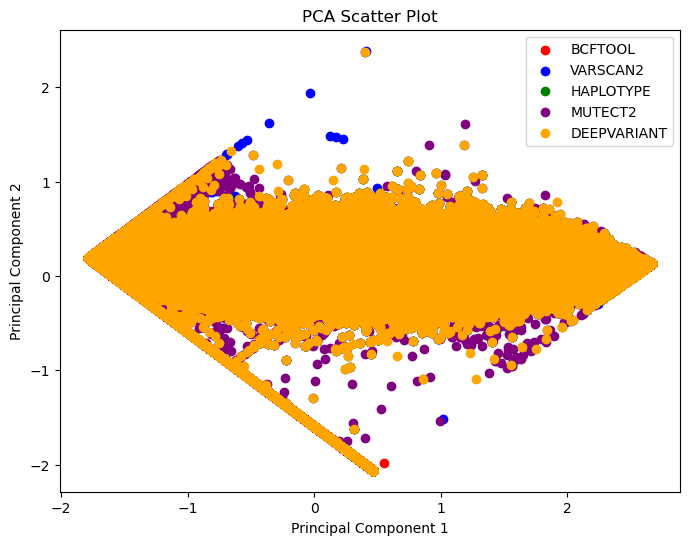

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load and combine data from five tools into a single DataFrame
tool1_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_qual_filter_cov_AF_SAS_AF.tsv', delimiter='\t')
tool1_data['Tool'] = 'BCFTOOL'

tool2_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_varscan_cov_AF_SAS_AF.tsv', delimiter='\t')
tool2_data['Tool'] = 'VARSCAN2'

tool3_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', delimiter='\t')
tool3_data['Tool'] = 'HAPLOTYPE'

tool4_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Mutect2_cov_AF_SAS_AF.tsv', delimiter='\t')
tool4_data['Tool'] = 'MUTECT2'

tool5_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_deep_variant_cov_AF_SAS_AF.tsv', delimiter='\t')
tool5_data['Tool'] = 'DEEPVARIANT'

# Concatenate all DataFrames into a single dataset
combined_data = pd.concat([tool1_data, tool2_data, tool3_data, tool4_data, tool5_data])

# Extract numerical columns for PCA
numerical_columns = ['gnomADg_AF', 'gnomADg_SAS_AF']

# Standardize the numerical columns
scaler = StandardScaler()
combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

# Perform PCA
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(combined_data[numerical_columns])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance:", explained_variance)

# Specify colors for each tool
colors = {
    'BCFTOOL': 'red',
    'VARSCAN2': 'blue',
    'HAPLOTYPE': 'green',
    'MUTECT2': 'purple',
    'DEEPVARIANT': 'orange'
}

# Create a scatter plot with specified colors
plt.figure(figsize=(8, 6))
for tool, color in colors.items():
    subset = principal_components[combined_data['Tool'] == tool]
    plt.scatter(subset[:, 0], subset[:, 1], label=tool, c=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

Explained Variance: [0.89766094 0.10233906]


C:\Users\GenepoweRx_Madhu\AppData\Local\Temp\ipykernel_13132\2440644607.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust subplot spacing


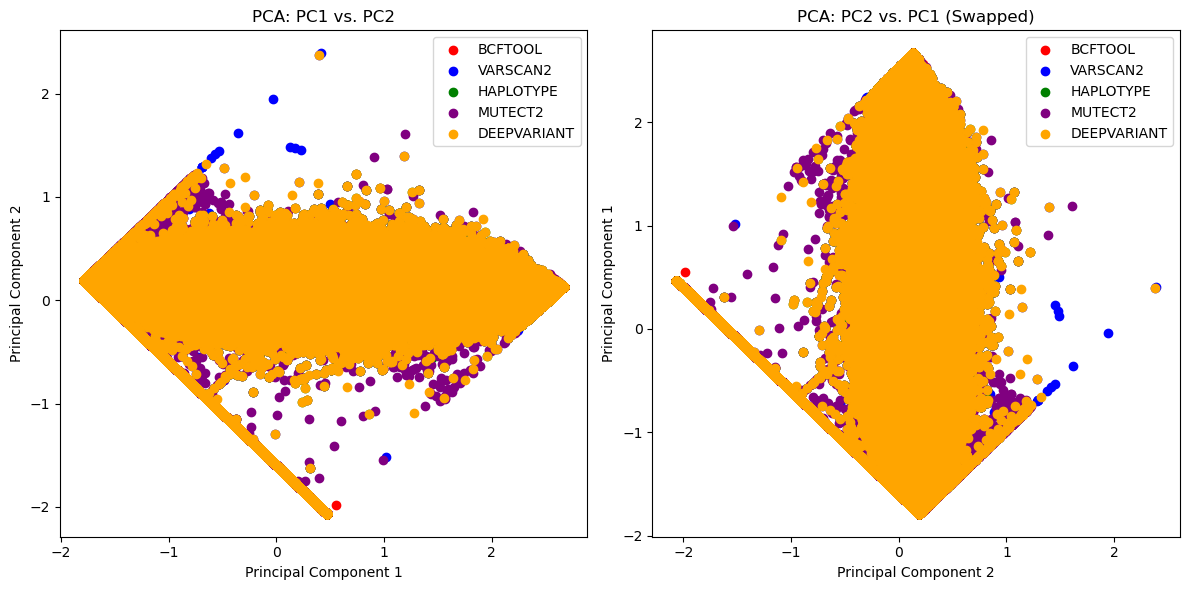

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load and combine data from five tools into a single DataFrame
tool1_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_qual_filter_cov_AF_SAS_AF.tsv', delimiter='\t')
tool1_data['Tool'] = 'BCFTOOL'

tool2_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_varscan_cov_AF_SAS_AF.tsv', delimiter='\t')
tool2_data['Tool'] = 'VARSCAN2'

tool3_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', delimiter='\t')
tool3_data['Tool'] = 'HAPLOTYPE'

tool4_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Mutect2_cov_AF_SAS_AF.tsv', delimiter='\t')
tool4_data['Tool'] = 'MUTECT2'

tool5_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_deep_variant_cov_AF_SAS_AF.tsv', delimiter='\t')
tool5_data['Tool'] = 'DEEPVARIANT'

# Concatenate all DataFrames into a single dataset
combined_data = pd.concat([tool1_data, tool2_data, tool3_data, tool4_data, tool5_data])

# Extract numerical columns for PCA
numerical_columns = ['gnomADg_AF', 'gnomADg_SAS_AF']

# Standardize the numerical columns
scaler = StandardScaler()
combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

# Perform PCA with 2 components (maximum possible)
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(combined_data[numerical_columns])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance:", explained_variance)

# Create scatter plots for PC1 vs. PC2 with colors
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Define colors for each tool
tool_colors = {
    'BCFTOOL': 'red',
    'VARSCAN2': 'blue',
    'HAPLOTYPE': 'green',
    'MUTECT2': 'purple',
    'DEEPVARIANT': 'orange'
}

# PC1 vs. PC2
plt.subplot(121)  # 1 row, 2 columns, plot 1
for tool, color in tool_colors.items():
    subset = principal_components[combined_data['Tool'] == tool]
    plt.scatter(subset[:, 0], subset[:, 1], label=tool, c=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs. PC2')
plt.legend()

# PC2 vs. PC1 (swapped for variety)
plt.subplot(122)  # 1 row, 2 columns, plot 2
for tool, color in tool_colors.items():
    subset = principal_components[combined_data['Tool'] == tool]
    plt.scatter(subset[:, 1], subset[:, 0], label=tool, c=color)

plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 1')
plt.title('PCA: PC2 vs. PC1 (Swapped)')
plt.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.show()

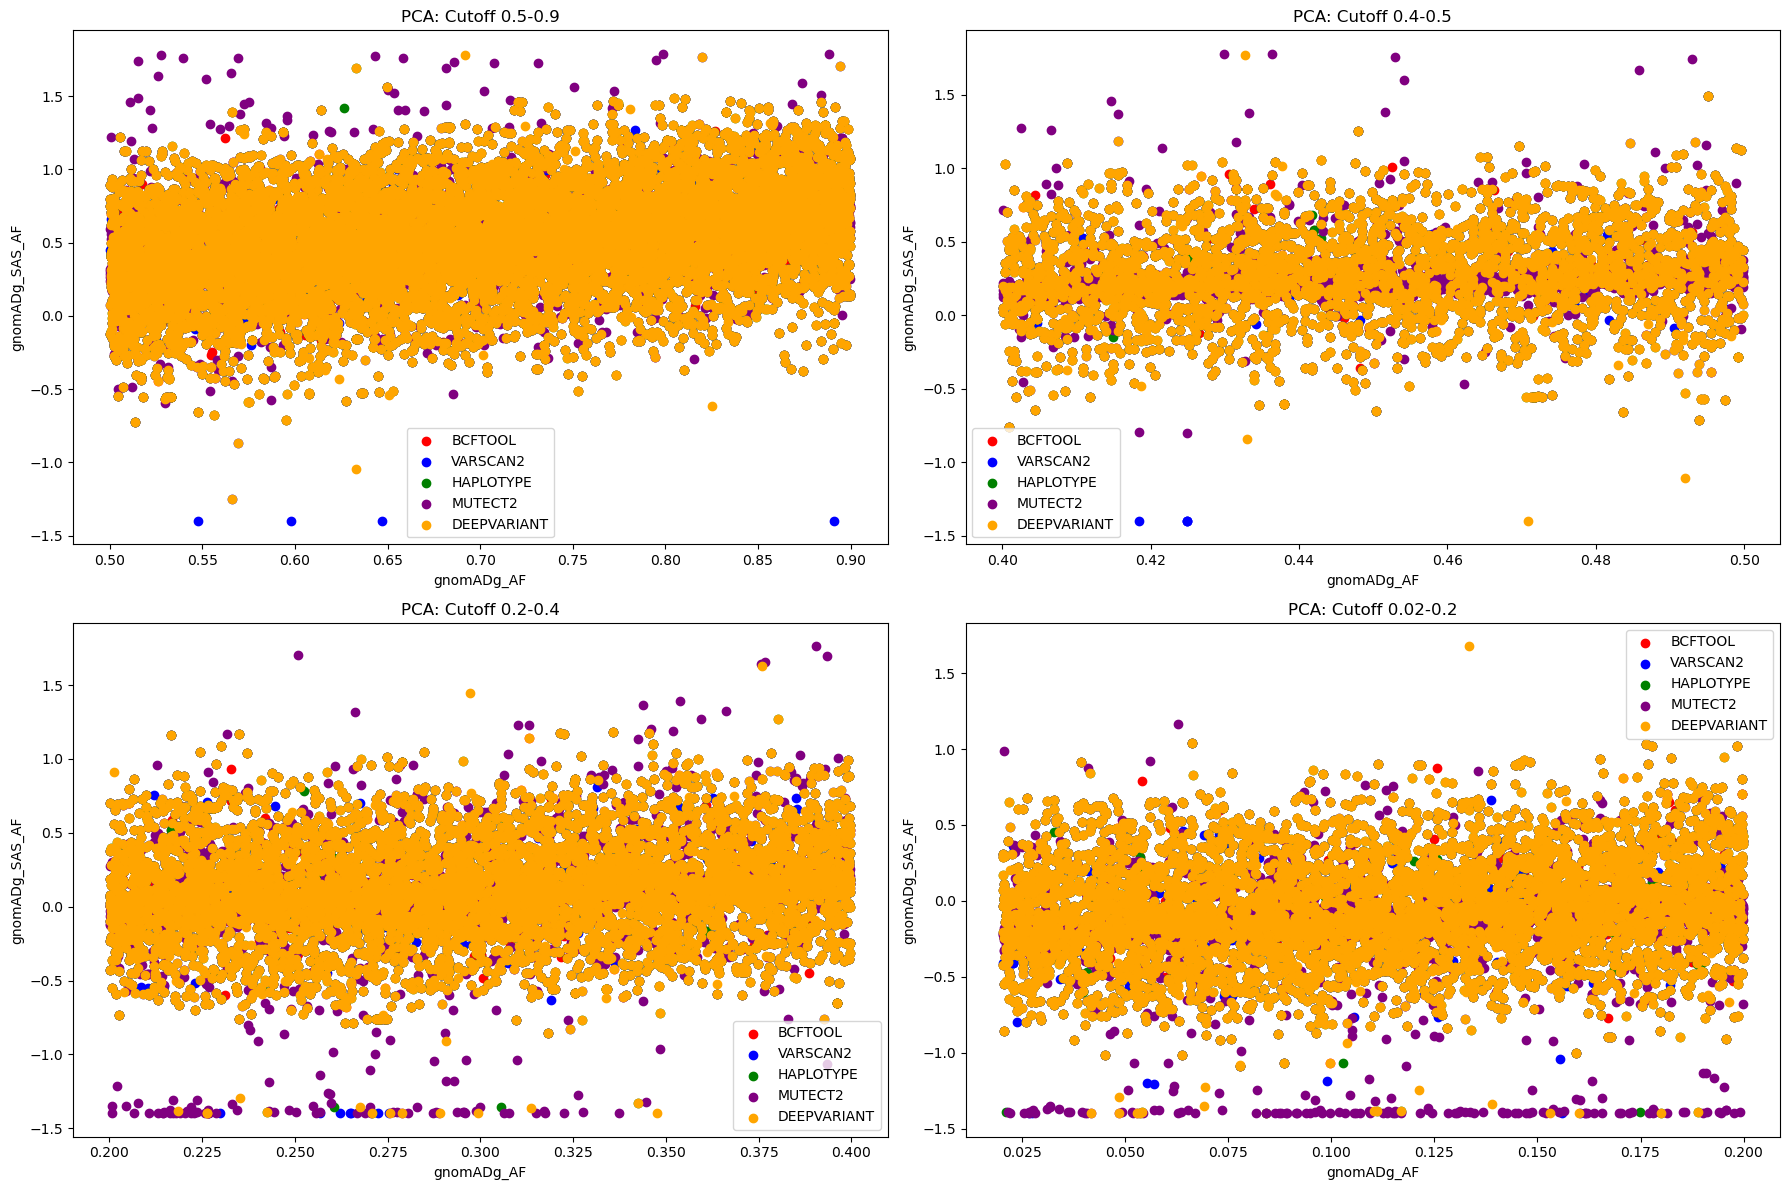

In [21]:
# Load and combine data from five tools into a single DataFrame
tool1_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_qual_filter_cov_AF_SAS_AF.tsv', delimiter='\t')
tool1_data['Tool'] = 'BCFTOOL'

tool2_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_varscan_cov_AF_SAS_AF.tsv', delimiter='\t')
tool2_data['Tool'] = 'VARSCAN2'

tool3_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', delimiter='\t')
tool3_data['Tool'] = 'HAPLOTYPE'

tool4_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Mutect2_cov_AF_SAS_AF.tsv', delimiter='\t')
tool4_data['Tool'] = 'MUTECT2'

tool5_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_deep_variant_cov_AF_SAS_AF.tsv', delimiter='\t')
tool5_data['Tool'] = 'DEEPVARIANT'

# Concatenate all DataFrames into a single dataset
combined_data = pd.concat([tool1_data, tool2_data, tool3_data, tool4_data, tool5_data])

# Extract numerical columns for PCA
numerical_columns = ['gnomADg_AF', 'gnomADg_SAS_AF']

# Standardize the numerical columns
scaler = StandardScaler()
combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

# Define cutoff ranges
cutoff_ranges = [
    (0.5, 0.9),
    (0.4, 0.5),
    (0.2, 0.4),
    (0.02, 0.2)
]

# Create scatter plots for each cutoff range with colors
plt.figure(figsize=(18, 12))  # Adjust the figure size as needed

for i, (cutoff_min, cutoff_max) in enumerate(cutoff_ranges, start=1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, plot i
    for tool, color in tool_colors.items():
        subset = combined_data[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max)]
        plt.scatter(subset['gnomADg_AF'], subset['gnomADg_SAS_AF'], label=tool, c=color)

    plt.xlabel('gnomADg_AF')
    plt.ylabel('gnomADg_SAS_AF')
    plt.title(f'PCA: Cutoff {cutoff_min}-{cutoff_max}')
    plt.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.show()

Explained Variance: [0.89766094 0.10233906]


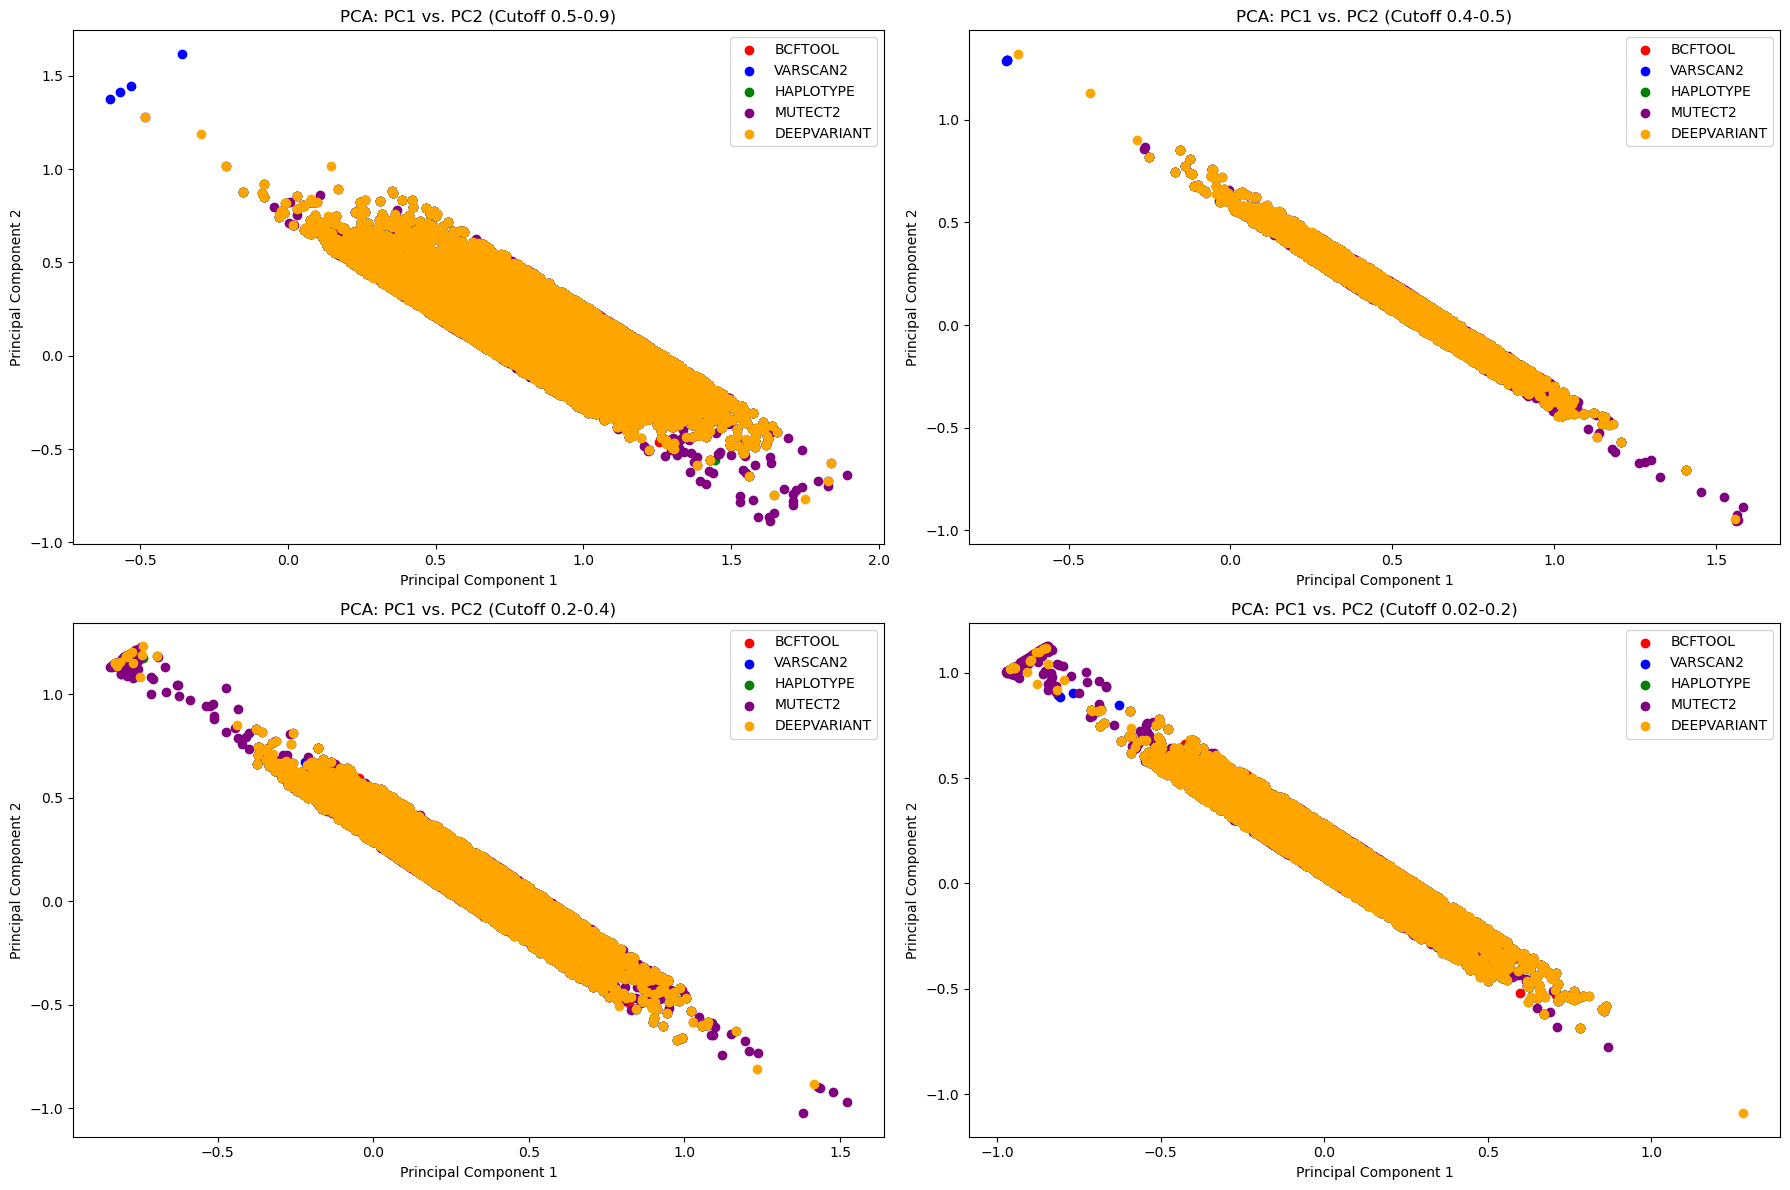

In [22]:
# Load and combine data from five tools into a single DataFrame
tool1_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_qual_filter_cov_AF_SAS_AF.tsv', delimiter='\t')
tool1_data['Tool'] = 'BCFTOOL'

tool2_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_varscan_cov_AF_SAS_AF.tsv', delimiter='\t')
tool2_data['Tool'] = 'VARSCAN2'

tool3_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', delimiter='\t')
tool3_data['Tool'] = 'HAPLOTYPE'

tool4_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Mutect2_cov_AF_SAS_AF.tsv', delimiter='\t')
tool4_data['Tool'] = 'MUTECT2'

tool5_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_deep_variant_cov_AF_SAS_AF.tsv', delimiter='\t')
tool5_data['Tool'] = 'DEEPVARIANT'

# Concatenate all DataFrames into a single dataset
combined_data = pd.concat([tool1_data, tool2_data, tool3_data, tool4_data, tool5_data])

# Extract numerical columns for PCA
numerical_columns = ['gnomADg_AF', 'gnomADg_SAS_AF']

# Standardize the numerical columns
scaler = StandardScaler()
combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

# Perform PCA with 2 components (maximum possible)
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(combined_data[numerical_columns])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance:", explained_variance)

# Define cutoff ranges
cutoff_ranges = [
    (0.5, 0.9),
    (0.4, 0.5),
    (0.2, 0.4),
    (0.02, 0.2)
]

# Create scatter plots for PC1 vs. PC2 for each cutoff range with colors
plt.figure(figsize=(18, 12))  # Adjust the figure size as needed

for i, (cutoff_min, cutoff_max) in enumerate(cutoff_ranges, start=1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, plot i
    for tool, color in tool_colors.items():
        subset = combined_data[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max)]
        pc1_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 0]
        pc2_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 1]
        plt.scatter(pc1_subset, pc2_subset, label=tool, c=color)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA: PC1 vs. PC2 (Cutoff {cutoff_min}-{cutoff_max})')
    plt.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.show()

Explained Variance: [0.89766094 0.10233906]


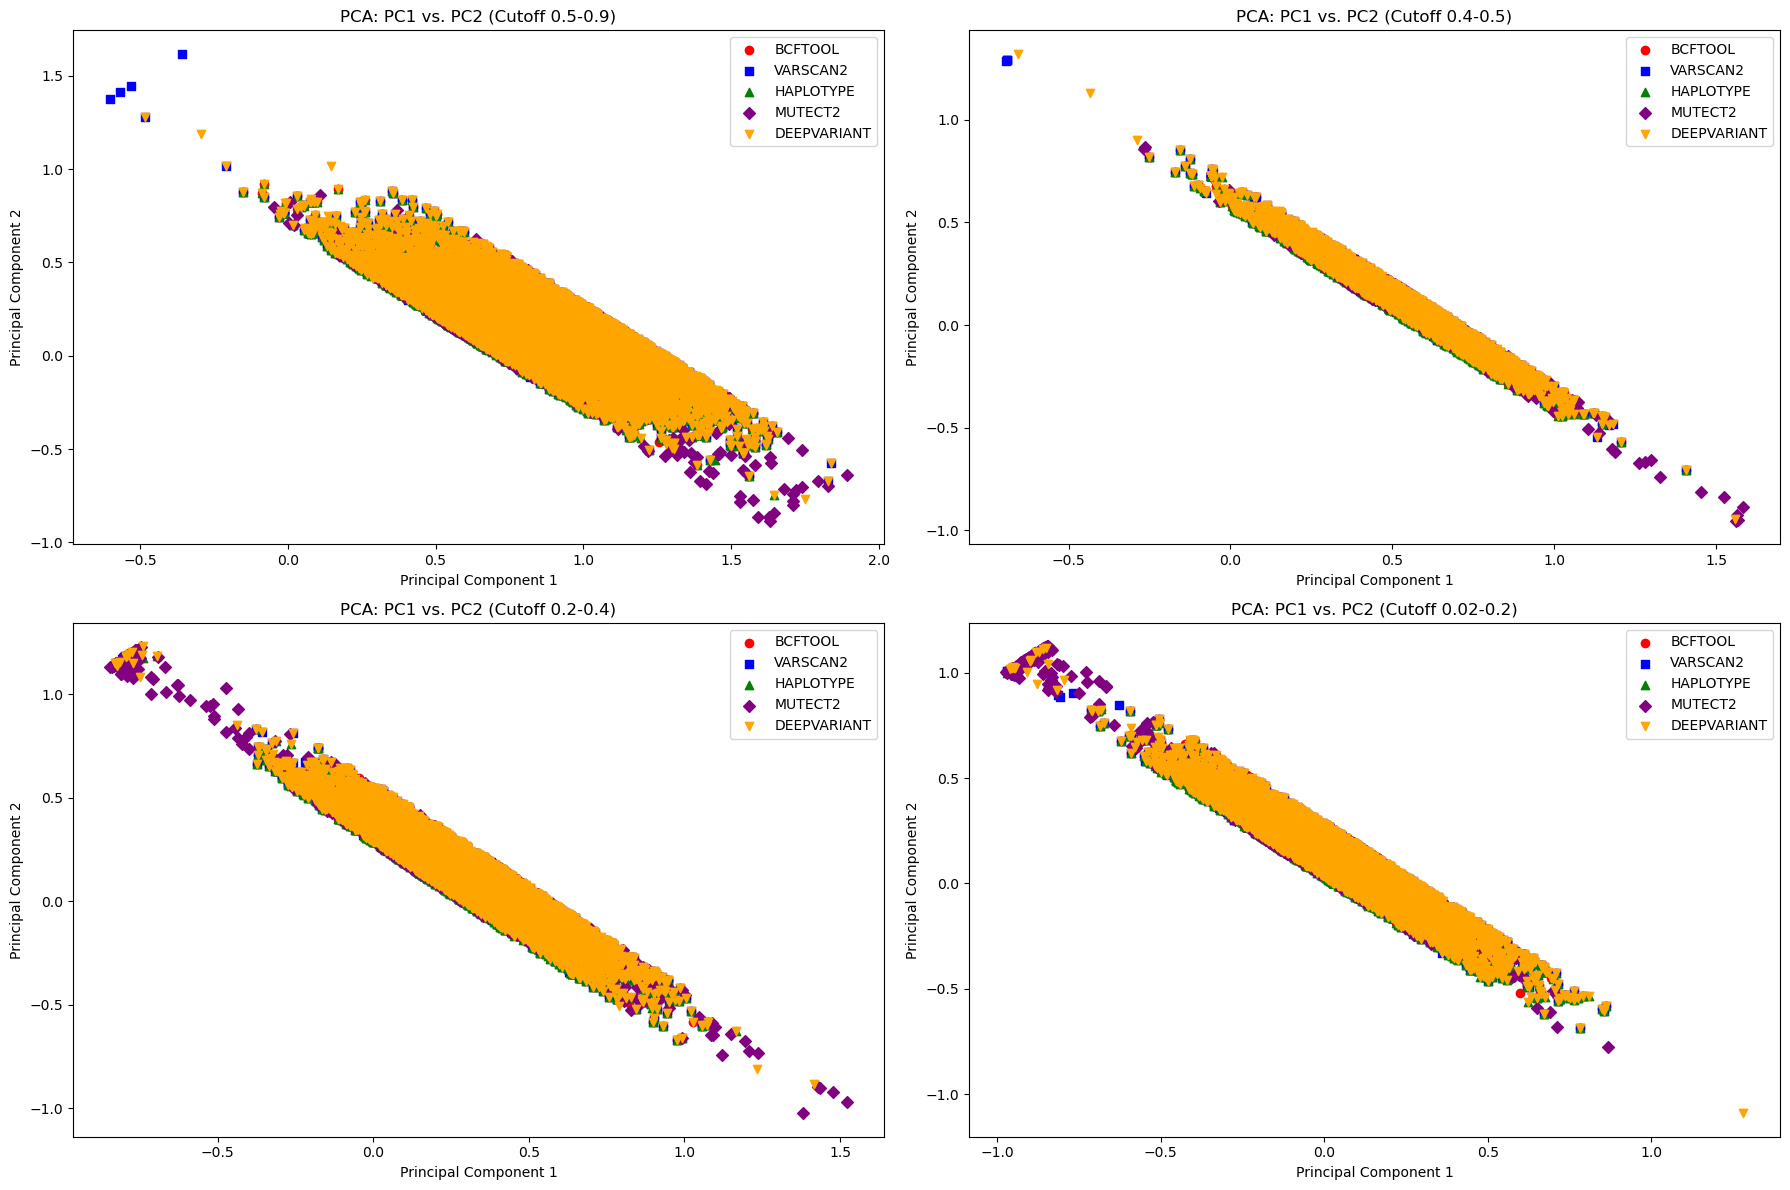

In [25]:
# Load and combine data from five tools into a single DataFrame
tool1_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_qual_filter_cov_AF_SAS_AF.tsv', delimiter='\t')
tool1_data['Tool'] = 'BCFTOOL'

tool2_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_varscan_cov_AF_SAS_AF.tsv', delimiter='\t')
tool2_data['Tool'] = 'VARSCAN2'

tool3_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', delimiter='\t')
tool3_data['Tool'] = 'HAPLOTYPE'

tool4_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Mutect2_cov_AF_SAS_AF.tsv', delimiter='\t')
tool4_data['Tool'] = 'MUTECT2'

tool5_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_deep_variant_cov_AF_SAS_AF.tsv', delimiter='\t')
tool5_data['Tool'] = 'DEEPVARIANT'

# Concatenate all DataFrames into a single dataset
combined_data = pd.concat([tool1_data, tool2_data, tool3_data, tool4_data, tool5_data])

# Extract numerical columns for PCA
numerical_columns = ['gnomADg_AF', 'gnomADg_SAS_AF']

# Standardize the numerical columns
scaler = StandardScaler()
combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

# Perform PCA with 2 components (maximum possible)
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(combined_data[numerical_columns])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance:", explained_variance)

# Define cutoff ranges
cutoff_ranges = [
    (0.5, 0.9),
    (0.4, 0.5),
    (0.2, 0.4),
    (0.02, 0.2)
]

# Create scatter plots for PC1 vs. PC2 for each cutoff range with different shapes and colors
plt.figure(figsize=(18, 12))  # Adjust the figure size as needed

# Define marker styles and colors for each tool
marker_styles = ['o', 's', '^', 'D', 'v']
tool_colors = {
    'BCFTOOL': 'red',
    'VARSCAN2': 'blue',
    'HAPLOTYPE': 'green',
    'MUTECT2': 'purple',
    'DEEPVARIANT': 'orange'
}

for i, (cutoff_min, cutoff_max) in enumerate(cutoff_ranges, start=1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, plot i
    for j, (tool, color) in enumerate(tool_colors.items()):
        subset = combined_data[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max)]
        pc1_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 0]
        pc2_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 1]
        plt.scatter(pc1_subset, pc2_subset, label=tool, c=color, marker=marker_styles[j])

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA: PC1 vs. PC2 (Cutoff {cutoff_min}-{cutoff_max})')
    plt.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.show()

Explained Variance (Percentage): [0.89766094 0.10233906]
Explained Variance (Original Scale): [1.79532605 0.20467859]


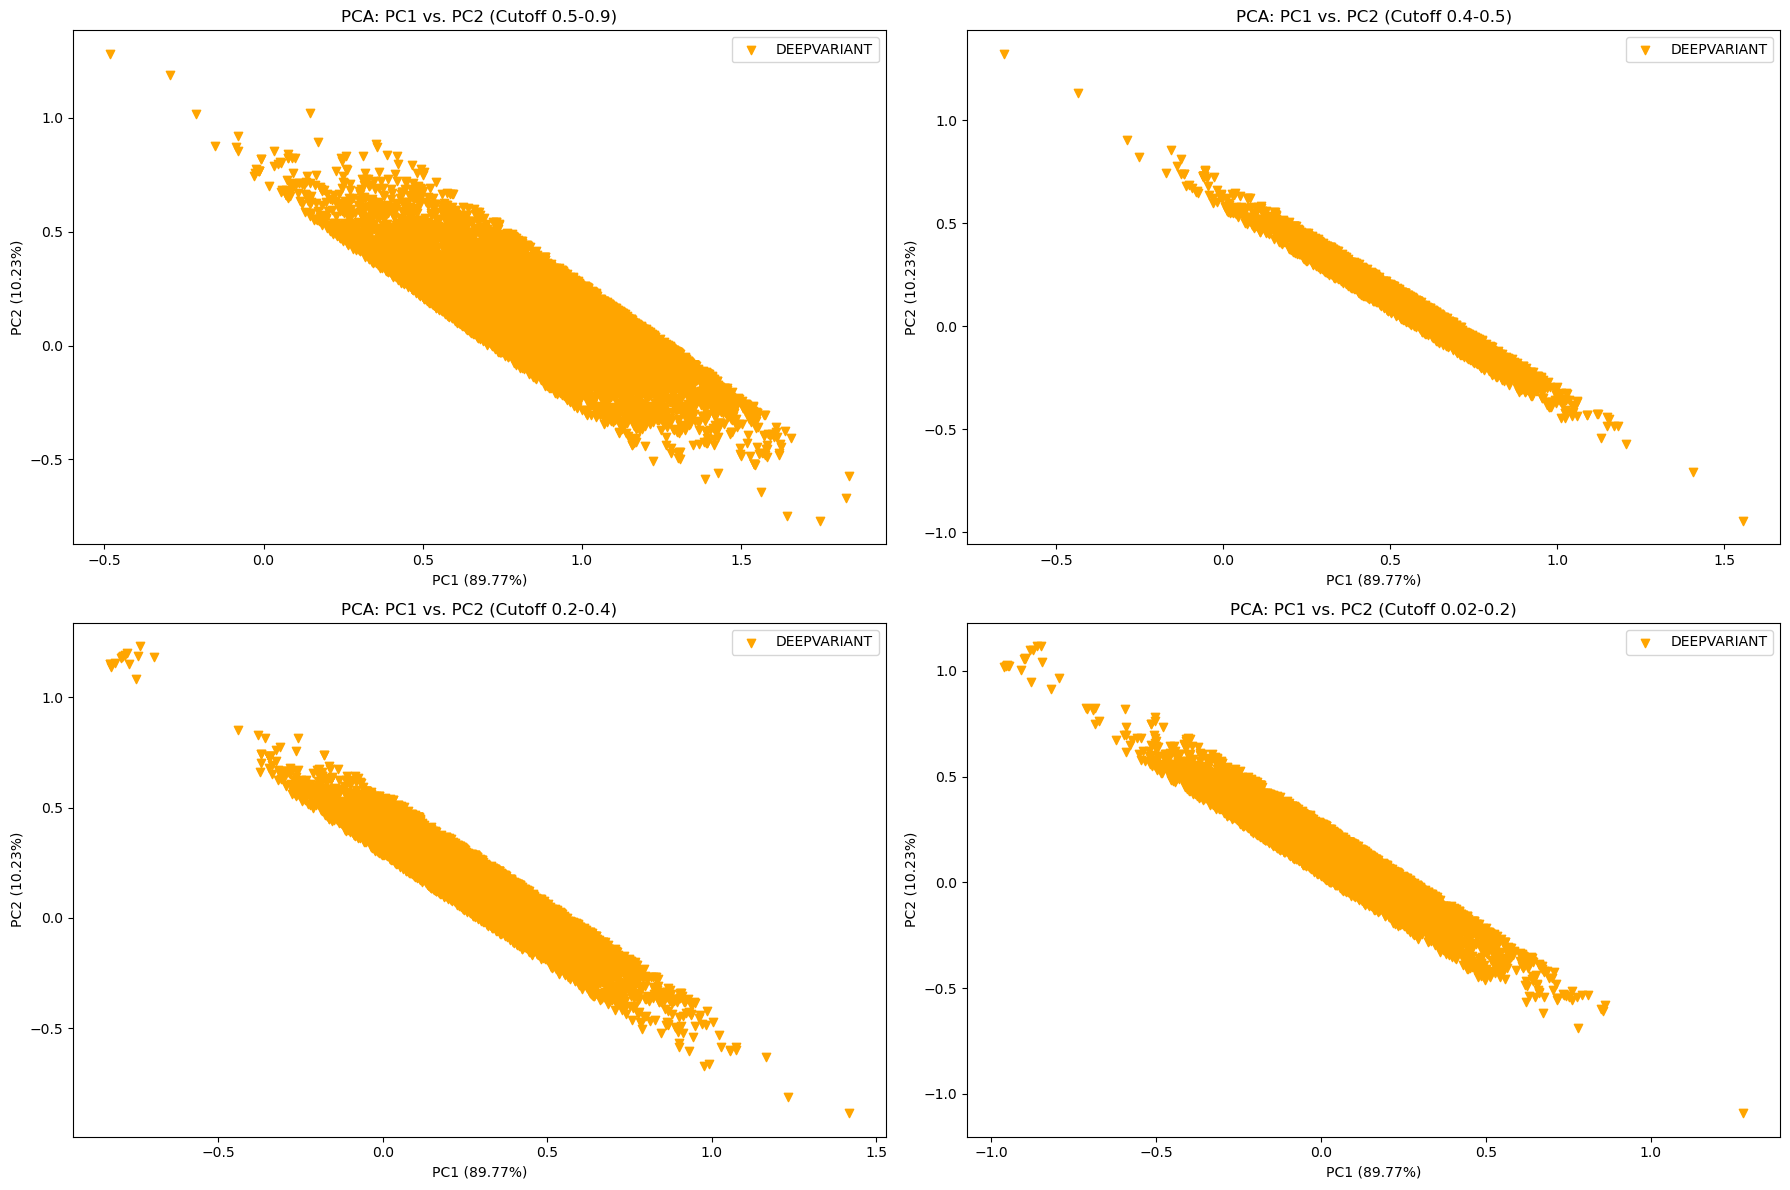

In [36]:
# Load and combine data from five tools into a single DataFrame
tool1_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_qual_filter_cov_AF_SAS_AF.tsv', delimiter='\t')
tool1_data['Tool'] = 'BCFTOOL'

tool2_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_varscan_cov_AF_SAS_AF.tsv', delimiter='\t')
tool2_data['Tool'] = 'VARSCAN2'

tool3_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', delimiter='\t')
tool3_data['Tool'] = 'HAPLOTYPE'

tool4_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Mutect2_cov_AF_SAS_AF.tsv', delimiter='\t')
tool4_data['Tool'] = 'MUTECT2'

tool5_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_deep_variant_cov_AF_SAS_AF.tsv', delimiter='\t')
tool5_data['Tool'] = 'DEEPVARIANT'

# Concatenate all DataFrames into a single dataset
combined_data = pd.concat([tool1_data, tool2_data, tool3_data, tool4_data, tool5_data])

# Extract numerical columns for PCA
numerical_columns = ['gnomADg_AF', 'gnomADg_SAS_AF']

# Standardize the numerical columns
scaler = StandardScaler()
combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

# Perform PCA with 2 components (maximum possible)
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(combined_data[numerical_columns])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance (Percentage):", explained_variance)
print("Explained Variance (Original Scale):", pca.explained_variance_)

# Define cutoff ranges
cutoff_ranges = [
    (0.5, 0.9),
    (0.4, 0.5),
    (0.2, 0.4),
    (0.02, 0.2)
]

# Create scatter plots for PC1 vs. PC2 for each cutoff range with different shapes and colors
plt.figure(figsize=(18, 12))  # Adjust the figure size as needed

# Define marker styles and colors for each tool
marker_styles = ['o', 's', '^', 'D', 'v']
tool_colors = {
    'BCFTOOL': 'red',
    'VARSCAN2': 'blue',
    'HAPLOTYPE': 'green',
    'MUTECT2': 'purple',
    'DEEPVARIANT': 'orange'
}

# Specify the tool to project (VARSCAN2 in this case)
tool_to_project = 'DEEPVARIANT'

for i, (cutoff_min, cutoff_max) in enumerate(cutoff_ranges, start=1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, plot i
    for j, (tool, color) in enumerate(tool_colors.items()):
        if tool == tool_to_project:
            subset = combined_data[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max)]
            pc1_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 0]
            pc2_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 1]
            plt.scatter(pc1_subset, pc2_subset, label=tool, c=color, marker=marker_styles[j])

    plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
    plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
    plt.title(f'PCA: PC1 vs. PC2 (Cutoff {cutoff_min}-{cutoff_max})')
    plt.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/DEEPVARIANT_plot.jpg', dpi =2000, bbox_inches='tight')
plt.show()

Explained Variance: [0.89766094 0.10233906]


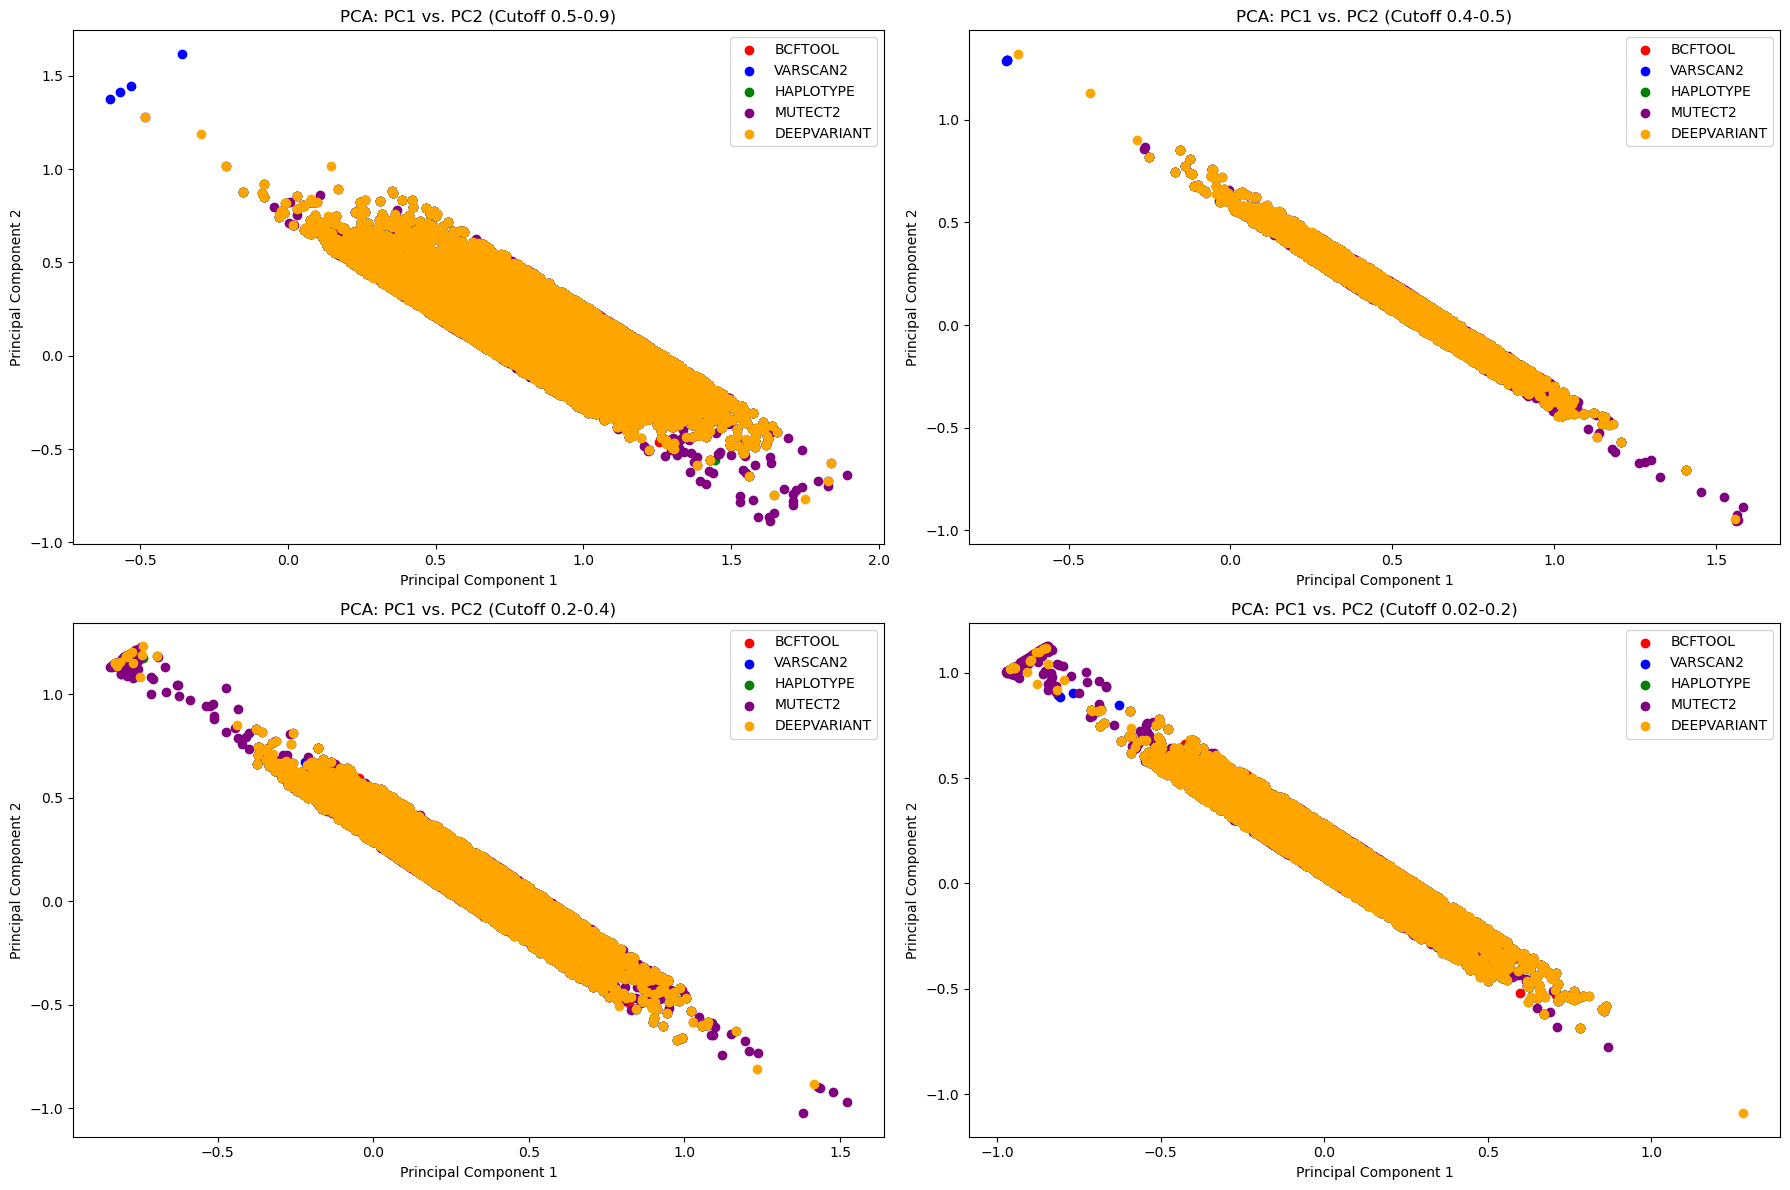

BCFTOOL: Explained Variance = 1.00
VARSCAN2: Explained Variance = 1.00
HAPLOTYPE: Explained Variance = 1.00
MUTECT2: Explained Variance = 1.00
DEEPVARIANT: Explained Variance = 1.00


In [24]:
# Load and combine data from five tools into a single DataFrame
tool1_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_qual_filter_cov_AF_SAS_AF.tsv', delimiter='\t')
tool1_data['Tool'] = 'BCFTOOL'

tool2_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_varscan_cov_AF_SAS_AF.tsv', delimiter='\t')
tool2_data['Tool'] = 'VARSCAN2'

tool3_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Haplotype_cov_AF_SAS_AF.tsv', delimiter='\t')
tool3_data['Tool'] = 'HAPLOTYPE'

tool4_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_Mutect2_cov_AF_SAS_AF.tsv', delimiter='\t')
tool4_data['Tool'] = 'MUTECT2'

tool5_data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/12652712_deep_variant_cov_AF_SAS_AF.tsv', delimiter='\t')
tool5_data['Tool'] = 'DEEPVARIANT'

# Concatenate all DataFrames into a single dataset
combined_data = pd.concat([tool1_data, tool2_data, tool3_data, tool4_data, tool5_data])

# Extract numerical columns for PCA
numerical_columns = ['gnomADg_AF', 'gnomADg_SAS_AF']

# Standardize the numerical columns
scaler = StandardScaler()
combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

# Perform PCA with 2 components (maximum possible)
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(combined_data[numerical_columns])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance:", explained_variance)

# Define cutoff ranges
cutoff_ranges = [
    (0.5, 0.9),
    (0.4, 0.5),
    (0.2, 0.4),
    (0.02, 0.2)
]

# Create scatter plots for PC1 vs. PC2 for each cutoff range with colors
plt.figure(figsize=(18, 12))  # Adjust the figure size as needed

for i, (cutoff_min, cutoff_max) in enumerate(cutoff_ranges, start=1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, plot i
    for tool, color in tool_colors.items():
        subset = combined_data[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max)]
        pc1_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 0]
        pc2_subset = principal_components[(combined_data['Tool'] == tool) & (combined_data['gnomADg_AF'] >= cutoff_min) & (combined_data['gnomADg_AF'] < cutoff_max), 1]
        plt.scatter(pc1_subset, pc2_subset, label=tool, c=color)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA: PC1 vs. PC2 (Cutoff {cutoff_min}-{cutoff_max})')
    plt.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.show()

# Calculate and print explained variance for each tool
tool_explained_variance = {}

for tool in tool_colors.keys():
    tool_data = combined_data[combined_data['Tool'] == tool]
    tool_pca = PCA(n_components=n_components)
    tool_principal_components = tool_pca.fit_transform(tool_data[numerical_columns])
    explained_variance = sum(tool_pca.explained_variance_ratio_)
    tool_explained_variance[tool] = explained_variance

# Print the explained variance for each tool
for tool, variance in tool_explained_variance.items():
    print(f"{tool}: Explained Variance = {variance:.2f}")

In [52]:
vcf.gnomADg_SAS_AF.min()

0.0

In [66]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/12652712_Mutect2_cov_SAS_AF.tsv', sep = '\t')
vcf

CHROM        POS                    rsID REF       ALT QUAL  \
0      chr1     817416             rs148649543   C         T    .   
1      chr1     930314               rs9988179   C         T    .   
2      chr1     930939               rs9988021   G         A    .   
3      chr1     931131  rs375757231;rs60722469   C     CCCCT    .   
4      chr1     935835              rs28419423   C         G    .   
...     ...        ...                     ...  ..       ...  ...   
88498  chrX  155090922                       .   T  TAATGTAG    .   
88499  chrX  155228363             rs781912204   A    AT,ATT    .   
88500  chrX  155277884                rs559165   G         T    .   
88501  chrX  155545002               rs2305517   G         A    .   
88502  chrX  155545046               rs2305518   C         T    .   

              FILTER                                               INFO  \
0               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=49,11|16,9;DP...   
1               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=11,20|14,22;D...   
2               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=0,0|35,12;DP=...   
3           slippage  AS_FilterStatus=SITE;AS_SB_TABLE=3,6|2,5;DP=28...   
4               PASS  AS_FilterStatus=SITE;AS_SB_TABLE=5,16|7,10;DP=...   
...              ...                                                ...   
88498  weak_evidence  AS_FilterStatus=weak_evidence;AS_SB_TABLE=6,42...   
88499   multiallelic  AS_FilterStatus=SITE|weak_evidence;AS_SB_TABLE...   
88500           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=19,10|28,18;D...   
88501           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=21,7|19,4;DP=...   
88502           PASS  AS_FilterStatus=SITE;AS_SB_TABLE=30,11|25,9;DP...   

       gnomADg_SAS_AF  
0             0.04895  
1             0.02732  
2             0.99690  
3             0.56160  
4             0.03270  
...               ...  
88498         0.00000  
88499         0.65810  
88500         0.71760  
88501         0.67960  
88502         0.72150  

[88503 rows x 9 columns]

In [79]:
X = vcf[['gnomADg_SAS_AF']]
X

gnomADg_SAS_AF
0             0.04895
1             0.02732
2             0.99690
3             0.56160
4             0.03270
...               ...
88498         0.00000
88499         0.65810
88500         0.71760
88501         0.67960
88502         0.72150

[88503 rows x 1 columns]

In [80]:
X_mean = X.mean()
X_std = X.std()

# Standardize the data
Z = (X - X_mean) / X_std
Z

gnomADg_SAS_AF
0           -1.227081
1           -1.295650
2            1.778008
3            0.398067
4           -1.278595
...               ...
88498       -1.382257
88499        0.703981
88500        0.892601
88501        0.772138
88502        0.904965

[88503 rows x 1 columns]

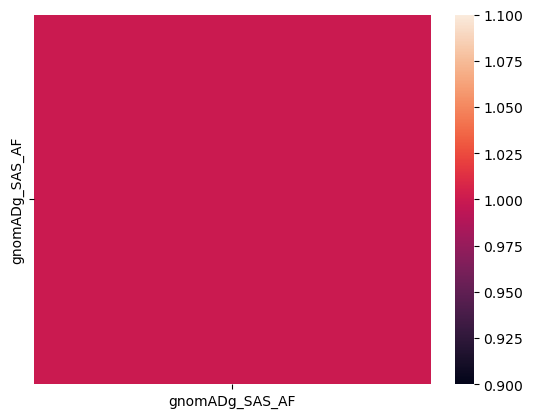

In [81]:
# covariance
c = Z.cov()

# Plot the covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(c)
plt.show()

In [82]:
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

Eigen values:
 [1.]
Eigen values Shape: (1,)
Eigen Vector Shape: (1, 1)


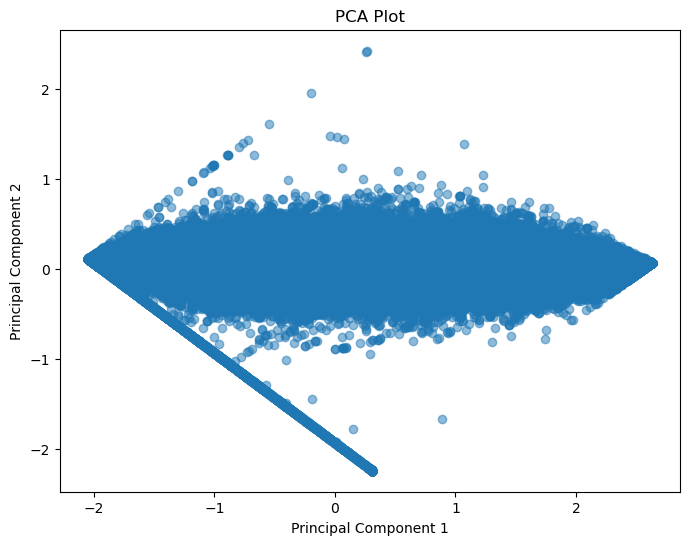

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Define the folder path containing your TSV files
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/'  # Update with your actual folder path

# Step 2: Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Step 3: Iterate through files in the folder, load, and combine the data
for filename in os.listdir(folder_path):
    if filename.endswith('.tsv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t')
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Step 4: Define the columns for PCA and standardize the data
data_for_pca = combined_data[['gnomADg_AF', 'gnomADg_SAS_AF']]  # Adjust the columns as needed
scaler = StandardScaler()
data_for_pca_scaled = scaler.fit_transform(data_for_pca)

# Step 5: Perform PCA
pca = PCA(n_components=2)  # You can choose the number of components you want
principal_components = pca.fit_transform(data_for_pca_scaled)

# Step 6: Add principal components back to the DataFrame
combined_data['PC1'] = principal_components[:, 0]
combined_data['PC2'] = principal_components[:, 1]

# Step 7: Visualization (Optional)
plt.figure(figsize=(8, 6))
plt.scatter(combined_data['PC1'], combined_data['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.show()

# Step 8: Save Results (Optional)
#output_file = 'combined_pca_results.tsv'
#combined_data.to_csv(output_file, sep='\t', index=False)

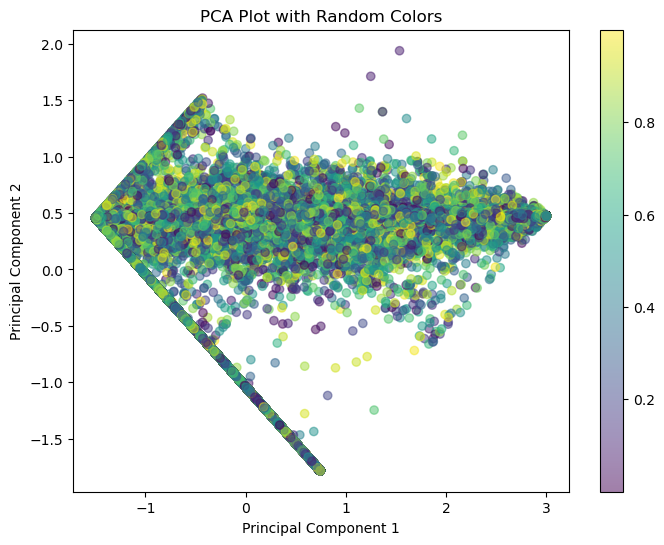

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Define the folder path containing your TSV files
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712/TSV_MAF_data/tsv/'  # Update with your actual folder path

# Step 2: Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Step 3: Iterate through files in the folder, load, and combine the data
for filename in os.listdir(folder_path):
    if filename.endswith('.tsv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t')
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Step 4: Define the columns for PCA and standardize the data
data_for_pca = combined_data[['gnomADg_AF', 'gnomADg_SAS_AF']]  # Adjust the columns as needed
scaler = StandardScaler()
data_for_pca_scaled = scaler.fit_transform(data_for_pca)

# Step 5: Perform PCA
pca = PCA(n_components=2)  # You can choose the number of components you want
principal_components = pca.fit_transform(data_for_pca_scaled)

# Step 6: Add principal components back to the DataFrame
combined_data['PC1'] = principal_components[:, 0]
combined_data['PC2'] = principal_components[:, 1]

# Step 7: Generate random colors for the data points
n_data_points = len(combined_data)
colors = np.random.rand(n_data_points)

# Step 8: Visualization with random colors
plt.figure(figsize=(8, 6))
plt.scatter(combined_data['PC1'], combined_data['PC2'], c=colors, alpha=0.5, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot with Random Colors')
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Step 9: Save Results (Optional)
# output_file = 'combined_pca_results.tsv'
# combined_data.to_csv(output_file, sep='\t', index=False)


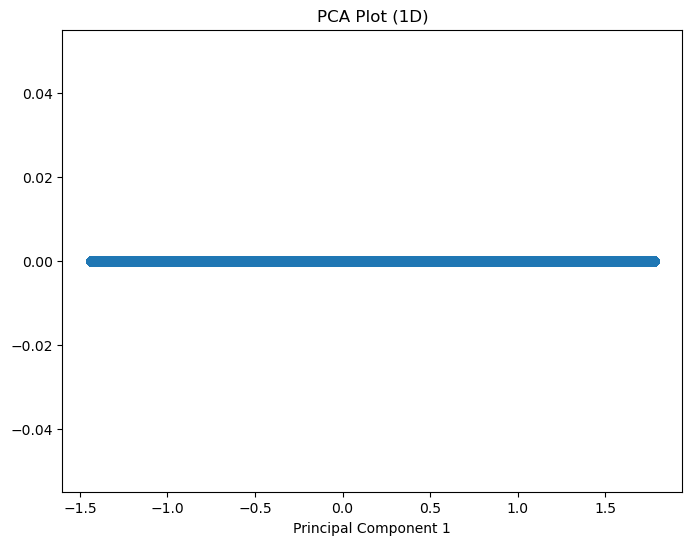

In [65]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Define the folder path containing your TSV files
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/TSV_MAF_data/'

# Step 2: Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Step 3: Iterate through files in the folder, load, and combine the data
for filename in os.listdir(folder_path):
    if filename.endswith('.tsv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t')
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Step 4: Define the columns for PCA and standardize the data
data_for_pca = combined_data[['gnomADg_SAS_AF']]  # Using only one feature
scaler = StandardScaler()
data_for_pca_scaled = scaler.fit_transform(data_for_pca)

# Step 5: Perform PCA with one component
pca = PCA(n_components=1)  # You can choose 1 component
principal_components = pca.fit_transform(data_for_pca_scaled)

# Step 6: Add the principal component back to the DataFrame
combined_data['PC1'] = principal_components[:, 0]

# Step 7: Visualization (Optional)
plt.figure(figsize=(8, 6))
plt.scatter(combined_data['PC1'], np.zeros_like(combined_data['PC1']), alpha=0.5)  # Note: Y-values set to 0 for 1D scatter plot
plt.xlabel('Principal Component 1')
plt.title('PCA Plot (1D)')
plt.show()

# Step 8: Save Results (Optional)
# output_file = 'combined_pca_results.tsv'
# combined_data.to_csv(output_file, sep='\t', index=False)

In [ ]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652712_Mutect2_cov.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf

In [ ]:
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2]


In [10]:
vcf['gnomADg_SAS_AF'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].str.split('|').str[67]
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
vcf

CHROM       POS       rsID REF ALT QUAL FILTER  \
0      chr1     69511  rs2691305   A   G    .   PASS   
1      chr1    817514  rs3131971   T   C    .   PASS   
2      chr1    826893  rs3115849   G   A    .   PASS   
3      chr1    827209  rs3115848   G   C    .   PASS   
4      chr1    827212  rs3131950   C   G    .   PASS   
...     ...       ...        ...  ..  ..  ...    ...   
69181  chrY  57084531          .   A   G    .   PASS   
69182  chrY  57128393          .   G   C    .   PASS   
69183  chrY  57184462          .   T   G    .   PASS   
69184  chrY  57189953          .   T   C    .   PASS   
69185  chrY  57191772          .   C   T    .   PASS   

                                                    INFO gnomADg_SAS_AF  
0      ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...         0.9772  
1      ADP=368;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2468,0...         0.7639  
2      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....         0.8283  
3      ADP=125;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...         0.8256  
4      ADP=128;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...         0.8265  
...                                                  ...            ...  
69181  ADP=62;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...                 
69182  ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...                 
69183  ADP=43;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...                 
69184  ADP=50;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_poly...                 
69185  ADP=76;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...                 

[69186 rows x 9 columns]

In [14]:
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].replace('', 0)
vcf['gnomADg_SAS_AF'] = vcf['gnomADg_SAS_AF'].astype('float')
vcf

CHROM       POS       rsID REF ALT QUAL FILTER  \
0      chr1     69511  rs2691305   A   G    .   PASS   
1      chr1    817514  rs3131971   T   C    .   PASS   
2      chr1    826893  rs3115849   G   A    .   PASS   
3      chr1    827209  rs3115848   G   C    .   PASS   
4      chr1    827212  rs3131950   C   G    .   PASS   
...     ...       ...        ...  ..  ..  ...    ...   
69181  chrY  57084531          .   A   G    .   PASS   
69182  chrY  57128393          .   G   C    .   PASS   
69183  chrY  57184462          .   T   G    .   PASS   
69184  chrY  57189953          .   T   C    .   PASS   
69185  chrY  57191772          .   C   T    .   PASS   

                                                    INFO  gnomADg_SAS_AF  
0      ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...          0.9772  
1      ADP=368;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2468,0...          0.7639  
2      ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....          0.8283  
3      ADP=125;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...          0.8256  
4      ADP=128;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...          0.8265  
...                                                  ...             ...  
69181  ADP=62;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...          0.0000  
69182  ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...          0.0000  
69183  ADP=43;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...          0.0000  
69184  ADP=50;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_poly...          0.0000  
69185  ADP=76;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...          0.0000  

[69186 rows x 9 columns]

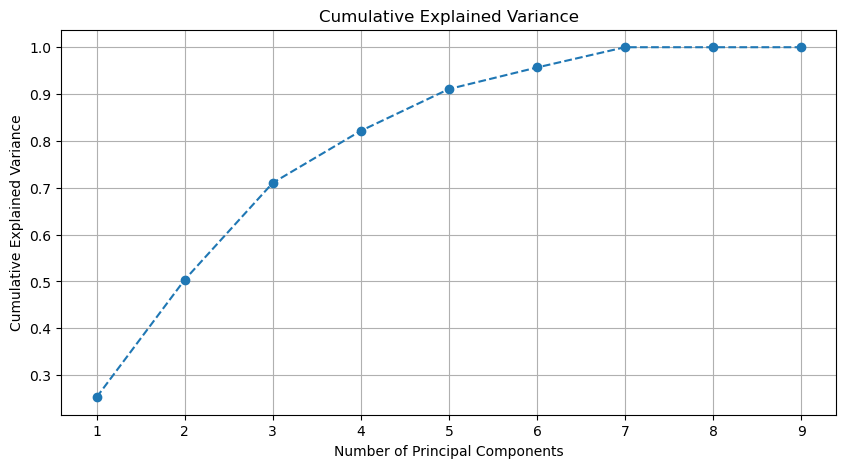

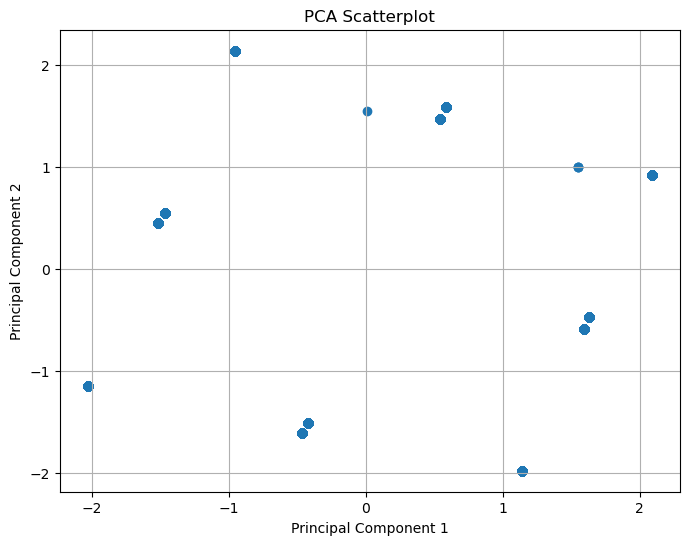

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Specify the directory where your VCF files are located
directory_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/12652705/'

# List all files in the directory
file_list = os.listdir(directory_path)

# Filter for VCF files (files with the ".vcf" extension)
vcf_files = [file for file in file_list if file.endswith('.vcf')]

# Create the full file paths for the VCF files
vcf_file_paths = [os.path.join(directory_path, vcf_file) for vcf_file in vcf_files]

# Initialize lists to store variant data
variants_data = []

# Assign a common barcode to all variants
common_barcode = 12652705  # Replace with the desired barcode value

# Parse each VCF file and extract variant data
for vcf_file in vcf_file_paths:
    with open(vcf_file, 'r') as file:
        for line in file:
            # Skip header lines in the VCF file
            if line.startswith('#'):
                continue
            
            # Split the line to extract variant data
            fields = line.strip().split('\t')
            
            # Check if the values in columns 4 and 5 (REF and ALT) are single characters
            if len(fields[3]) == 1 and len(fields[4]) == 1:
                # Extract variant information (columns 4 and 5, which are REF and ALT)
                variants = [fields[3], fields[4]]
                
                # Append the data as a dictionary with the common barcode
                variants_data.append({'Barcode': common_barcode, 'REF': fields[3], 'ALT': fields[4]})

# Create a DataFrame from the variant data
variants_df = pd.DataFrame(variants_data)

# Set the 'Barcode' column as the index
variants_df.set_index('Barcode', inplace=True)

# One-hot encode the 'REF' and 'ALT' columns
variants_df_encoded = pd.get_dummies(variants_df, columns=['REF', 'ALT'])

# Perform data preprocessing (standardization)
scaler = StandardScaler()
variants_scaled = scaler.fit_transform(variants_df_encoded)

# Perform PCA
n_components = min(variants_scaled.shape[0], variants_scaled.shape[1])
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(variants_scaled)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Choose the number of components (e.g., based on explained variance)

# Select a subset of principal components (e.g., the first few components)
num_selected_components = 2  # Adjust as needed
selected_components = principal_components[:, :num_selected_components]

# Visualize the samples in the PCA space
plt.figure(figsize=(8, 6))
plt.scatter(selected_components[:, 0], selected_components[:, 1])
plt.title('PCA Scatterplot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()
# You can now proceed with clustering, hypothesis testing, or further analysis based on the PCA results.

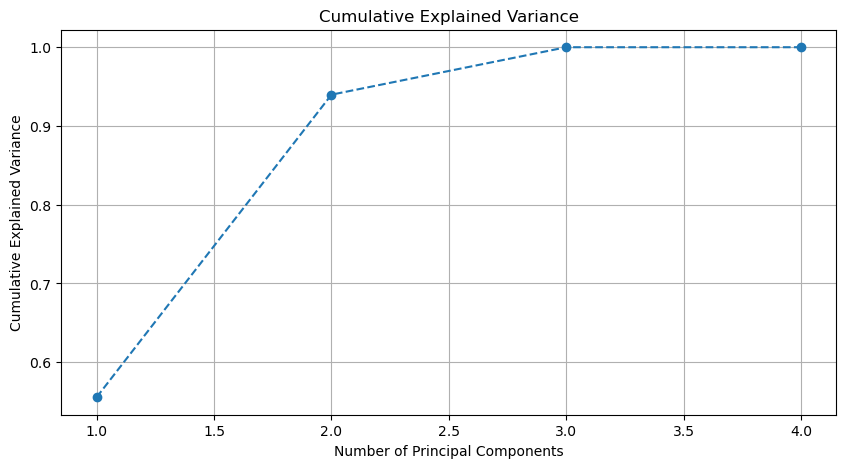

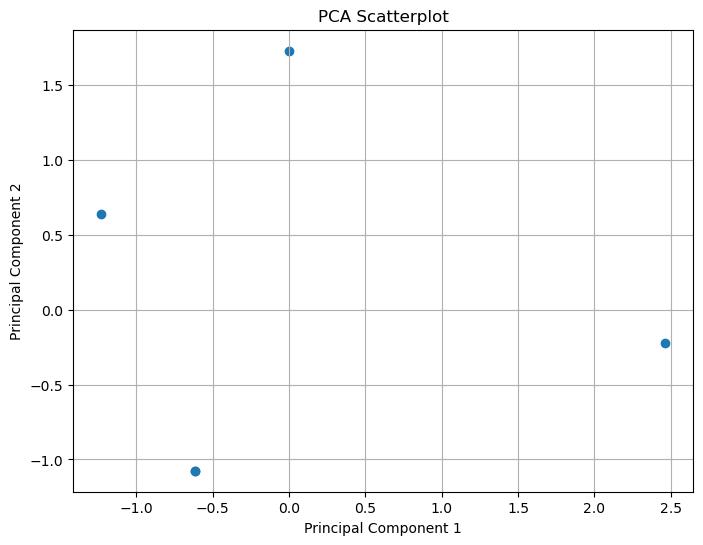

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sample data (you can replace this with your own data)
data = {
    'Barcode': [12652705, 12652705, 12652705, 12652705, 12652705],
    'REF_A': [1.0, 0.0, 1.0, 0.0, 1.0],
    'REF_C': [0.0, 0.0, 0.0, 1.0, 0.0],
    'ALT_A': [0.0, 1.0, 0.0, 0.0, 1.0],
    'ALT_C': [0.0, 0.0, 0.0, 0.0, 0.0],
}

# Create a DataFrame from the sample data
variants_df = pd.DataFrame(data)

# Set the 'Barcode' column as the index
variants_df.set_index('Barcode', inplace=True)

# Perform data preprocessing (standardization)
scaler = StandardScaler()
variants_scaled = scaler.fit_transform(variants_df)

# Perform PCA
n_components = min(variants_scaled.shape[0], variants_scaled.shape[1])
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(variants_scaled)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Choose the number of components (e.g., based on explained variance)

# Select a subset of principal components (e.g., the first few components)
num_selected_components = 2  # Adjust as needed
selected_components = principal_components[:, :num_selected_components]

# Visualize the samples in the PCA space
plt.figure(figsize=(8, 6))
plt.scatter(selected_components[:, 0], selected_components[:, 1])
plt.title('PCA Scatterplot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()
